# **Solving the Hypoxia puzzle: A Gene-Activity based Classification of Cells in Single-Cell RNA Sequencing Data**

Flavio Ubaldo Caroli                3159436  
Matteo Casiraghi                    3176978  
Mattia Maria Vincenzo Forzo         3182262  
Filippo Grosso                      3164000  
Luca Raffo                          3177868  

#### **Background** : Hypoxia, a condition characterized by inadequate oxygen supply to tissues, plays a crucial role in various physiological and pathological processes, including cancer. Understanding the molecular mechanisms underlying cellular responses to hypoxia is essential for advancing knowledge of these processes and potentially developing targeted therapeutic interventions. In this project, we present a gene-activity-based classification approach to solve the hypoxia puzzle in scRNA-seq data. By integrating gene expression profiles and prior knowledge of hypoxia-related genes, we aim to accurately identify and characterize cells in different oxygenation states.

#### **Objective** The primary goal of this notebook is to investigate cell classification based on gene activity, with a specific emphasis on distinguishing cells in normoxic and hypoxic states. This report aims to uncover discernible patterns and informative markers that can provide insights into the underlying mechanisms of cellular states. Furthermore, a dedicated section of the report focuses on feature selection, elucidating the crucial variables that significantly contribute to accurate classification and predictive modeling within this specific context.

# Packeges and functions needed to run the notebook

In [ ]:
# PECULIAR INSTALLATION

!pip install umap
!pip install umap_learn
!pip install scrublet
!pip install optuna
!pip install scanpy

In [169]:
# IMPORT PACKAGES


# General purpose
import sys
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import networkx as nx
from __future__ import print_function


# Visualisation
import seaborn as sns
from matplotlib import colormaps
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline     
sns.set(color_codes=True)


#Statistical inspection
from scipy import stats
from scipy.stats import skew
from scipy.stats import kurtosis


# Data cleaning
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import scrublet as scr
import scanpy as sc
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error


# Dimensionaluty reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from umap.umap_ import UMAP
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import AgglomerativeClustering
import optuna
from sklearn.cluster import KMeans


#Classification
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.svm import SVC
from scipy.stats import loguniform
import math
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import warnings
from scipy.stats import loguniform
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from scipy.stats import uniform
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier

# Loading the datsets

In [34]:
# SmartSeq MCF7

unf_smart_mc= pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/MCF7_SmartS_Unfiltered_Data.txt", delimiter="\ ", engine='python', index_col=0).T

fil_smart_mc = pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/MCF7_SmartS_Filtered_Data.txt", delimiter="\ ", engine='python', index_col=0).T

train_data_MCF7_SmartS = pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", engine='python', index_col=0).T

test_data_MCF7_SmartS = pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", engine='python', index_col=0).T

meta_smart_mc = pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/MCF7_SmartS_MetaData.tsv", delimiter="\t", engine='python', index_col=0)

meta_smart_mc.index= [f'"{i}"' for i in meta_smart_mc.index]

In [35]:
# SmartSeq HCC19806

unf_smart_hc= pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/HCC1806_SmartS_Unfiltered_Data.txt", delimiter="\ ", engine='python', index_col=0).T

fil_smart_hc = pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/HCC1806_SmartS_Filtered_Data.txt", delimiter="\ ", engine='python', index_col=0).T

train_data_HCC1806_SmartS = pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", engine='python', index_col=0).T

test_data_HCC1806_SmartS = pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", engine='python', index_col=0).T

meta_smart_hc = pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/SmartSeq/HCC1806_SmartS_MetaData.tsv", delimiter="\t", engine='python', index_col=0)

meta_smart_hc.index= [f'"{i}"' for i in meta_smart_hc.index]

In [37]:
# DropSeq MCF7

train_data_MCF7_DropS= pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/DropSeq/MCF7_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", engine='python', index_col=0).T

test_data_MCF7_DropS= pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/DropSeq/MCF7_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", engine='python', index_col=0).T


In [38]:
# DropSeq HCC106

train_data_HCC1806_DropS= pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/DropSeq/HCC1806_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", engine='python', index_col=0).T

test_data_HCC1806_DropS= pd.read_csv("/content/drive/MyDrive/AI LAB/DATA/DropSeq/HCC1806_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", engine='python', index_col=0).T


# **1)** **Exploratory Data Analysis (EDA)**

The first section of our report is concerned with the Exploratory Data Analysis.
In this part, we aim at gaining a deeper understanding of the data at hand, doing an initial assessment of data quality and data visualization.

## 1.0) Familiarization with the data

We start our analysis considering the datasets from SmartSeq sequencing regarding the MCF7 Cell Line.

In [42]:
# Inspect shape
print('Cells_unfiltered:', unf_smart_mc.shape[0])
print('Features_unfiltered:', unf_smart_mc.shape[1])

print('\nCells_filtered:', fil_smart_mc.shape[0])
print('Genes_filtered:',  fil_smart_mc.shape[1])

print('\nCells_train_normalised:', train_data_MCF7_SmartS.shape[0])
print('Genes_train_normalised:', train_data_MCF7_SmartS.shape[1])

print('\nCells_test_normalised:', test_data_MCF7_SmartS.shape[0])
print('Genes_test_normalised:', test_data_MCF7_SmartS.shape[1])

Cells_unfiltered: 383
Features_unfiltered: 22934

Cells_filtered: 313
Genes_filtered: 18945

Cells_train_normalised: 250
Genes_train_normalised: 3000

Cells_test_normalised: 63
Genes_test_normalised: 3000


In [43]:
unf_smart_mc.describe()

"WASH7P"  "MIR6859-1"    "WASH9P"   "OR4F29"  "MTND1P23"  "MTND2P28"  \
count  383.000000   383.000000  383.000000  383.00000  383.000000  383.000000   
mean     0.133159     0.026110    1.344648    0.05483    0.049608    6.261097   
std      0.618664     0.249286    2.244543    0.31477    0.229143    7.565749   
min      0.000000     0.000000    0.000000    0.00000    0.000000    0.000000   
25%      0.000000     0.000000    0.000000    0.00000    0.000000    0.000000   
50%      0.000000     0.000000    0.000000    0.00000    0.000000    3.000000   
75%      0.000000     0.000000    2.000000    0.00000    0.000000   10.000000   
max      9.000000     4.000000   20.000000    3.00000    2.000000   45.000000   

       "MTCO1P12"  "MTCO2P12"  "MTATP8P1"   "MTATP6P1"  ...     "MT-TH"  \
count  383.000000  383.000000  383.000000   383.000000  ...  383.000000   
mean     4.681462    0.524804    0.073107   222.054830  ...    1.060052   
std      6.232649    0.980857    0.298131   262.616874  ...    1.990566   
min      0.000000    0.000000    0.000000     0.000000  ...    0.000000   
25%      0.000000    0.000000    0.000000    23.000000  ...    0.000000   
50%      2.000000    0.000000    0.000000    98.000000  ...    0.000000   
75%      7.000000    1.000000    0.000000   370.500000  ...    1.000000   
max     36.000000    6.000000    2.000000  1662.000000  ...   15.000000   

         "MT-TS2"    "MT-TL2"     "MT-ND5"     "MT-ND6"     "MT-TE"  \
count  383.000000  383.000000   383.000000   383.000000  383.000000   
mean     0.443864    3.146214  1016.477807   204.600522    5.049608   
std      1.090827    4.265352  1009.444811   220.781927    6.644302   
min      0.000000    0.000000     0.000000     0.000000    0.000000   
25%      0.000000    0.000000   172.000000    30.500000    0.000000   
50%      0.000000    1.000000   837.000000   152.000000    3.000000   
75%      0.000000    5.000000  1549.000000   294.000000    7.000000   
max      8.000000   22.000000  8115.000000  2002.000000   46.000000   

          "MT-CYB"     "MT-TT"     "MT-TP"     "MAFIP"  
count    383.00000  383.000000  383.000000  383.000000  
mean    2374.97389    2.083551    5.626632    1.749347  
std     2920.39000    3.372714    7.511180    3.895204  
min        0.00000    0.000000    0.000000    0.000000  
25%      216.50000    0.000000    0.000000    0.000000  
50%      785.00000    0.000000    3.000000    0.000000  
75%     4059.00000    3.000000    8.000000    2.000000  
max    16026.00000   22.000000   56.000000   32.000000  

[8 rows x 22934 columns]

## 1.1) Inspecting expression levels

In [46]:
# EXTRACT CONDITION: retriving oxygenation condition of the cells from the label in the dataset.
def extract_condition(row_name):
    if 'Norm' in row_name:
        return 0
    elif 'Hypo' in row_name:
        return 1
    else:
        return None

We procede plotting values for the gene expression distribution across cells.

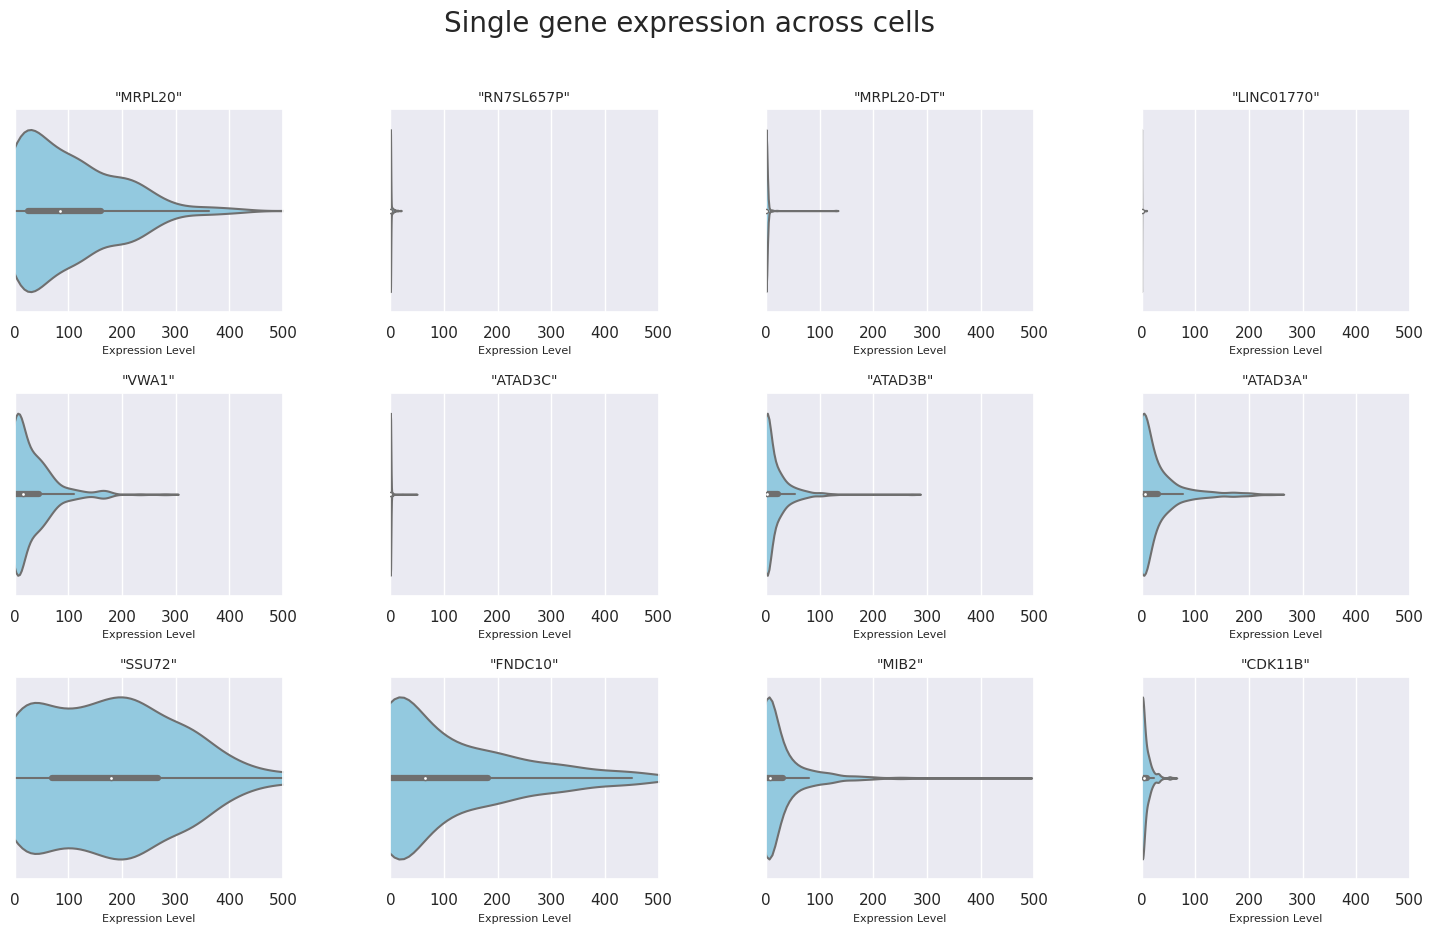

In [47]:
cnames = list(unf_smart_mc.columns)
nrows = 3
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Single gene expression across cells', fontsize=20)

for i, ax in enumerate(axes.flat):
    index = 50 + i
    if index < 62:
        column_name = cnames[index]
        sns.violinplot(x=unf_smart_mc[column_name], ax=ax, color='skyblue')
        ax.set_xlim([0,500]) 
        ax.set_title(column_name, fontsize=10)
        ax.set_xlabel('Expression Level', fontsize=8)
    else:
        ax.set_axis_off()

plt.show()

From the violin plots above it is possible to notice genes with very low expression for many cells.

A similar inspection can be done for the cells: using boxplots, it is possible to identify variations, outliers, and potential patterns across different cells.

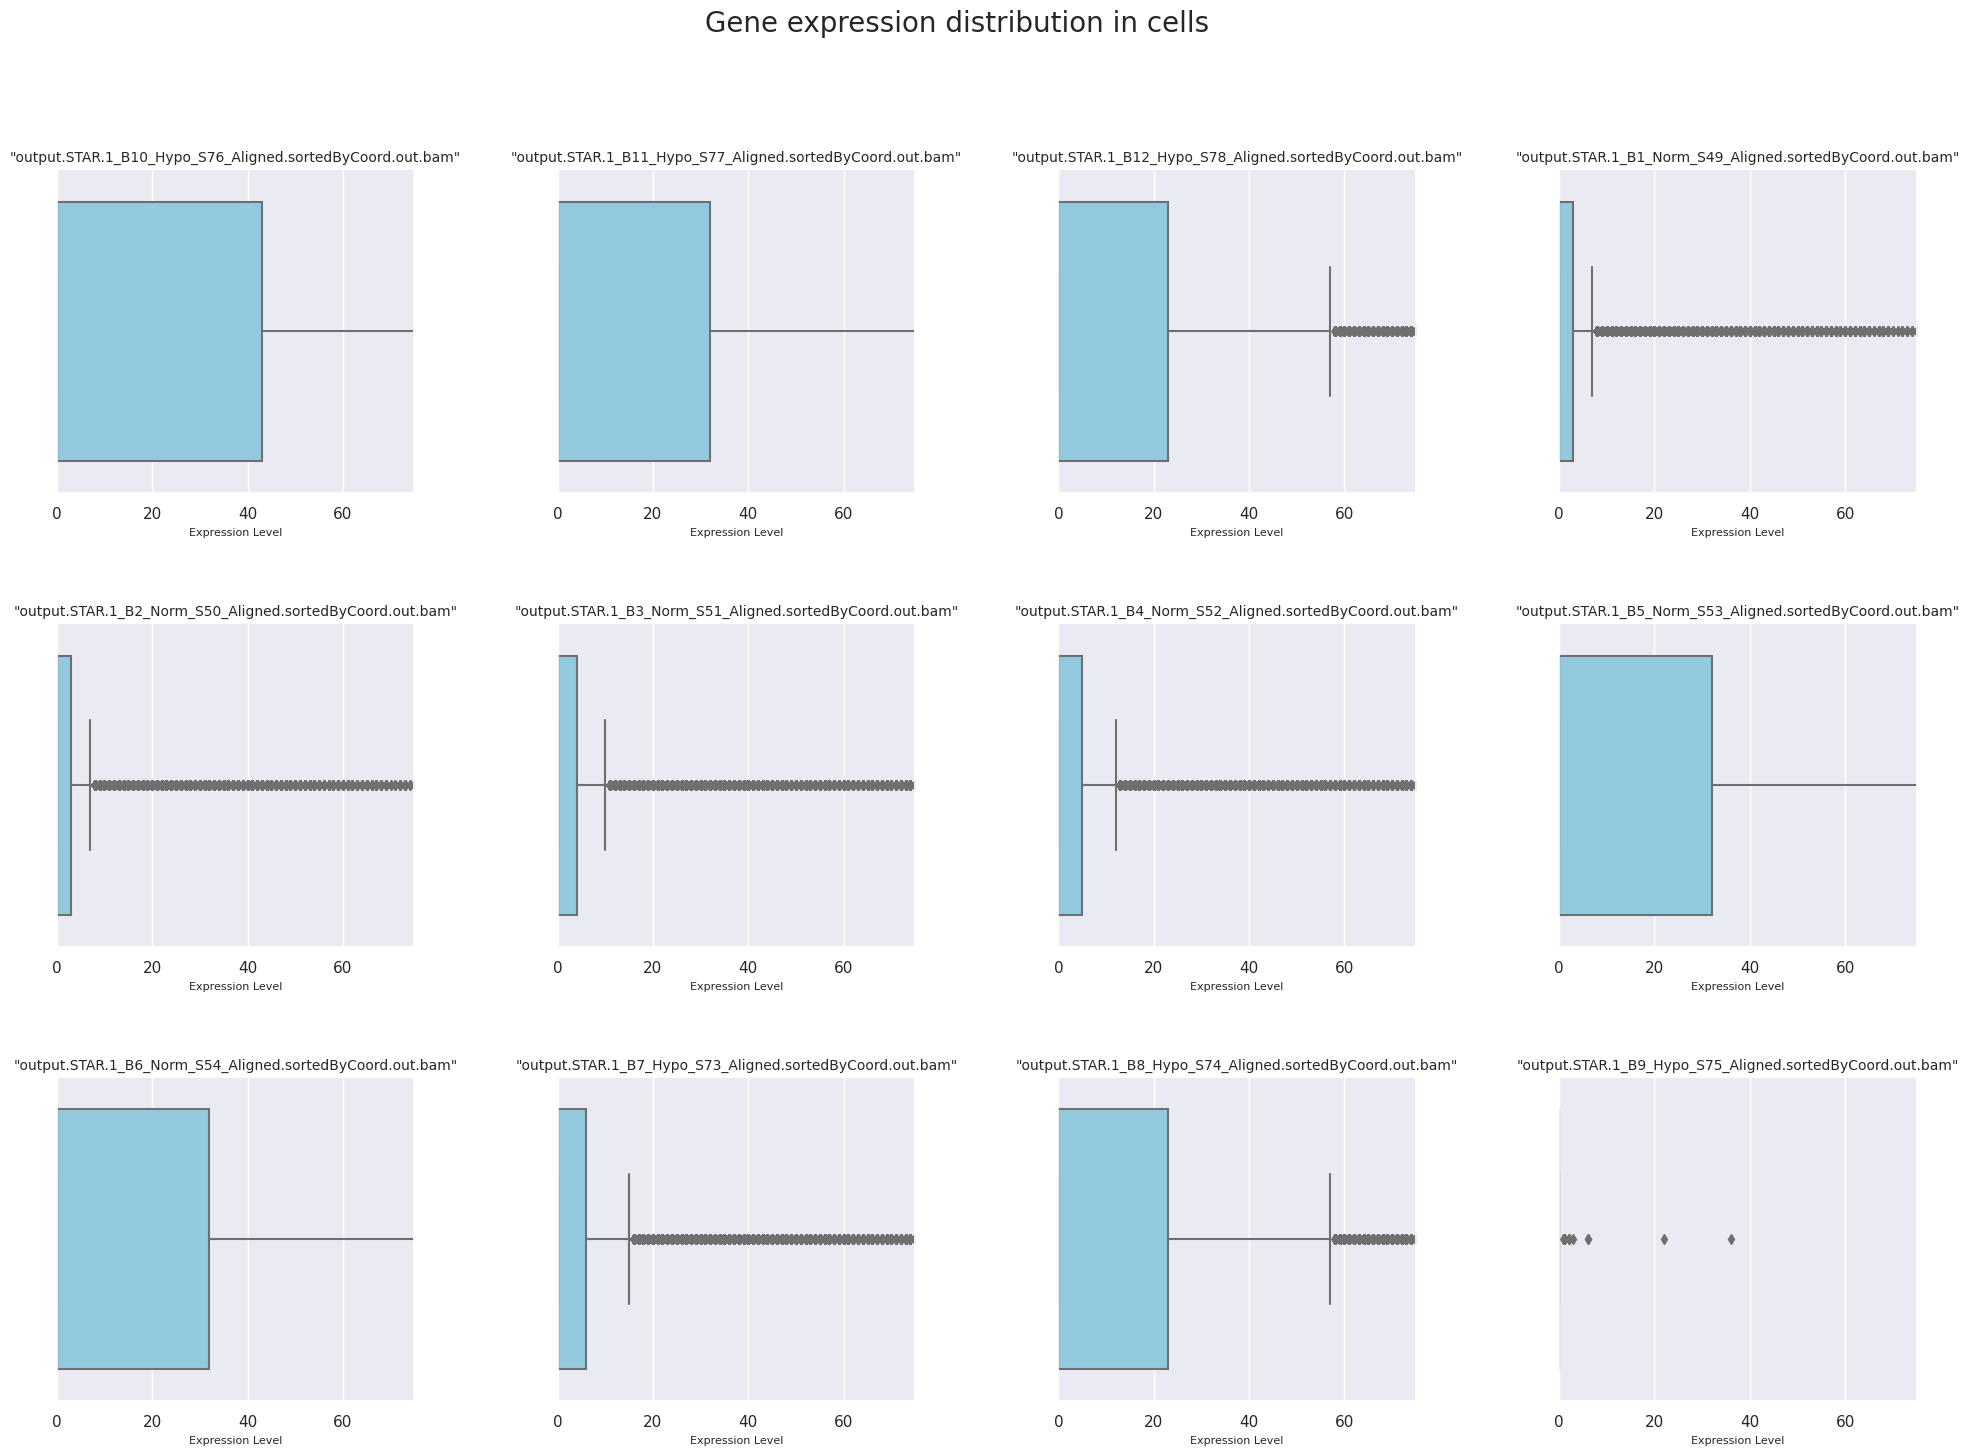

In [48]:
cnames = list(unf_smart_mc.T.columns)
nrows = 3
ncols = 4

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(24, 16))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Gene expression distribution in cells', fontsize=20)

for i, ax in enumerate(axes.flat):
    index = 12+ i
    if index < 24:
        column_name = cnames[index]
        sns.boxplot(x=unf_smart_mc.T[column_name], ax=ax, color='skyblue')
        ax.set_xlim([0,75])
        ax.set_title(column_name, fontsize=10)
        ax.set_xlabel('Expression Level', fontsize=8)
    else:
        ax.set_axis_off()

plt.show()


Taking a first look at the plots, one can notice the presence of some cells with low gene expression.

This already points out the need of further inspection of the data at hand, because we way be in presence of anomalies, both from a biological viewpoint (eg. low quality cells, non-correctly handled samples) and from a purely statistical point of view, as for the case of outliers.

#### 1.1.1) Sparsity check

Condition
0            192
1            191
dtype: int64
Overall sparsity level: 0.6021531646834907


Text(0, 0.5, 'Frequency of genes')

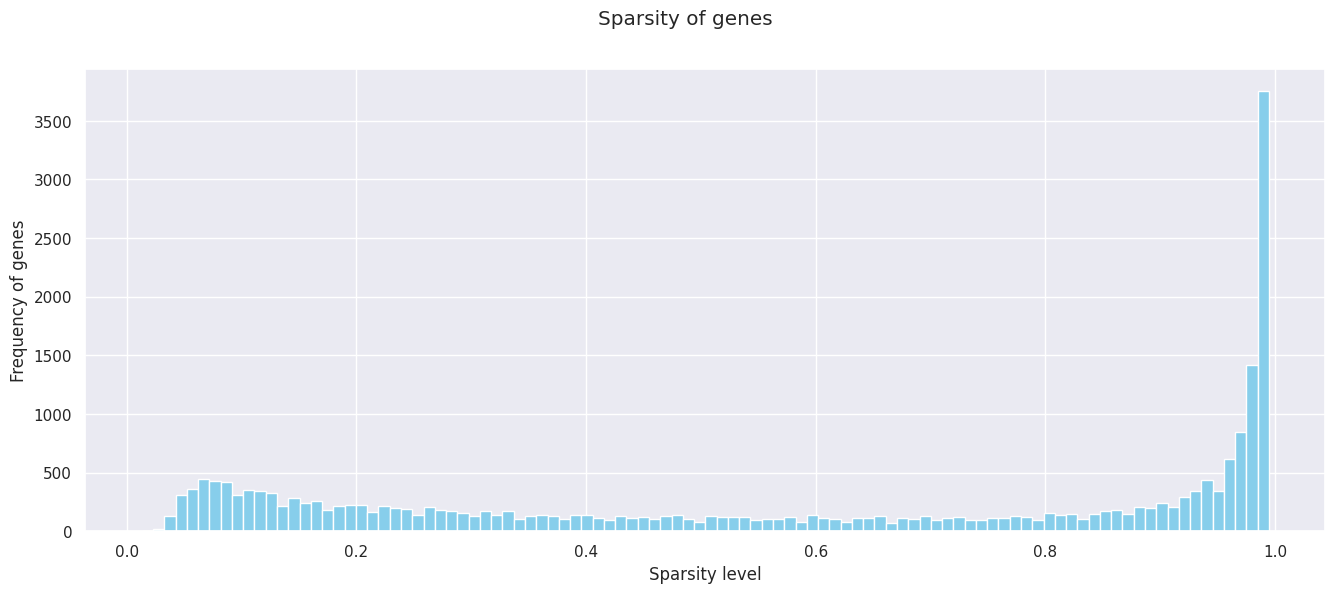

In [49]:
unf_condition= unf_smart_mc.index.to_series().apply(lambda x: extract_condition(x))
unf_condition.name = "Condition"
unf_condition = pd.DataFrame(unf_condition)
data = unf_smart_mc
combined_data = data.assign(Condition=data.index.to_series().apply(extract_condition))

data['Condition'] = combined_data['Condition'].values
unf_smart_mc = unf_smart_mc.T.drop("Condition").T


print(unf_condition.value_counts())

overall_sparsity = (unf_smart_mc == 0).sum().sum() / unf_smart_mc.size
print(f"Overall sparsity level: {overall_sparsity}")

sparsity_genes = (unf_smart_mc == 0).sum(axis=0) / unf_smart_mc.shape[0]


fig, ax = plt.subplots(figsize=(16, 6))
sns.set_style("white")
bars = ax.hist(sparsity_genes, bins=100, color='skyblue')
fig.suptitle("Sparsity of genes")
ax.set_xlabel("Sparsity level")
ax.set_ylabel("Frequency of genes")

We have a very sparse dataset.s parse datasets can lead to classification issues due to data imbalance and high dimensionality, often resulting in overfitting and difficulties in feature selection. With many zero entries, distinguishing relevant patterns becomes challenging, negatively affecting the model's performance on unseen data. Thus, we will handle this problem in 2.3) Genes inspection.

## 1.2) Visualization of correlation patterns

We now focus on the correlation instances present in the dataset. We shall go back to this topic later on. For the time being, we inspect correlation to visualize the relationships between variables and identify initial patterns. A more refined quantification of correlation in the data is to be found in section *2.2 Preprocessing of the data*.

### 1.2.0) Correlation among cells

A quick way to have an overview of correlation between cells is to use an heatmap for a datset with correlation values stored.\
In particluar we are interested in keeping track of how this values change according to the state of the cell (hypoxia or normoxia).

In [50]:
unf_condition=unf_smart_mc.index.to_series().apply(lambda x: extract_condition(x))
unf_condition.name = "Condition"

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


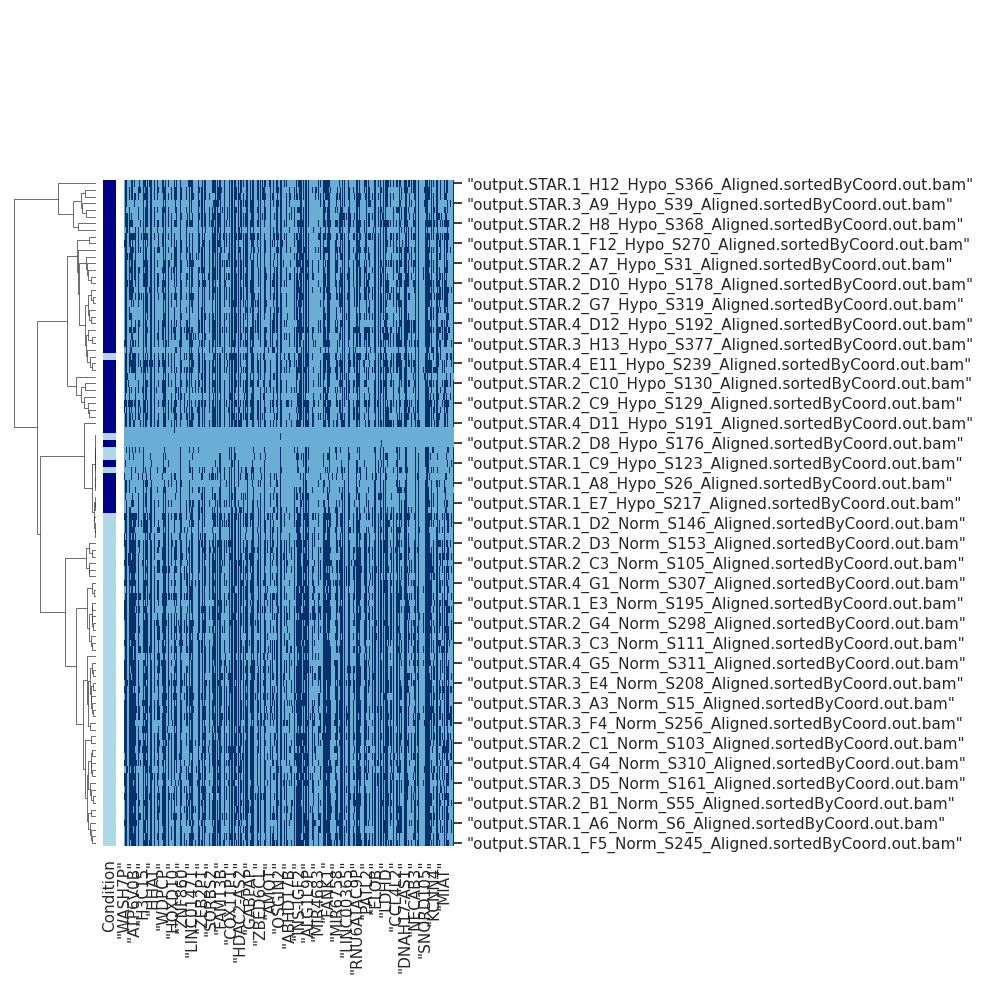

In [51]:
num_samples = 100  

unf_smart_mc_sample = unf_smart_mc.sample(n=num_samples)
unf_condition_sample = unf_condition[unf_smart_mc_sample.index]

palette = dict(zip(np.unique(unf_condition_sample), ['lightblue', 'darkblue']))

y_s = pd.Series(unf_condition_sample)
row_colors = y_s.map(palette)
row_colors.index = unf_smart_mc_sample.index

plot = sns.clustermap(unf_smart_mc_sample, method='ward', row_colors=row_colors, 
                      row_cluster=True, col_cluster=False, cmap='Blues', vmin=-1, vmax=1)

plot.cax.set_visible(False)

Another tool worth exploiting for exploring and visualizing the correlation between cells is the scatterplot.

*NOTE: time required to run the code snippet below depends on the number of subplots one wants to generate. We displayed 100 scaterplots as it turned out to be a good compromise between running time and the amount of information displayed.*

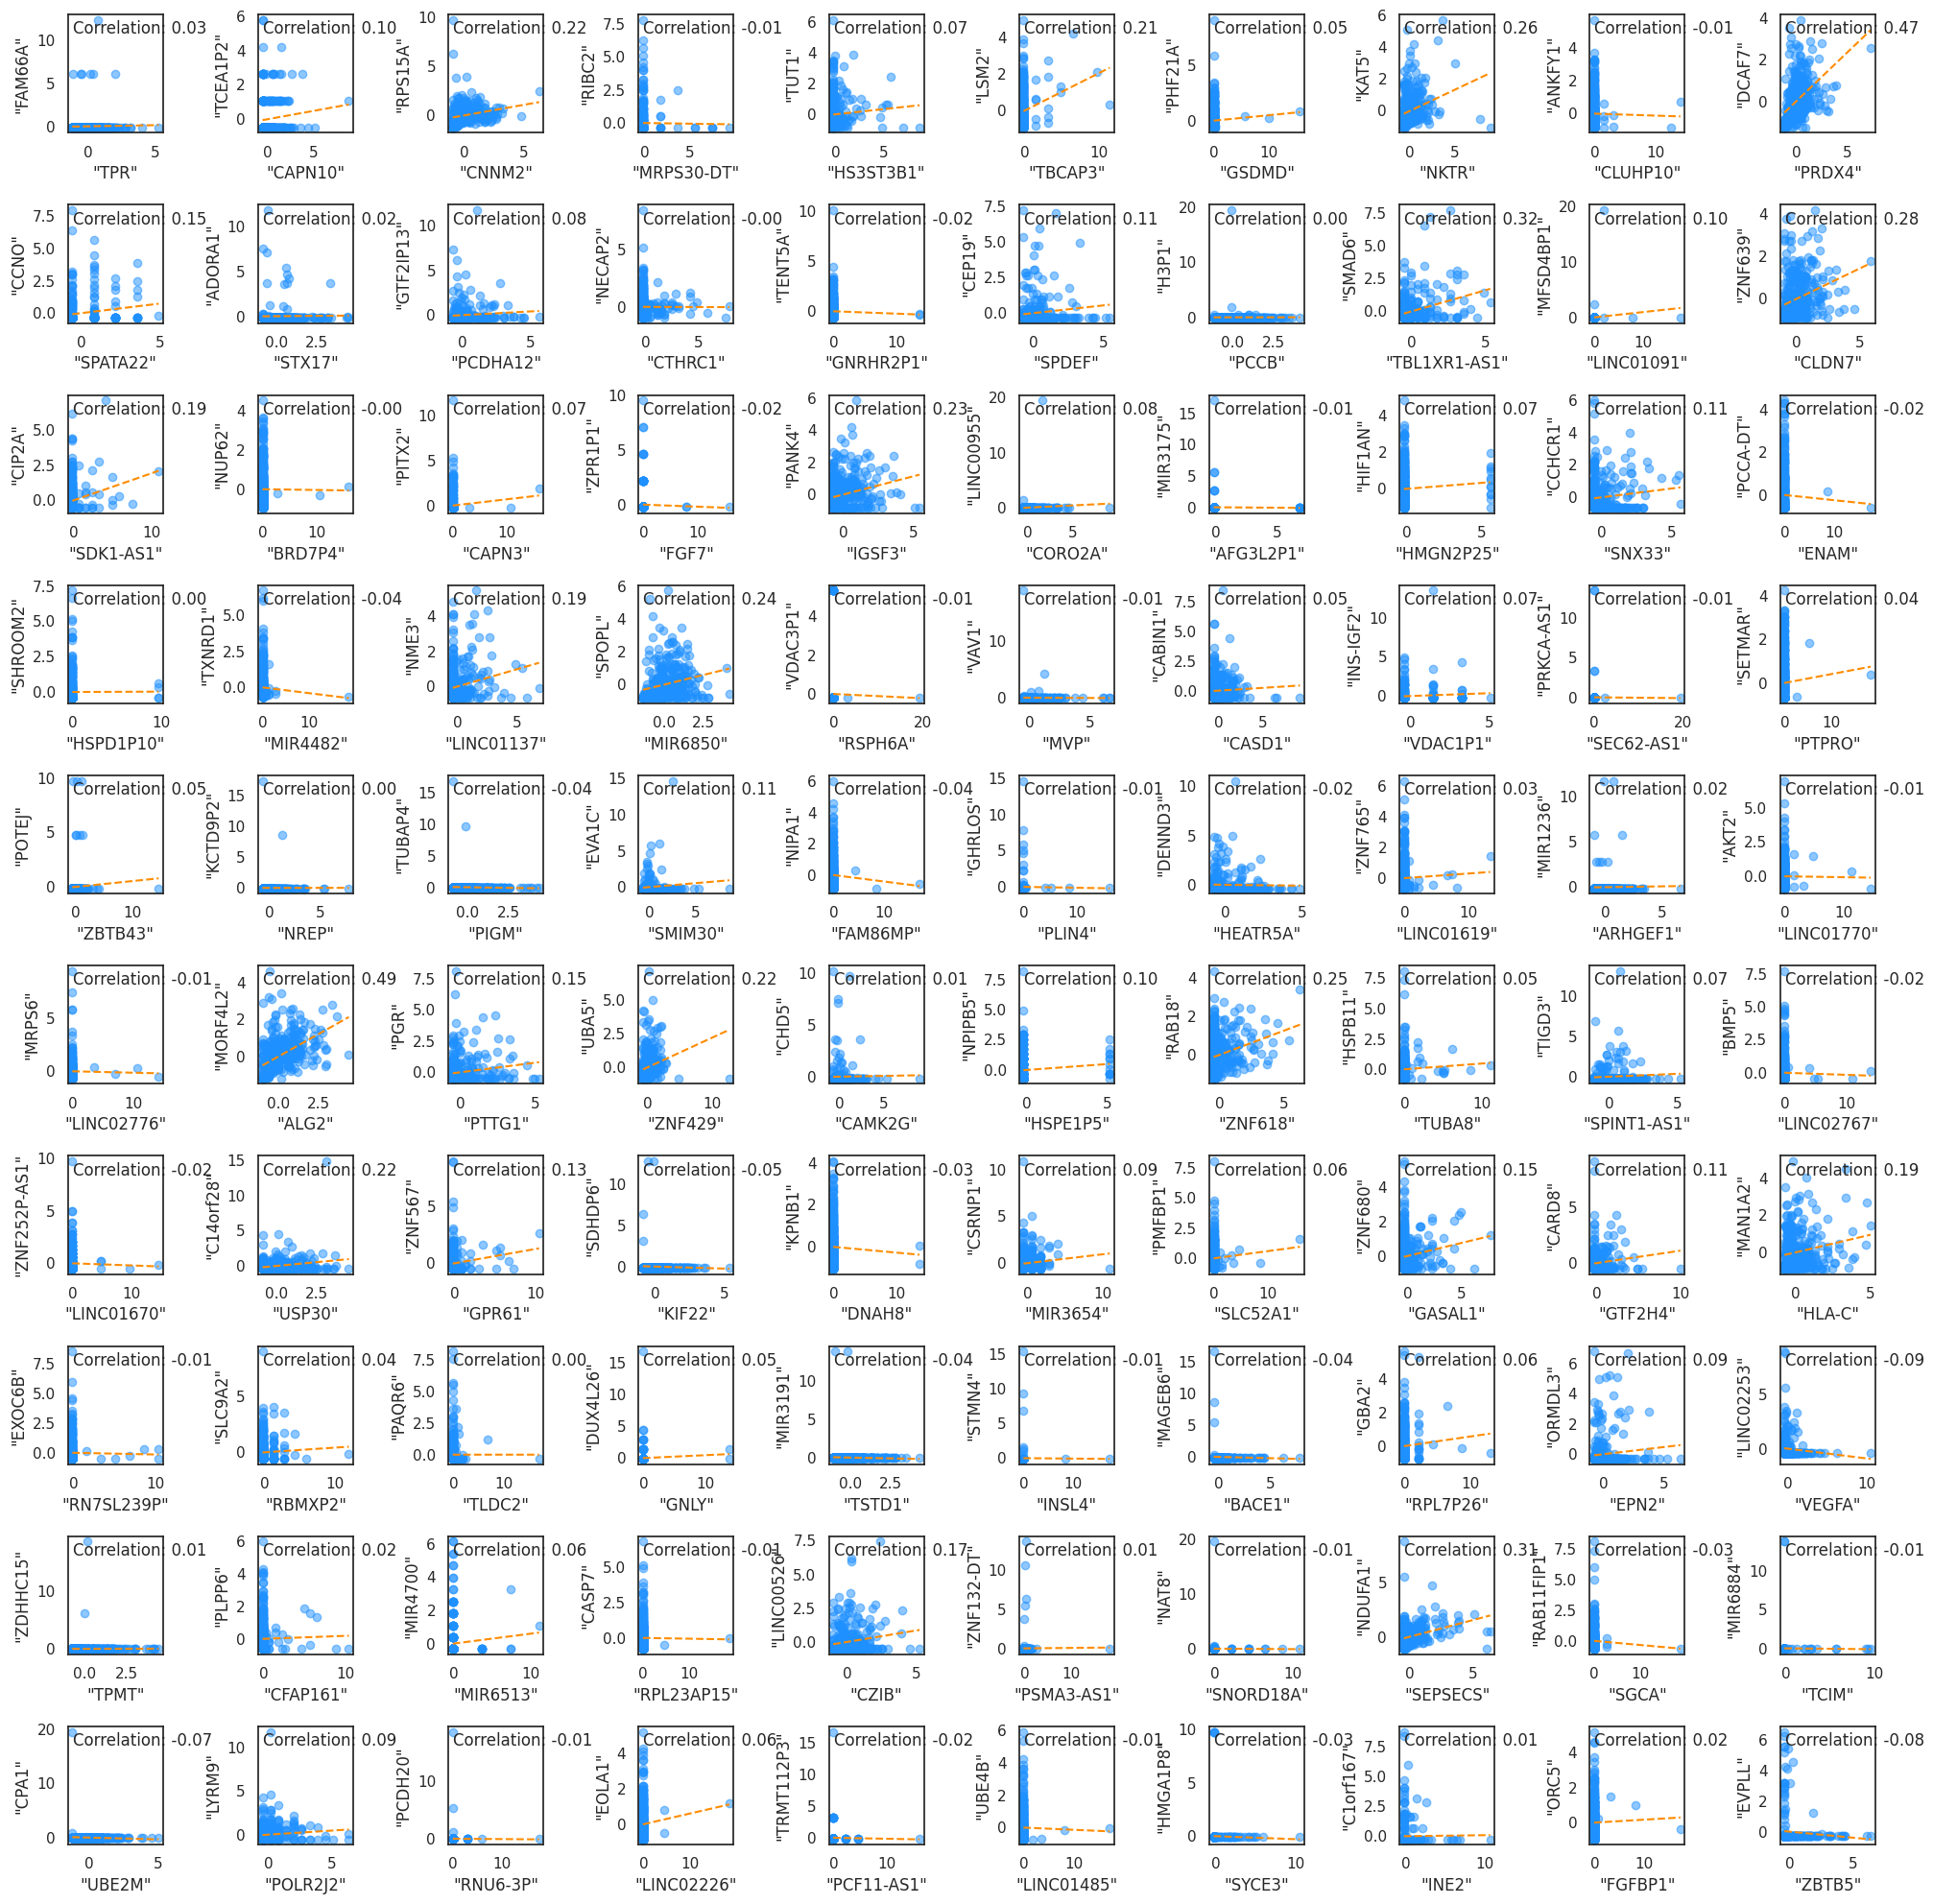

In [52]:
unf_smart_mc_1 = (unf_smart_mc - unf_smart_mc.mean(axis=0)) / unf_smart_mc.std()

df_transposed = unf_smart_mc_1.transpose()
row_names = df_transposed.index

np.random.seed(366)

random_combinations = np.random.choice(row_names, size=(100, 2), replace=False)
nrows, ncols = 10, 10

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
axes = axes.flatten()

for i, combination in enumerate(random_combinations):
    cell_1, cell_2 = combination
    
    x, y = df_transposed.loc[cell_1], df_transposed.loc[cell_2]
    correlation = np.corrcoef(x, y)[0, 1]

    ax = axes[i]
    ax.scatter(x, y, color='dodgerblue', alpha=0.5)
    ax.set_xlabel(cell_1)
    ax.set_ylabel(cell_2)
    ax.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='darkorange', linestyle='--')
    ax.text(0.05, 0.95, f'Correlation: {correlation:.2f}', transform=ax.transAxes, ha='left', va='top')

fig.tight_layout()
plt.show()

### 1.2.1) Correlation among genes

We now undergo a preliminary investigation of correlation instances among genes.

In the case of genes we are also interested in taking a deeper look to the correlation with the state of hypoxia and normoxia. This could point out patterns in the data useful for classification purposes.



We use a scatterplot matrix to display pairwise relationships.

In [53]:
data = unf_smart_mc
combined_data = data.assign(Condition=data.index.to_series().apply(extract_condition))

data['Condition'] = combined_data['Condition'].values
unf_smart_mc = unf_smart_mc.T.drop("Condition").T

In [54]:
data

"WASH7P"  "MIR6859-1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         0            0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0            0   
...                                                      ...          ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1            0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         1            0   

                                                    "WASH9P"  "OR4F29"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         1         0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         0         0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0         0   
...                                                      ...       ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0         0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         1         0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1         0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         4         1   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         5         0   

                                                    "MTND1P23"  "MTND2P28"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0           2   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0           1   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           0           2   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           7   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           0          29   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           0           5   

                                                    "MTCO1P12"  "MTCO2P12"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           2           0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           1           1   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           1           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           5           5   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           4           0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           3           0   

                                                    "MTATP8P1"  "MTATP6P1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0          29   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0          12   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...  

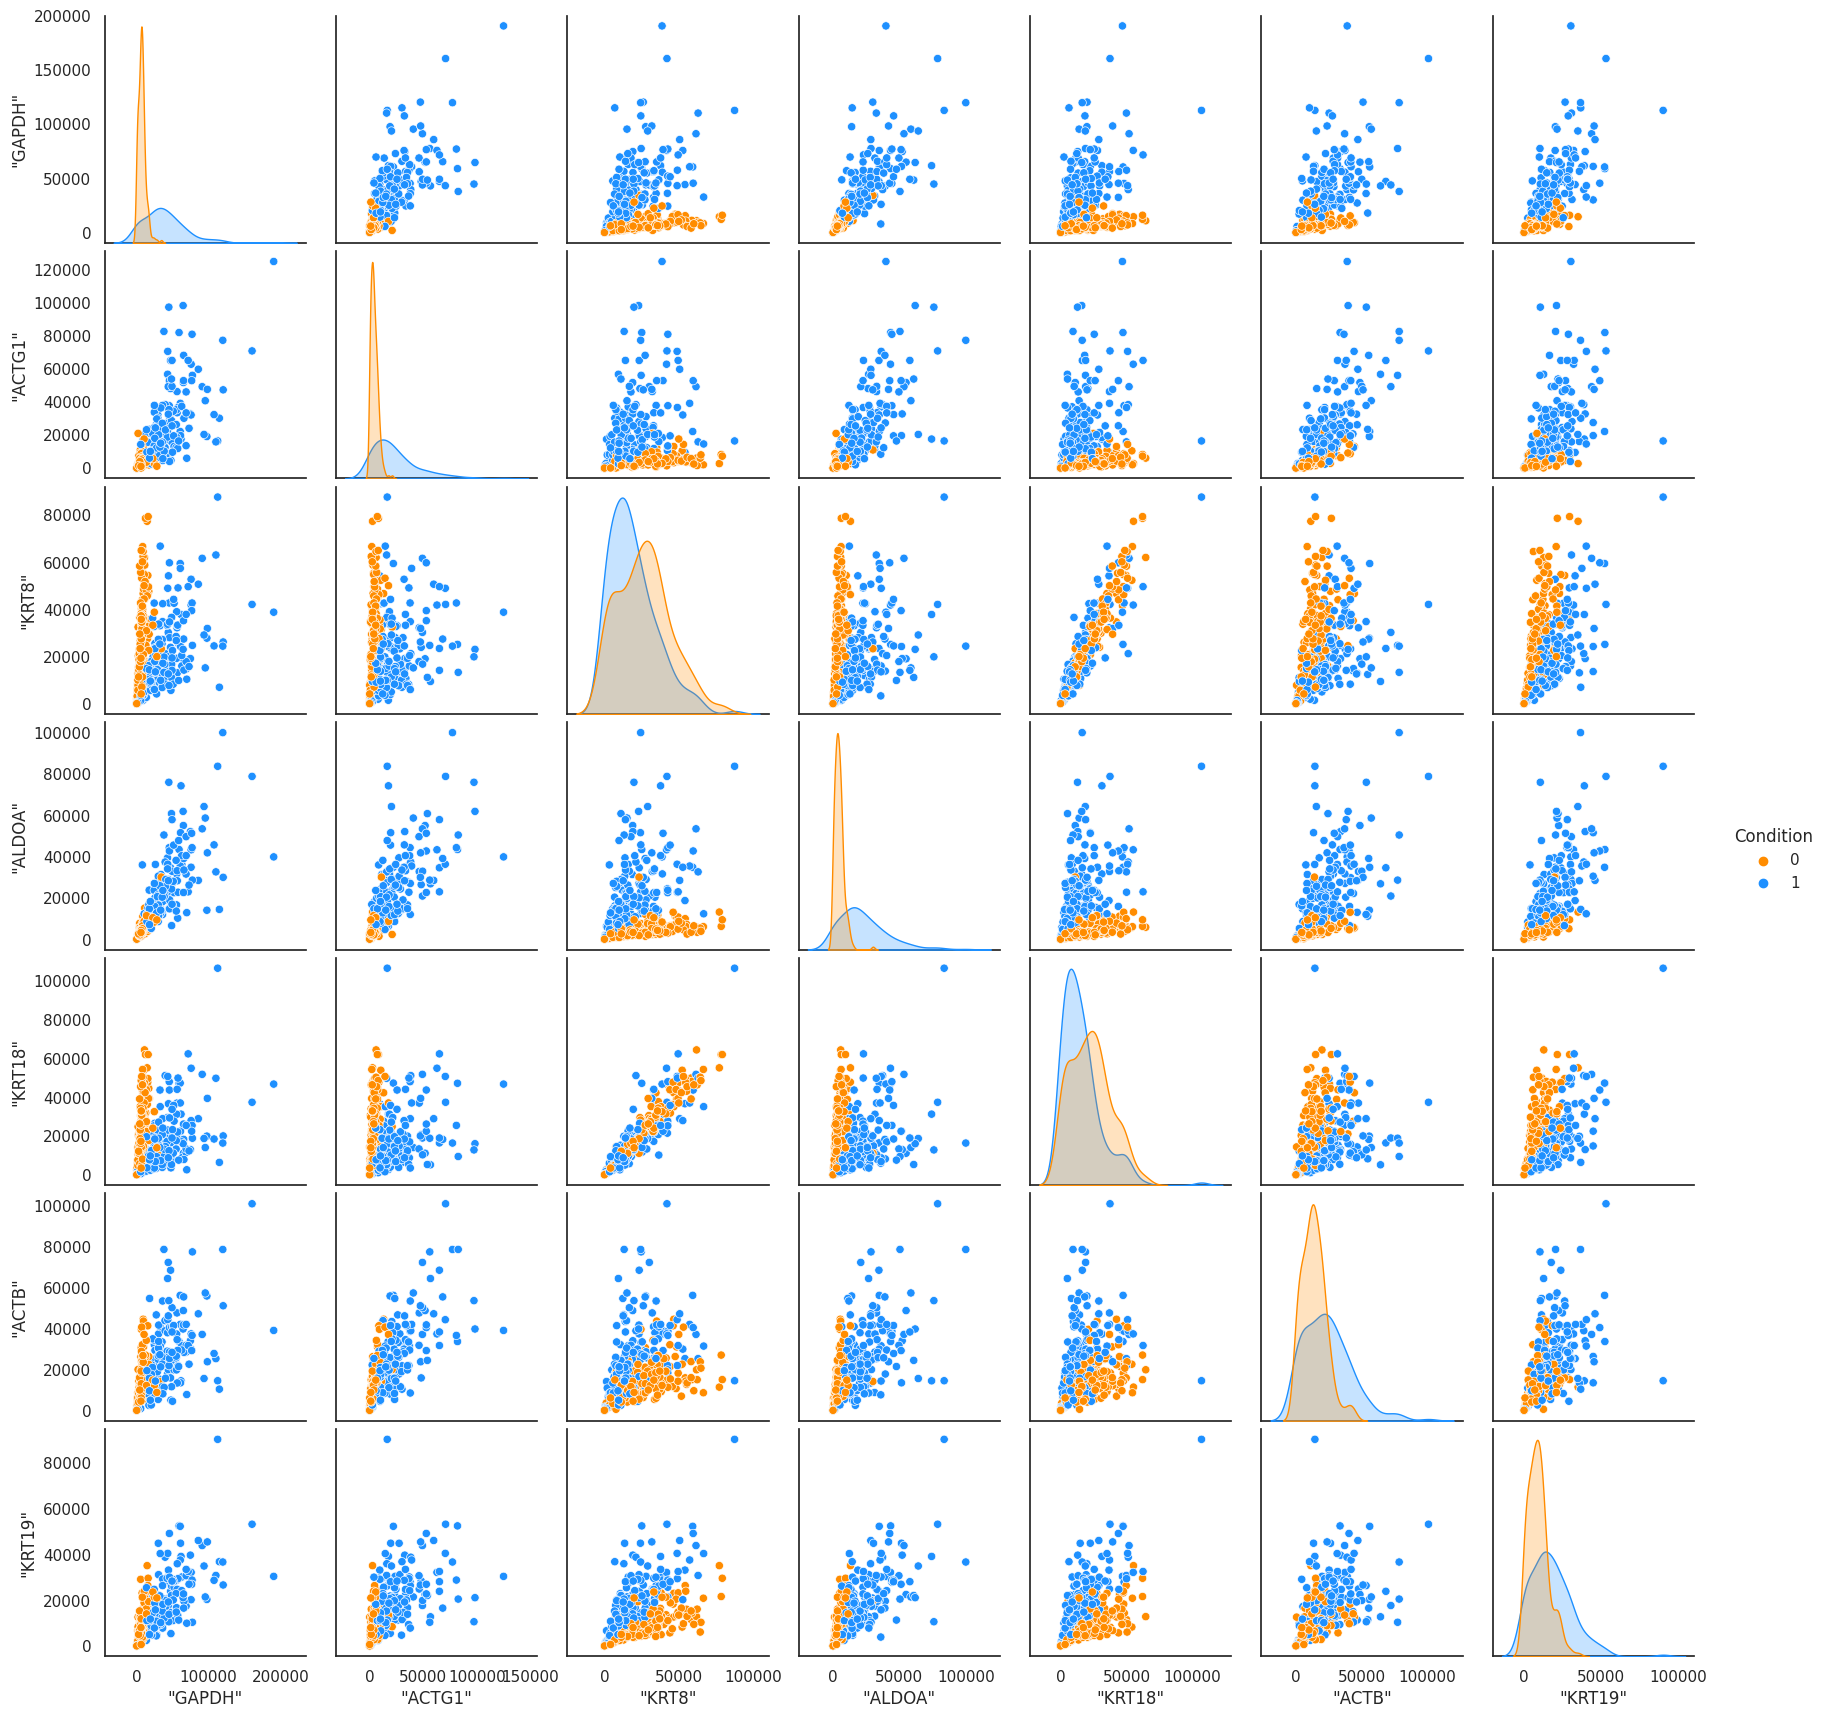

In [55]:
# Select a subset of genes to visualize
selected_genes = unf_smart_mc.var().nlargest(7).index

sns.pairplot(data[selected_genes.tolist() + ['Condition']], hue='Condition', palette=['darkorange', 'dodgerblue'])
plt.show()

Given the size of the dataset we will show results for correlation inspection only for a subset of the genes. Such genes are chosen at random, but fix fixed a seed to ensure reproducibility of the inspection.

Then we compute the correlation matrix for the sampled genes.

In [56]:
sample_genes = unf_smart_mc.sample(n=100, axis=1, random_state=700)
correlation_matrix = sample_genes.corr()
correlation_matrix

"MIR664B"  "FAM186B"  "SPIN2B"  "ARHGAP21"   "DNMBP"  "CYP4Z2P"  \
"MIR664B"     1.000000  -0.010078 -0.009983    0.045456  0.089068  -0.008181   
"FAM186B"    -0.010078   1.000000  0.036261   -0.039728 -0.029720  -0.021380   
"SPIN2B"     -0.009983   0.036261  1.000000    0.105632  0.204750   0.029868   
"ARHGAP21"    0.045456  -0.039728  0.105632    1.000000  0.112612   0.015190   
"DNMBP"       0.089068  -0.029720  0.204750    0.112612  1.000000  -0.020867   
...                ...        ...       ...         ...       ...        ...   
"KAT14"      -0.038433   0.109023  0.227368    0.114261  0.169376   0.036834   
"MUC5B"      -0.009354   0.064084  0.180658    0.052329  0.120465   0.002060   
"WWTR1"       0.305284  -0.068790 -0.010890    0.235592  0.155362  -0.019326   
"ESD"        -0.016835   0.041413  0.213339    0.225931  0.229346  -0.024842   
"LINC01879"  -0.005518  -0.003056 -0.032849   -0.036547 -0.028528  -0.011705   

             "KRT8P11"  "HIRIP3"  "ABCA10"  "GLUD1P2"  ...  "SMBD1P"  \
"MIR664B"    -0.015663 -0.024271 -0.009009  -0.010786  ... -0.011796   
"FAM186B"     0.103503  0.052914  0.032120  -0.028188  ... -0.031459   
"SPIN2B"      0.064062  0.117156 -0.072856   0.090092  ... -0.001858   
"ARHGAP21"    0.116239  0.058539  0.012721  -0.018384  ...  0.062927   
"DNMBP"       0.134038  0.067894 -0.005623   0.146320  ...  0.014779   
...                ...       ...       ...        ...  ...       ...   
"KAT14"       0.094013  0.266449  0.041758   0.213666  ...  0.066541   
"MUC5B"       0.014847 -0.020556 -0.012791   0.023280  ...  0.013218   
"WWTR1"      -0.006722  0.033028  0.146935   0.000756  ...  0.023907   
"ESD"         0.117300  0.164396 -0.045337   0.126111  ... -0.022306   
"LINC01879"  -0.040869 -0.017031 -0.012890  -0.015432  ... -0.019984   

               "LEO1"   "PRKCZ"  "TMEM191C"   "CDC20"   "KAT14"   "MUC5B"  \
"MIR664B"    0.022828  0.109398   -0.018336 -0.023214 -0.038433 -0.009354   
"FAM186B"    0.014089  0.014370    0.169633 -0.036663  0.109023  0.064084   
"SPIN2B"     0.252882  0.277873   -0.015852  0.090439  0.227368  0.180658   
"ARHGAP21"   0.182486  0.149377    0.129973  0.016508  0.114261  0.052329   
"DNMBP"      0.300209  0.182112    0.107116  0.067651  0.169376  0.120465   
...               ...       ...         ...       ...       ...       ...   
"KAT14"      0.399257  0.135968    0.167151  0.060779  1.000000  0.077208   
"MUC5B"      0.208845  0.000254    0.039068 -0.039375  0.077208  1.000000   
"WWTR1"      0.116597  0.154011   -0.002387 -0.047904  0.041068 -0.026035   
"ESD"        0.493092  0.090062    0.061361 -0.003596  0.370389  0.093947   
"LINC01879" -0.057343 -0.011603   -0.030687  0.017429 -0.012234 -0.016687   

              "WWTR1"     "ESD"  "LINC01879"  
"MIR664B"    0.305284 -0.016835    -0.005518  
"FAM186B"   -0.068790  0.041413    -0.003056  
"SPIN2B"    -0.010890  0.213339    -0.032849  
"ARHGAP21"   0.235592  0.225931    -0.036547  
"DNMBP"      0.155362  0.229346    -0.028528  
...               ...       ...          ...  
"KAT14"      0.041068  0.370389    -0.012234  
"MUC5B"     -0.026035  0.093947    -0.016687  
"WWTR1"      1.000000  0.145475    -0.036223  
"ESD"        0.145475  1.000000    -0.038520  
"LINC01879" -0.036223 -0.038520     1.000000  

[100 rows x 100 columns]

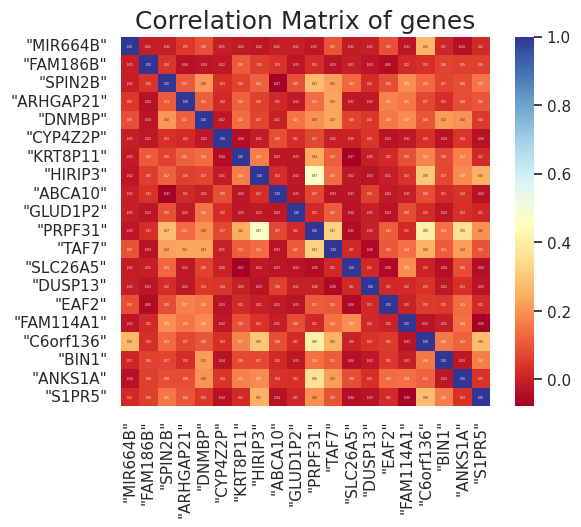

In [57]:
# Heatmap
sns.heatmap(correlation_matrix.iloc[:20, :20], vmax=1, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 2}, cmap='RdYlBu')
plt.yticks([i + 0.5 for i in range(20)], correlation_matrix.index[:20])
plt.xticks([i + 0.5 for i in range(20)], correlation_matrix.columns[:20])
plt.title("Correlation Matrix of genes", fontsize=18)
plt.show()


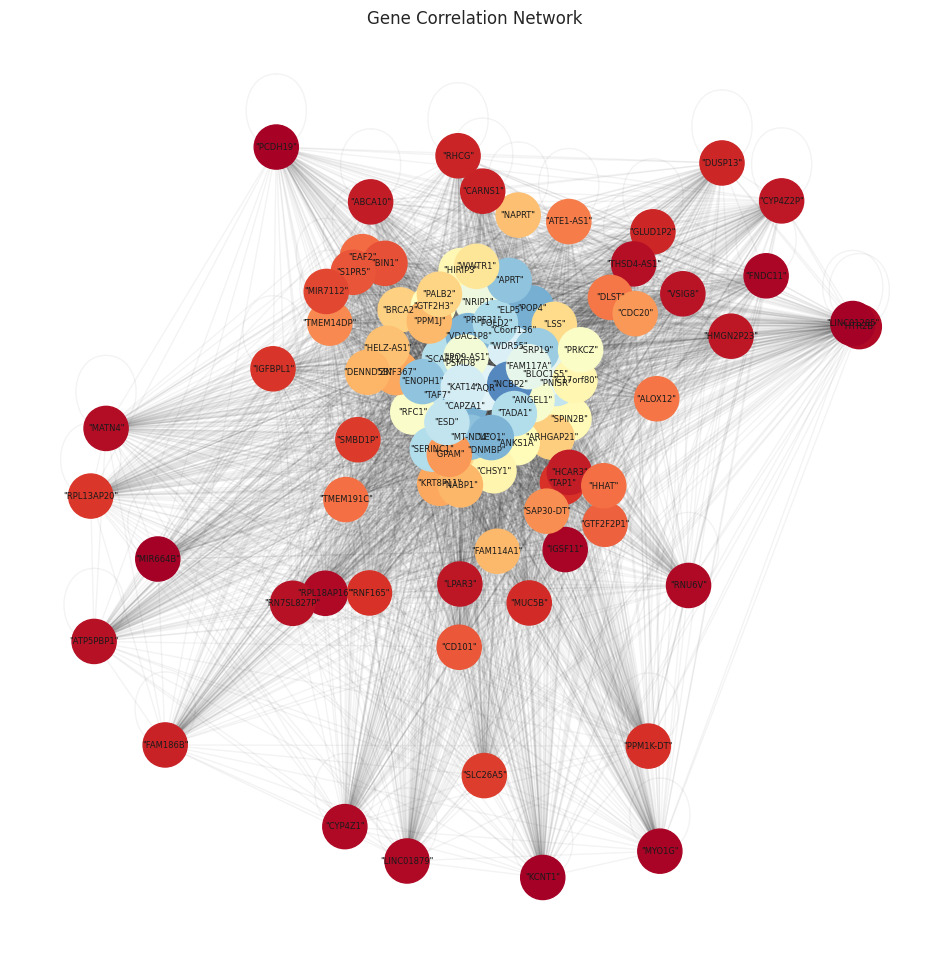

In [58]:
# Correlation network 
G = nx.from_numpy_array(correlation_matrix.values)

node_labels = {i: col for i, col in enumerate(sample_genes.columns)}
node_sizes = [d * 10 for d in dict(G.degree()).values()]

sample_genes_norm = (sample_genes/sample_genes.std())
gene_activities = list(sample_genes_norm.mean(axis=0))

cmap = plt.cm.viridis
norm = plt.Normalize(min(gene_activities), max(gene_activities))
node_colors = [cmap(norm(act)) for act in gene_activities]

plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G, k=0.5)
node_collection = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=gene_activities, cmap=colormaps['RdYlBu'])
node_collection.set_norm(norm)
nx.draw_networkx_edges(G, pos, alpha=0.05)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=6)
plt.axis('off')
plt.title('Gene Correlation Network')

plt.show()

In the correlation network based on the correlation matrix of gene expression data each gene is represented as a node, and the edges represent the pairwise correlations between genes. The nodes are sized based on their degrees, and their colors represent the gene activities at the et of their standard deviation. Here closer nodes indicate a higher level of correlation.

Both the correlation matrix and the correlation network show interesting patterns in the data. We can notice genes with high gene activity to cluster together as having high correlation. This however is clearly not an exhaustive data visualization given the reduced sample we operated on.

Now we concentrate ourselves on the correlation of genes with the hypoxic state.

## 1.3) Checking empirical distribution

The dataset does have enough samples to hope for a normal distribution via Central Limit Theorem. However we are intereseted in veryfing the deviation from normality to asses wheteher it is reasonable to adopt the normal approximation.

For this task we use a qq-plot against the normal quantiles, measures as skewness and kurtosis and finally we run a Shapiro-Wilk test to quantify eventual deviations from the normal.

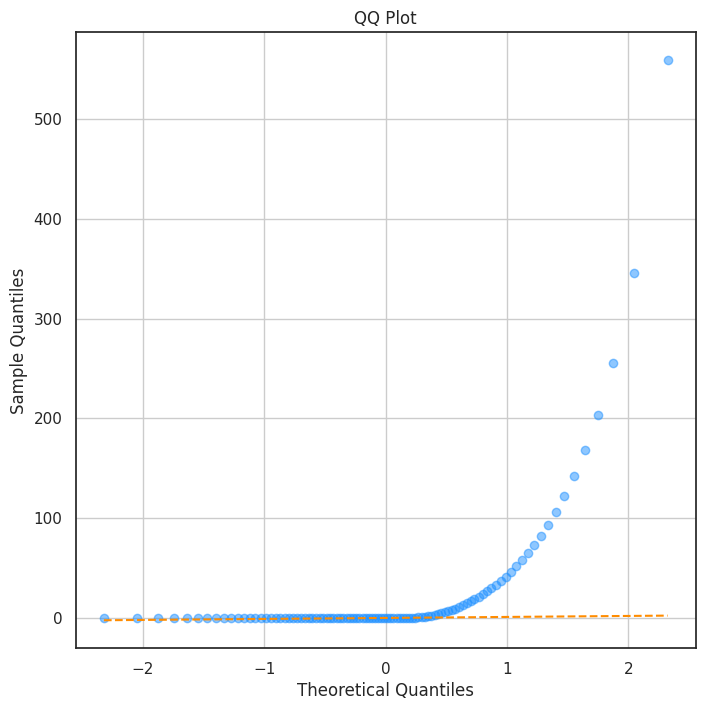

In [59]:
#QQ-plot

quantiles = np.quantile(unf_smart_mc, np.linspace(0, 1, 100))

theoretical_quantiles = stats.norm.ppf(np.linspace(0, 1, 100))

plt.figure(figsize=(8, 8))
plt.scatter(theoretical_quantiles, quantiles, alpha=0.5, color='dodgerblue')
plt.plot(theoretical_quantiles, theoretical_quantiles, color='darkorange', linestyle='--')
plt.title('QQ Plot')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.grid(True)
plt.show()

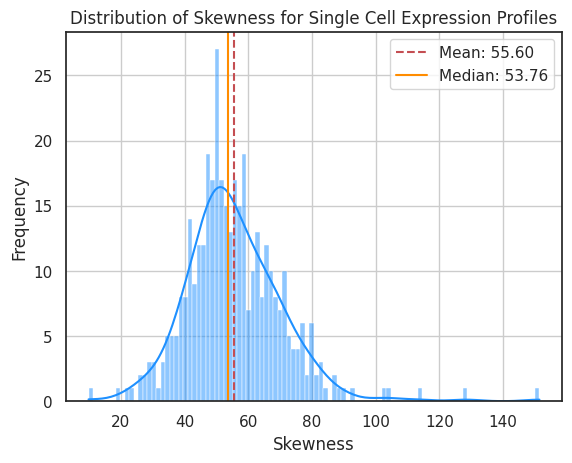

In [60]:
#Checking Skewness

cnames = list(unf_smart_mc.T.columns)

colN = np.shape(unf_smart_mc.T)[1]
df_skew_cells = []

for i in range(colN):    
     v_df = unf_smart_mc.T[cnames[i]]
     df_skew_cells += [skew(v_df)]   

mean_skew = np.mean(df_skew_cells)
median_skew = np.median(df_skew_cells)

sns.histplot(df_skew_cells, bins=100, color='dodgerblue', kde=True)

plt.axvline(mean_skew, linestyle='--', label=f'Mean: {mean_skew:.2f}', color='r')
plt.axvline(median_skew, color='darkorange', linestyle='-', label=f'Median: {median_skew:.2f}')

plt.legend()
plt.xlabel('Skewness of single cells expression profiles')
plt.ylabel('Frequency')
plt.xlabel('Skewness')
plt.ylabel('Frequency')
plt.title('Distribution of Skewness for Single Cell Expression Profiles')
plt.grid(True)
plt.show()

Skewness is a statistical measure that captures the degree of asymmetry in the distribution of a dataset. In particular, it provides information about the direction of outliers (for a positive skew, the tail of a distribution curve is longer on the right side).

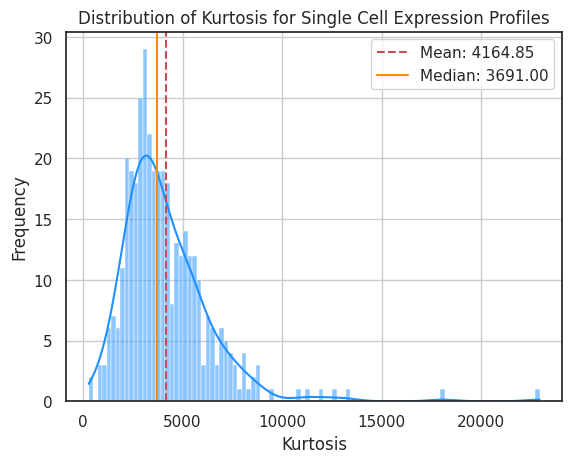

In [61]:
# Checking Kurtosis

df_kurt_cells = []
for i in range(colN) :     
     v_df = unf_smart_mc.T[cnames[i]]
     df_kurt_cells += [kurtosis(v_df)]
df_kurt_cells

mean_kurt = np.mean(df_kurt_cells)
median_kurt = np.median(df_kurt_cells)

sns.histplot(df_kurt_cells, bins=100, color='dodgerblue', kde=True)

plt.axvline(mean_kurt, color='r', linestyle='--', label=f'Mean: {mean_kurt:.2f}')
plt.axvline(median_kurt, color='darkorange', linestyle='-', label=f'Median: {median_kurt:.2f}')

plt.legend()
plt.xlabel('Kurtosis of single cells expression profiles')
plt.ylabel('Frequency')
plt.xlabel('Kurtosis')
plt.ylabel('Frequency')
plt.title('Distribution of Kurtosis for Single Cell Expression Profiles')
plt.grid(True)
plt.show()

Kurtosis is a statistical measure that quantifies the shape of a probability distribution. It measures the "heaviness" of the tails and the presence of outliers in the data compared to a normal distribution.

Moreover the values for kurtosis ad skewess are usued to check the differece of the emirical distriution of the data from normal distribution.

In [62]:
# Shapiro-Wilk test
statistic, p_value = stats.shapiro(unf_smart_mc)

print("Shapiro-Wilk Test:")
print(f"Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")

# Check for normality based on p-value
alpha = 0.05  # Significance level
if p_value > alpha:
    print("The data appears to be normally distributed.")
else:
    print("The data does not appear to be normally distributed.");

Shapiro-Wilk Test:
Statistic: 0.0386
P-value: 0.0000
The data does not appear to be normally distributed.


/usr/local/lib/python3.10/dist-packages/scipy/stats/_morestats.py:1816: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


As it can be seen from the plot of skewnees and kurtosis, and from the result of the Shapiro-Wilk test the data are, as expected, not normally distributed.\
Looking at the QQ-plot and the p-value of the Shapiro-Wilk test, we ackowledge a significant deviation from the normal.

# **2)** **Preprocessing of the Data**


When dealing with preprocessing we consider two main aspects: the biological and the mathematical-statisticalcharacteristics of the data.

When it comes to biological filtering of the data, we try to identify the anomalies of biological origin. This involves detecting instances such as dead cells or situations where multiple cells are unintentionally captured together and sequenced as a single cell, commonly referred to as doublets.

In terms of the mathematical aspects, we adhere to the existing literature of the field.

By incorporating both biological and mathematical considerations, our preprocessing methodology aims to refine the data and enhance its quality for further analysis. This is particularly relevant to our investigation of the relationship between gene activity and cellular oxygenation conditions.

## 2.0) Prelimiary Cleaning

### 2.0.1) Handling Dataset Values: None, Nan, and Missings

In [ ]:
print("Shape of the dataset:", unf_smart_mc.shape)

In [64]:
print("Number of missing values in each column:")
print(unf_smart_mc.isnull().sum())

Number of missing values in each column:
"WASH7P"       0
"MIR6859-1"    0
"WASH9P"       0
"OR4F29"       0
"MTND1P23"     0
              ..
"MT-TE"        0
"MT-CYB"       0
"MT-TT"        0
"MT-TP"        0
"MAFIP"        0
Length: 22934, dtype: int64


In [65]:
print("Number of missing values in each row:")
print(unf_smart_mc.T.isnull().sum())

Number of missing values in each row:
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"    0
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"    0
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"    0
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"      0
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"      0
                                                             ..
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam"    0
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam"    0
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam"    0
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam"    0
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam"    0
Length: 383, dtype: int64


In [66]:
print("Number of None values in the dataset:", data.isin([None]).sum().sum())

Number of None values in the dataset: 0


In [67]:
non_numeric_count = 0
for column in data.columns:
    non_numeric_count += pd.to_numeric(data[column], errors='coerce').isna().sum()

print("Number of non-numeric values in the dataset:", non_numeric_count)

Number of non-numeric values in the dataset: 0


### 2.0.2) Duplicates


In [68]:
tot = len(unf_smart_mc.T)
unf_smart_mc = unf_smart_mc.T.drop_duplicates().T
print("Number of duplicates:", tot - len(unf_smart_mc.T))

tot = len(unf_smart_mc)
unf_smart_mc = unf_smart_mc.drop_duplicates()
print("Number of duplicates:", tot - len(unf_smart_mc))

unf_smart_mc

Number of duplicates: 29
Number of duplicates: 0


"WASH7P"  "MIR6859-1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         0            0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0            0   
...                                                      ...          ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1            0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         1            0   

                                                    "WASH9P"  "OR4F29"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         1         0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         0         0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0         0   
...                                                      ...       ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0         0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         1         0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1         0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         4         1   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         5         0   

                                                    "MTND1P23"  "MTND2P28"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0           2   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0           1   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           0           2   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           7   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           0          29   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           0           5   

                                                    "MTCO1P12"  "MTCO2P12"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           2           0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           1           1   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           1           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           5           5   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           4           0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           3           0   

                                                    "MTATP8P1"  "MTATP6P1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0          29   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0          12   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...  

## 2.1) Outlier inspection 

Our exploration of outliers begins by examining the distribution through a histogram analysis.

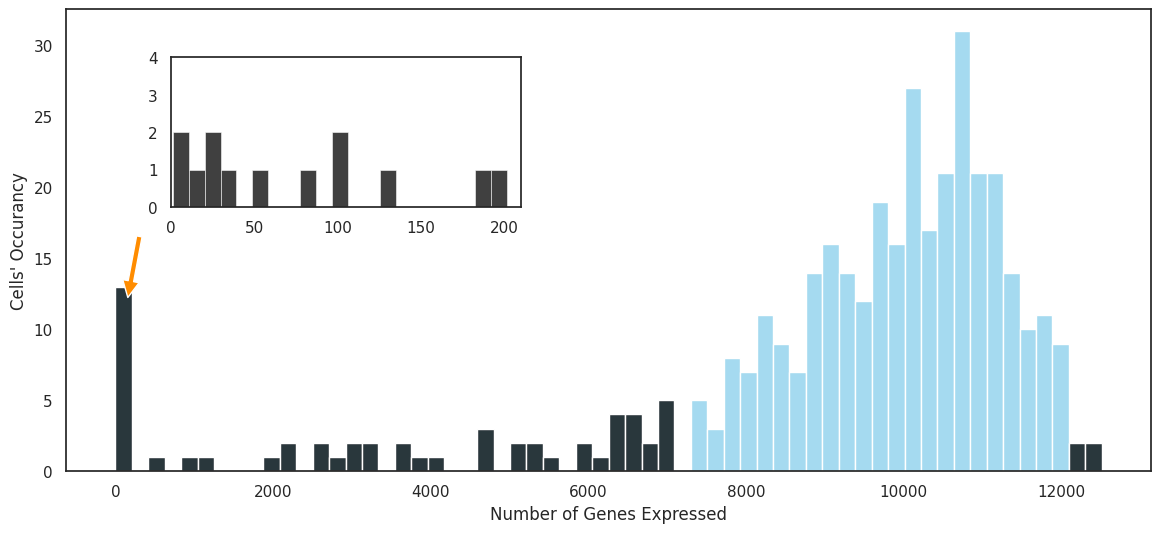

In [69]:
number_genes = (unf_smart_mc.T != 0).sum(axis=0)

fig, ax = plt.subplots(figsize=(14, 6))
sns.set_style("white")
sns.histplot(number_genes, bins=60, ax=ax, color='skyblue')

low_threshold_reads = 7200
high_threshold_reads = 12100

outliers = (number_genes < low_threshold_reads) | (number_genes > high_threshold_reads)
sns.histplot(number_genes[outliers], bins=60, ax=ax, color='black')

ax.set_xlabel("Number of Genes Expressed")
ax.set_ylabel("Cells' Occurancy")

# Zoomed subplot
low_cells = number_genes[number_genes<=1000]
ax2 = plt.axes([0.2, 0.55, 0.25, 0.25])
bins = np.histogram_bin_edges(low_cells , bins=60)
sns.histplot(low_cells, bins=bins, ax=ax2, color='black')
ax2.set_ylim(0,4)
ax2.set_xlim(0,210)
ax2.set_ylabel('')

ax.annotate('', xy=(150, 12), xytext=(0.1, 0.5), textcoords='figure fraction',
            arrowprops=dict(facecolor='darkorange', shrink=0.05))

sns.set_theme()
plt.show()

  ## 2.2) Biological filtering

### 2.2.1) Dead cells



In [70]:
unf_condition=unf_smart_mc.index.to_series().apply(lambda x: extract_condition(x))
unf_condition.name = "Condition"
unf_condition = pd.DataFrame(unf_condition)

In [71]:
combined_data_binary = unf_smart_mc.join(unf_condition)
combined_data_binary

"WASH7P"  "MIR6859-1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         0            0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0            0   
...                                                      ...          ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1            0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         1            0   

                                                    "WASH9P"  "OR4F29"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         1         0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         0         0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0         0   
...                                                      ...       ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0         0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         1         0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1         0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         4         1   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         5         0   

                                                    "MTND1P23"  "MTND2P28"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0           2   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0           1   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           0           2   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           7   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           0          29   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           0           5   

                                                    "MTCO1P12"  "MTCO2P12"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           2           0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           1           1   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           1           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           5           5   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           4           0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           3           0   

                                                    "MTATP8P1"  "MTATP6P1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0          29   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0          12   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...  

#### 2.2.1.0) UMAP

In the context of handling dead cells, we employ a multi-stage investigation. Initially, we apply dimensionality reduction, specifically the UMAP algorithm, which ensures the preservation of distances between data points both locally and globally.

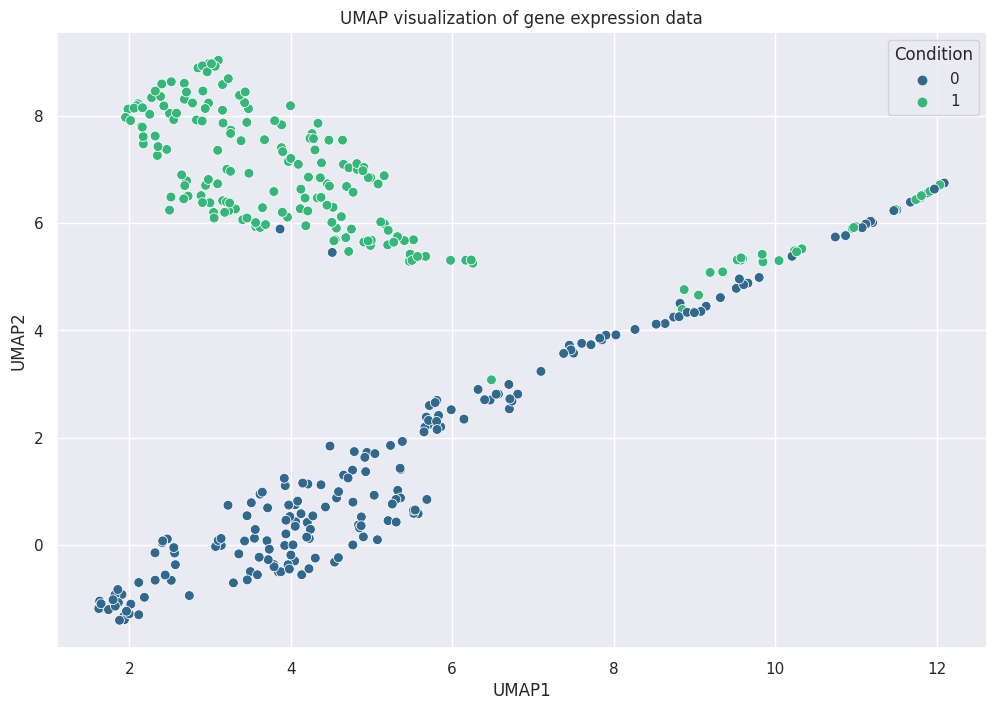

In [72]:
data = combined_data_binary.iloc[:, :-1]
labels = unf_condition["Condition"]
reducer = umap.umap_.UMAP(random_state = 69)
embedding = reducer.fit_transform(data)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette="viridis", s=50)
plt.title("UMAP visualization of gene expression data")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

In [73]:
# STRAIGHT LINE TO SEPARATE THE DATASET

def line(x):
    return 0.5 * x + 1

# Separate cells based on line
above_line = embedding[:, 1] > line(embedding[:, 0])
below_line = ~above_line

cells_above_line = labels[above_line]
cells_below_line = labels[below_line]

print("Cells above the line:", cells_above_line)
print("Cells below the line:", cells_below_line)

# CELLS
cells_above_line[cells_above_line.values == 0]
cells_below_line[cells_below_line.values == 1]

# INDICES 
umap_dead_above = []
umap_dead_below = []
umap_dead_cells = []
for i in cells_above_line[cells_above_line.values == 0].index:
    umap_dead_above.append(i)
    umap_dead_cells.append(i)

for i in cells_below_line[cells_below_line.values == 1].index:
    umap_dead_below.append(i)
    umap_dead_cells.append(i)

Cells above the line: "output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"     1
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"     1
"output.STAR.1_B10_Hypo_S76_Aligned.sortedByCoord.out.bam"     1
"output.STAR.1_B11_Hypo_S77_Aligned.sortedByCoord.out.bam"     1
"output.STAR.1_B12_Hypo_S78_Aligned.sortedByCoord.out.bam"     1
                                                              ..
"output.STAR.4_H14_Hypo_S383_Aligned.sortedByCoord.out.bam"    1
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam"     0
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam"     1
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam"     1
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam"     1
Name: Condition, Length: 163, dtype: int64
Cells below the line: "output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"    1
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"      0
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"      0
"outpu

In [74]:
umap_dead_cells = umap_dead_below

In [75]:
print(len(umap_dead_above),len(umap_dead_below) )

2 30


What we notice is that cells with the same label tend to cluster together but some anomalies are present. This makes us suspect the presence of dead cells or inaccurately handled data.

#### 2.2.1.1) ClusterMap

Subsequently, we utilize hierarchical clustering to gain insights into the similarities within the dataset. Our expectation is that outliers will form their own distinct cluster initially and merge with the rest of the data a the end.

In [76]:
#Standardize
df_std = (unf_smart_mc - unf_smart_mc.mean()) / (unf_smart_mc.std())

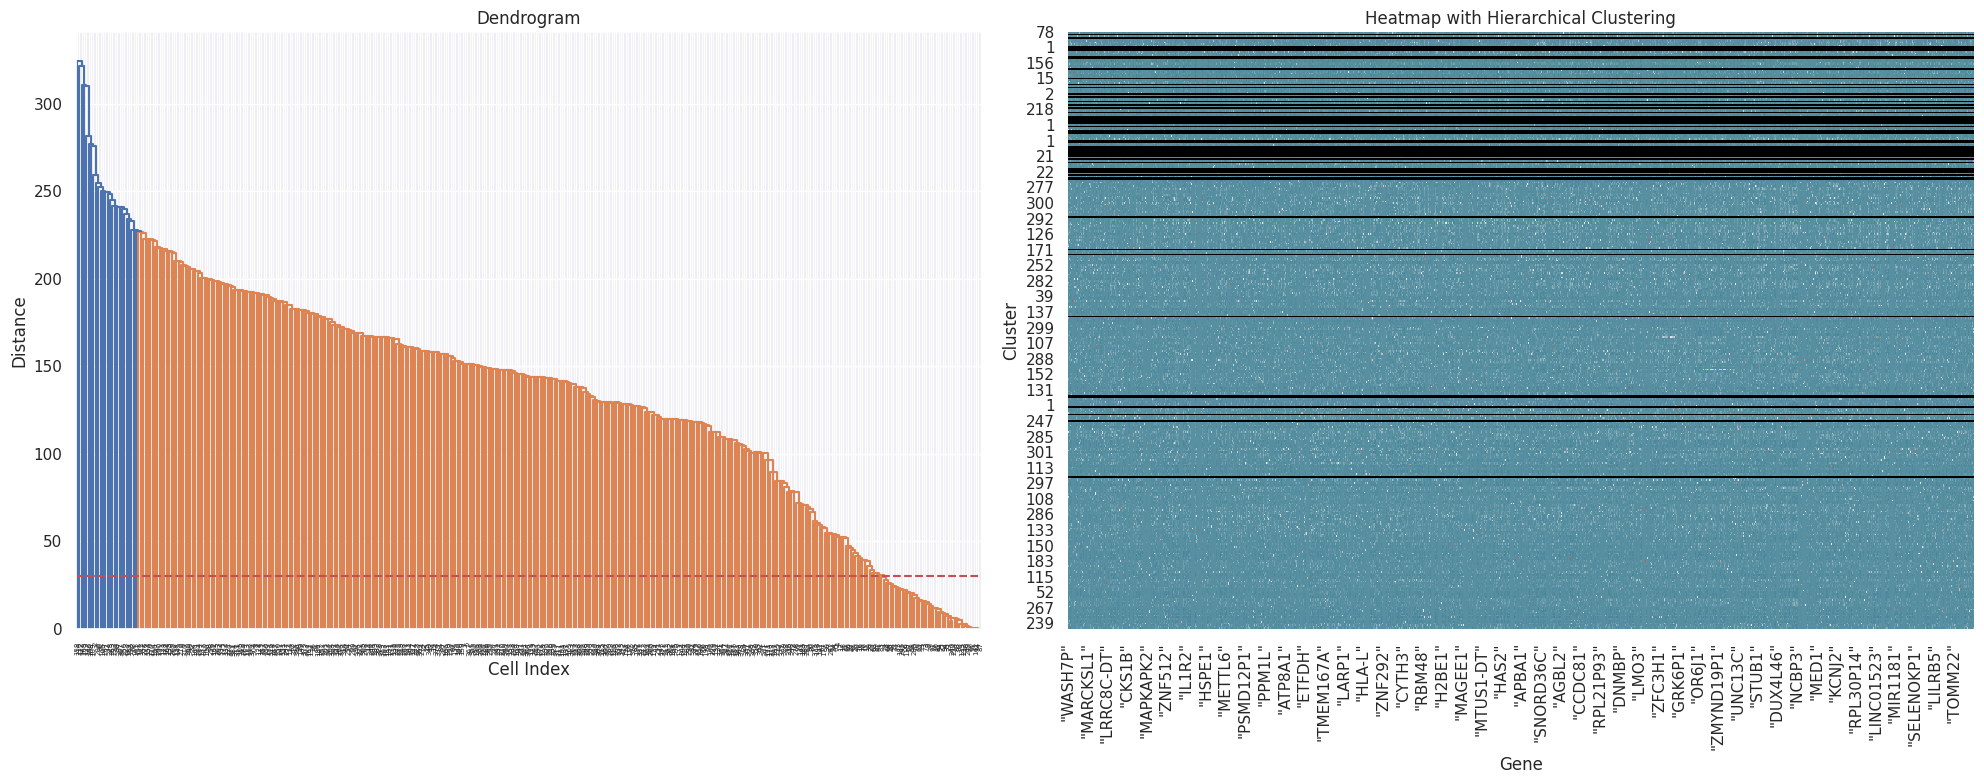

In [78]:
Z = linkage(df_std, method='centroid')

fig, axes = plt.subplots(1, 2, figsize=(20, 8)) 

# Dendrogram
dendrogram(Z, ax=axes[0])  
axes[0].axhline(y=30, color='r', linestyle='--') 
axes[0].set_title('Dendrogram')
axes[0].set_xlabel('Cell Index')
axes[0].set_ylabel('Distance')

cluster_labels = fcluster(Z, t=40, criterion='distance') 

vis_data = pd.DataFrame(df_std, columns=df_std.columns)
vis_data['Cluster'] = cluster_labels
vis_data.set_index('Cluster', inplace=True)

dead_cells_cluster =  1
cmap = sns.diverging_palette(220, 20, as_cmap=True)
cmap.set_bad('black')
mask = np.zeros_like(vis_data)
mask[vis_data.index == dead_cells_cluster] = True

# Heatmap
sns.heatmap(vis_data, cmap=cmap, mask=mask, cbar=False, ax=axes[1]) 
axes[1].set_title('Heatmap with Hierarchical Clustering')
axes[1].set_xlabel('Gene')
axes[1].set_ylabel('Cluster')

plt.tight_layout()

plt.show()

dead_cells_indices = np.where(cluster_labels == dead_cells_cluster)[0]
hierarch_dead_index = unf_smart_mc.iloc[dead_cells_indices].index

In [79]:
len(hierarch_dead_index)

52

#### 2.2.1.2) Ilary Method

As a third step, we introduce what we called the "Ilary method," which we have developed from scratch. This method leverages the unique attributes of housekeeping genes. These genes are commonly found in various cell types and typically exhibit stable expression levels. Consequently, cells displaying abnormally low expression levels of housekeeping genes are highly likely to be in a dormant or inactive state. By incorporating this approach into our analysis, we can identify and distinguish cells that may be in a non-functional state based on their deviant expression patterns of housekeeping genes.

In [80]:
# Get list of housekeepig genes
house_genes = pd.read_csv(r"/content/drive/MyDrive/AI LAB/DATA/Housekeeping_genes.txt",delimiter="\ ",engine='python',index_col=0)
ind = house_genes.index
ind2 = unf_smart_mc.T.index
ind = [f'"{i}"' for i in ind]

house_gene = list()
for i in ind2:
    for j in ind:
        if str(i) == j:
            house_gene.append(i)

COMMON HOUSEKEEPIG GENES
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoord.out.bam"    0.653114
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoord.out.bam"    0.000288
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoord.out.bam"    0.960510
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord.out.bam"      0.023080
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord.out.bam"      0.296676
                                                                ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoord.out.bam"    0.324123
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoord.out.bam"    1.022706
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoord.out.bam"    1.113328
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoord.out.bam"    1.312585
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoord.out.bam"    1.123246
Name: geometric_mean, Length: 383, dtype: float64

Threshold: 0.2029558987507013


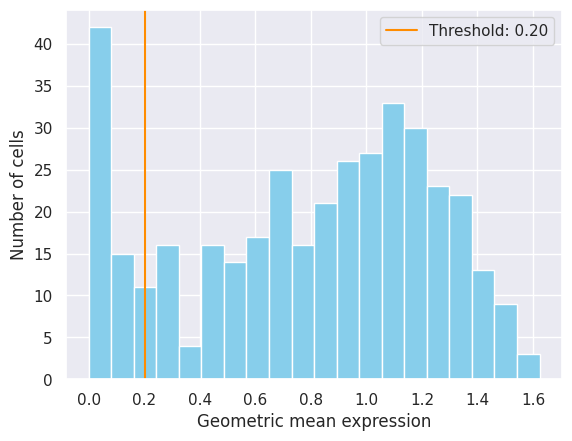

In [81]:
data_df = df_std 
data_norm_df = data_df- data_df.min() 

hk_genes_df = house_gene

common_genes = list(set(data_norm_df.columns).intersection(hk_genes_df))
print("COMMON HOUSEKEEPIG GENES")

common_df = data_norm_df[common_genes].copy()

common_df['geometric_mean'] = np.exp(np.log(common_df +1).mean(axis=1)) -1

print(common_df['geometric_mean'])
print()

plt.hist(common_df['geometric_mean'], bins=20,color='skyblue')
plt.xlabel('Geometric mean expression')
plt.ylabel('Number of cells')

threshold = max(common_df["geometric_mean"])* 0.125
print('Threshold:', threshold)

plt.axvline(threshold, color='darkorange', linestyle='-', label=f'Threshold: {threshold:.2f}')
plt.legend()
plt.show()


# Store the cells decleared to be dead according to the ILARY method
common_df_drop = common_df[common_df['geometric_mean'] > threshold]
common_df_drop
common_df_dead = common_df[common_df['geometric_mean'] <= threshold]
ilary_dead_cells = common_df_dead.index


In [82]:
len(ilary_dead_cells)

60

#### 2.2.1.3) Mitochondrial filtering

Lastly, we utilize the characteristics of genes in a dual approach: istead of looking for cells with very low gene expresion, we try to identify cells with overexpressed mitochondrial genes. This is because mitochondrial genes tend to exhibit high expression levels in instances of poor sample quality, indicating a substantial proportion of apoptotic or lysing cells. These cells may possess disrupted cellular membranes or be in a necrotic state. By focusing on the expression patterns of mitochondrial genes, we can effectively discern and flag cells that are likely to be compromised or in a deteriorating condition.

In [83]:
#Mt-filtering
mito_genes = np.array(unf_smart_mc.columns[unf_smart_mc.columns.str.find("MT-")!=-1])
print(mito_genes)
correct = []
for i, name in enumerate(mito_genes):
  if name[1] == "M":
    correct.append(i)
mito_genes = mito_genes[correct]
print(mito_genes)

['"INMT-MINDY4"' '"MT-TF"' '"MT-RNR1"' '"MT-TV"' '"MT-RNR2"' '"MT-TL1"'
 '"MT-ND1"' '"MT-TI"' '"MT-TQ"' '"MT-TM"' '"MT-ND2"' '"MT-TW"' '"MT-TA"'
 '"MT-TC"' '"MT-TY"' '"MT-CO1"' '"MT-TS1"' '"MT-TD"' '"MT-CO2"' '"MT-TK"'
 '"MT-ATP8"' '"MT-ATP6"' '"MT-CO3"' '"MT-TG"' '"MT-ND3"' '"MT-TR"'
 '"MT-ND4L"' '"MT-ND4"' '"MT-TH"' '"MT-TS2"' '"MT-TL2"' '"MT-ND5"'
 '"MT-ND6"' '"MT-TE"' '"MT-CYB"' '"MT-TT"' '"MT-TP"']
['"MT-TF"' '"MT-RNR1"' '"MT-TV"' '"MT-RNR2"' '"MT-TL1"' '"MT-ND1"'
 '"MT-TI"' '"MT-TQ"' '"MT-TM"' '"MT-ND2"' '"MT-TW"' '"MT-TA"' '"MT-TC"'
 '"MT-TY"' '"MT-CO1"' '"MT-TS1"' '"MT-TD"' '"MT-CO2"' '"MT-TK"'
 '"MT-ATP8"' '"MT-ATP6"' '"MT-CO3"' '"MT-TG"' '"MT-ND3"' '"MT-TR"'
 '"MT-ND4L"' '"MT-ND4"' '"MT-TH"' '"MT-TS2"' '"MT-TL2"' '"MT-ND5"'
 '"MT-ND6"' '"MT-TE"' '"MT-CYB"' '"MT-TT"' '"MT-TP"']


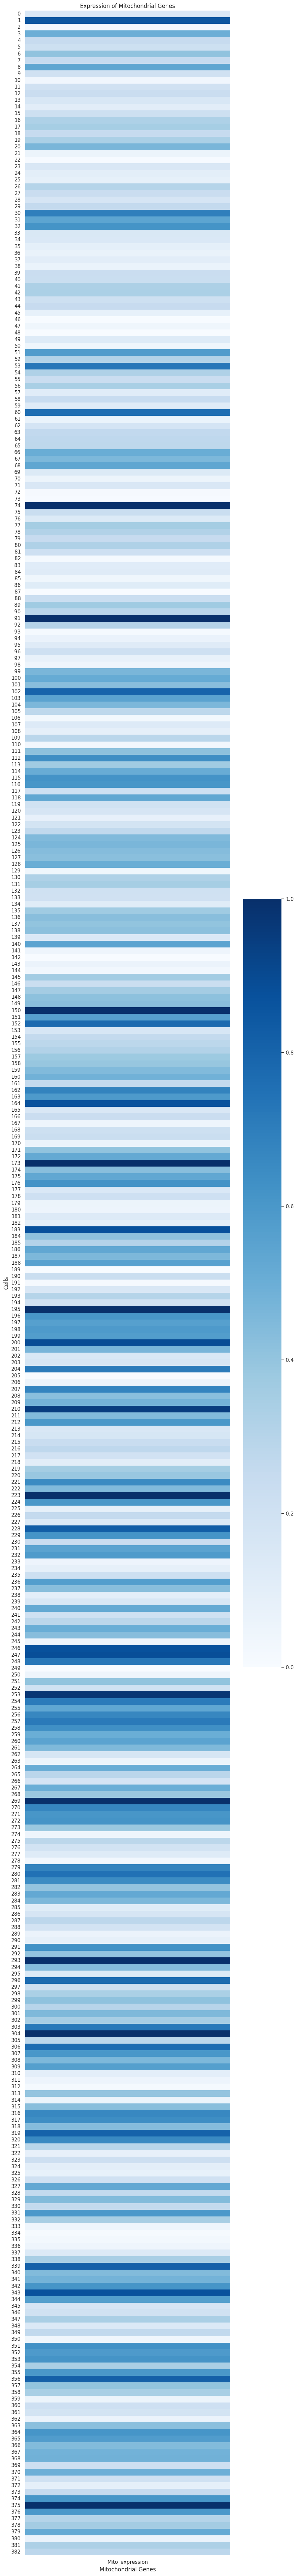

In [84]:
total_expression = unf_smart_mc.sum(axis=1)

mito_expression = unf_smart_mc[mito_genes].sum(axis=1)

percentage_mito_expression = mito_expression / total_expression *100

percentage_mito_expression = np.where(percentage_mito_expression > 5, 1, percentage_mito_expression / 5)

df_mito_expression = pd.DataFrame(percentage_mito_expression, columns=['Mito_expression'])

plt.figure(figsize=(10, 100))
sns.heatmap(df_mito_expression, cmap="Blues")
plt.title('Expression of Mitochondrial Genes')
plt.xlabel('Mitochondrial Genes')
plt.ylabel('Cells')
plt.show()

In [85]:
df_mito = unf_smart_mc.loc[:, mito_genes]
df_mito

"MT-TF"  "MT-RNR1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...        0         89   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...        0          1   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...        0         61   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...        0         11   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...        0         36   
...                                                     ...        ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...        0        132   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...        0        441   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...        0         41   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...        0        172   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...        0        230   

                                                    "MT-TV"  "MT-RNR2"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...        0       1036   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...        1          2   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...        0       1283   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...        0         70   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...        0        146   
...                                                     ...        ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...        0        578   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...        0       1916   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...        0       2026   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...        2       3708   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...        4       3047   

                                                    "MT-TL1"  "MT-ND1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         4        76   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0        10   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         0         7   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0        50   
...                                                      ...       ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         3       106   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         3       310   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1        48   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         5       372   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         4       236   

                                                    "MT-TI"  "MT-TQ"  "MT-TM"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...        0        0        0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...        0        0        0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...        0        0        0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...        0        0        0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...        0        0        0   
...                                                     ...      ...      ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...        0        0        0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...        0        0        0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...        1        1        2   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...        1        1        2   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...        1        1        2   

                                                    "MT-ND2"  ...  "MT-ND4"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...        52  ...      1720   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         1  ...         0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...        27  ...       287   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         9  ...        87   
"output.STAR.1_A2

In [86]:
total_count = unf_smart_mc.sum(axis=1)
fractional_mito = df_mito.sum(axis=1)/ total_count
fractional_mito.sort_values(ascending=False)

"output.STAR.3_G3_Norm_S303_Aligned.sortedByCoord.out.bam"     0.310338
"output.STAR.4_H2_Norm_S356_Aligned.sortedByCoord.out.bam"     0.251527
"output.STAR.4_A3_Norm_S21_Aligned.sortedByCoord.out.bam"      0.091158
"output.STAR.1_H5_Norm_S341_Aligned.sortedByCoord.out.bam"     0.090909
"output.STAR.1_G12_Hypo_S318_Aligned.sortedByCoord.out.bam"    0.076923
                                                                 ...   
"output.STAR.1_E10_Hypo_S220_Aligned.sortedByCoord.out.bam"    0.000027
"output.STAR.3_E7_Hypo_S229_Aligned.sortedByCoord.out.bam"     0.000000
"output.STAR.1_H1_Norm_S337_Aligned.sortedByCoord.out.bam"     0.000000
"output.STAR.2_D8_Hypo_S176_Aligned.sortedByCoord.out.bam"     0.000000
"output.STAR.1_D8_Hypo_S170_Aligned.sortedByCoord.out.bam"     0.000000
Length: 383, dtype: float64

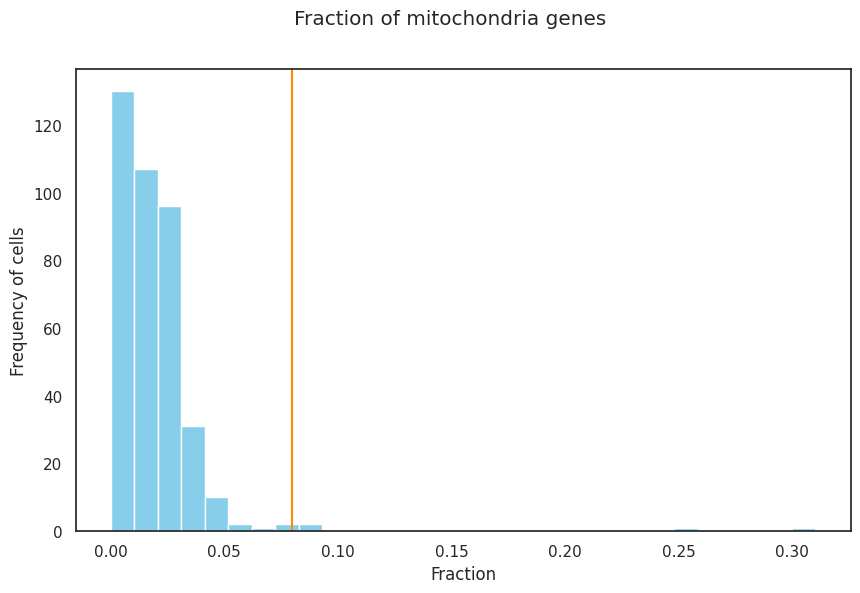

In [87]:
fig = plt.figure(figsize=(10, 6))
sns.set_style("white")

ax1 = plt.axes()
ax1.hist(fractional_mito, bins = 30,color='skyblue')

# Labels
fig.suptitle("Fraction of mitochondria genes")
ax1.set_xlabel("Fraction")
ax1.set_ylabel("Frequency of cells");

high_threshold_mytho = 0.08
plt.axvline(high_threshold_mytho, color='darkorange', linestyle='-', label=f'Threshold: {threshold:.2f}')

sns.set_theme()

In [88]:
mytho_mask = (fractional_mito > high_threshold_mytho)

broken_membrane = (mytho_mask)
broken_membrane_cells = unf_smart_mc[broken_membrane].index


In [89]:
len(broken_membrane_cells)

4

#### 2.2.1.4) Dead cells removal

Finally, we combine the results obtained with the above methods to create a dataset without compromised cells.

In [90]:
umap_dead_cells = np.array(umap_dead_cells)
hierarch_dead_index = np.array(hierarch_dead_index)
ilary_dead_cells = np.array(ilary_dead_cells)
broken_membrane_cells = np.array(broken_membrane_cells)

inter_umap_hier = np.intersect1d(umap_dead_cells, hierarch_dead_index)
inter_umap_ilary= np.intersect1d(umap_dead_cells, ilary_dead_cells)
inter_umap_mito = np.intersect1d(umap_dead_cells, broken_membrane_cells)

inter_hier_ilary = np.intersect1d( hierarch_dead_index, ilary_dead_cells)
inter_hier_mito = np.intersect1d( hierarch_dead_index, broken_membrane_cells)

inter_ilary_mito = np.intersect1d( ilary_dead_cells,broken_membrane_cells)


union_cells = np.union1d(ilary_dead_cells, hierarch_dead_index)
union_cells = np.union1d(union_cells, broken_membrane_cells)

In [91]:
print("inter_umap_hier:", len(inter_umap_hier))
print("inter_umap_ilary:", len(inter_umap_ilary))
print("inter_umap_mito:", len(inter_umap_mito))
print("inter_hier_ilary:", len(inter_hier_ilary))
print("inter_hier_mito:", len(inter_hier_mito))
print("inter_ilary_mito:", len(inter_ilary_mito))


inter_umap_hier: 26
inter_umap_ilary: 28
inter_umap_mito: 0
inter_hier_ilary: 52
inter_hier_mito: 1
inter_ilary_mito: 1


In [92]:
len(union_cells)

63

Remove the union from the original dataset

In [93]:
union_list = union_cells.tolist()
unf_smart_mc_clean = unf_smart_mc.drop(union_list)

In [94]:
unf_smart_mc_clean.shape

(320, 22905)

### 2.2.2) Doublets

Multiplets of two cells in scRNA-seq data go under the name of doublets. These can hinder identification of discrete or transitional cell populations and associated marker genes. Detecting and removing these doublets is crucial for accurate analysis. However, no method for doublet detection is perfect and will invariably produce some false positives and false negatives. To find these type of cells we will use a built-in library called scrublet.


We claim that doublets are characterized by particularly high total gene expression. Consequently, the simulated doublets we generate for detection purposes should mirror this characteristic and exhibit high gene expression levels. To achieve this, we'll construct our simulated doublets from data subset where the gene expression surpasses a certain threshold, ensuring the identification of corresponding actual doublets in our dataset.

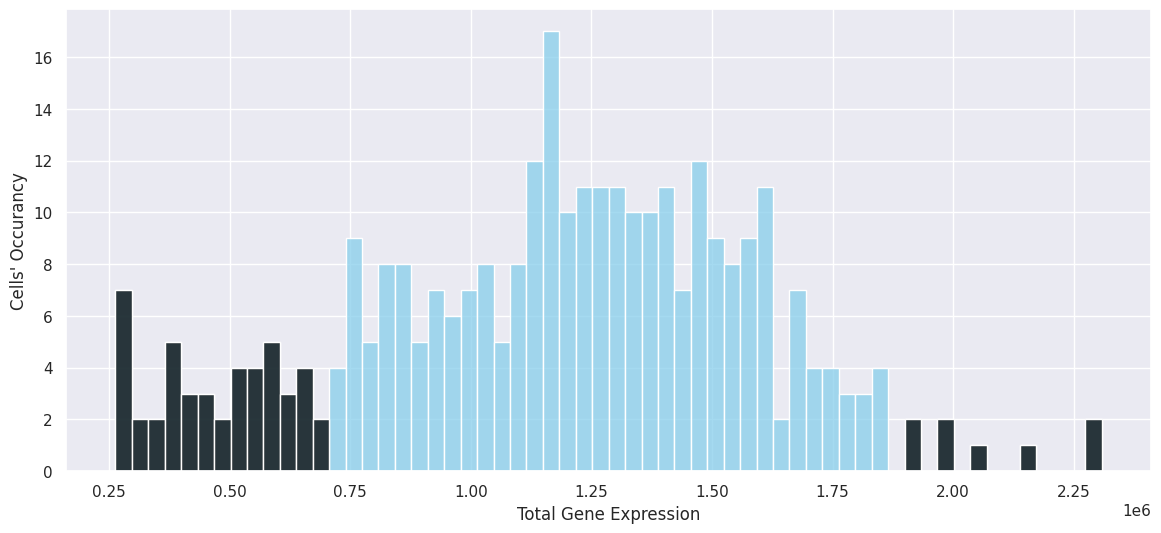

In [95]:
total_counts = unf_smart_mc_clean.T.sum(axis=0)

fig, ax = plt.subplots(figsize=(14, 6))
sns.set_style("white")
sns.histplot(total_counts, bins=60, ax=ax, color='skyblue')

low_threshold_reads =720000
high_threshold_reads = 1870000

outliers = (total_counts < low_threshold_reads) | (total_counts > high_threshold_reads)
sns.histplot(total_counts[outliers], bins=60, ax=ax, color='black')

ax.set_xlabel("Total Gene Expression")
ax.set_ylabel("Cells' Occurancy")

plt.show()

The cells above the threshold are presumably doublets.

In [96]:
regular_counts_indices = np.where(unf_smart_mc_clean.sum(axis=1) > low_threshold_reads)[0]

regular_counts = unf_smart_mc.iloc[regular_counts_indices, :]


In [97]:
regular_counts

"WASH7P"  "MIR6859-1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         0            0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0            0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...         0            0   
...                                                      ...          ...   
"output.STAR.4_C11_Hypo_S143_Aligned.sortedByCo...         0            0   
"output.STAR.4_C2_Norm_S116_Aligned.sortedByCoo...         0            0   
"output.STAR.4_C3_Norm_S117_Aligned.sortedByCoo...         0            0   
"output.STAR.4_C4_Norm_S118_Aligned.sortedByCoo...         0            0   
"output.STAR.4_C5_Norm_S119_Aligned.sortedByCoo...         0            0   

                                                    "WASH9P"  "OR4F29"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         1         0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...         0         0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0         0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...         1         0   
...                                                      ...       ...   
"output.STAR.4_C11_Hypo_S143_Aligned.sortedByCo...         3         0   
"output.STAR.4_C2_Norm_S116_Aligned.sortedByCoo...         0         0   
"output.STAR.4_C3_Norm_S117_Aligned.sortedByCoo...         0         0   
"output.STAR.4_C4_Norm_S118_Aligned.sortedByCoo...         3         0   
"output.STAR.4_C5_Norm_S119_Aligned.sortedByCoo...         0         0   

                                                    "MTND1P23"  "MTND2P28"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0           2   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           0           1   
...                                                        ...         ...   
"output.STAR.4_C11_Hypo_S143_Aligned.sortedByCo...           1          12   
"output.STAR.4_C2_Norm_S116_Aligned.sortedByCoo...           0           6   
"output.STAR.4_C3_Norm_S117_Aligned.sortedByCoo...           0          27   
"output.STAR.4_C4_Norm_S118_Aligned.sortedByCoo...           0          20   
"output.STAR.4_C5_Norm_S119_Aligned.sortedByCoo...           0          22   

                                                    "MTCO1P12"  "MTCO2P12"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           2           0   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           3           0   
...                                                        ...         ...   
"output.STAR.4_C11_Hypo_S143_Aligned.sortedByCo...           3           0   
"output.STAR.4_C2_Norm_S116_Aligned.sortedByCoo...          14           2   
"output.STAR.4_C3_Norm_S117_Aligned.sortedByCoo...          10           2   
"output.STAR.4_C4_Norm_S118_Aligned.sortedByCoo...           4           0   
"output.STAR.4_C5_Norm_S119_Aligned.sortedByCoo...          16           1   

                                                    "MTATP8P1"  "MTATP6P1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0          29   
"output.STAR.1_A11_Hypo_S29_Aligned.sortedByCoo...           0           0   
"output.STAR.1_A1_Norm_S1_Aligned.sortedByCoord...           0           7   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...  

In [98]:
scrub_regular_counts = scr.Scrublet(regular_counts, expected_doublet_rate=0.1)
doublet_scores_regular_counts, predicted_doublets_regular_counts = scrub_regular_counts.scrub_doublets()


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 15.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 1.1 seconds


Initially, Scrublet detected a mere 15.5% of doublets in our scRNA-seq data. To improve this, we utilized Optuna for hyperparameter tuning of Scrublet, adjusting parameters like 'min_counts', 'min_cells', 'min_gene_variability_pctl', and 'n_prin_comps' across 100 trials. Our goal is to augment this low initial doublet detection rate.

In [99]:
def objective(trial):

    min_counts = trial.suggest_int('min_counts', 2, 5)
    min_cells = trial.suggest_int('min_cells', 3, 5)
    min_gene_variability_pctl = trial.suggest_int('min_gene_variability_pctl', 50, 85)
    n_prin_comps = trial.suggest_int('n_prin_comps', 10, 30)

    scrub = scr.Scrublet(regular_counts, expected_doublet_rate=0.1)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(min_counts=min_counts, 
                                                              min_cells=min_cells, 
                                                              min_gene_variability_pctl=min_gene_variability_pctl, 
                                                              n_prin_comps=n_prin_comps)
    scrub.detected_doublet_rate_
    return scrub.detected_doublet_rate_

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_value = study.best_value
print(f"Best parameters: {best_params}")
print(f"Best objective value: {best_value}")


[I 2023-06-08 20:24:45,960] A new study created in memory with name: no-name-dbae3fc7-c354-4c54-80c1-ca7f04583430


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:24:48,091] Trial 0 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 58, 'n_prin_comps': 30}. Best is trial 0 with value: 0.0072992700729927005.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.5%
Elapsed time: 1.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:24:49,832] Trial 1 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 56, 'n_prin_comps': 11}. Best is trial 0 with value: 0.0072992700729927005.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 17.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.1%
Elapsed time: 1.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:24:52,671] Trial 2 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 4, 'min_cells': 3, 'min_gene_variability_pctl': 58, 'n_prin_comps': 28}. Best is trial 0 with value: 0.0072992700729927005.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.2%
Elapsed time: 2.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:24:54,233] Trial 3 finished with value: 0.014598540145985401 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 80, 'n_prin_comps': 18}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 16.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.9%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:24:56,384] Trial 4 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 4, 'min_cells': 4, 'min_gene_variability_pctl': 66, 'n_prin_comps': 17}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 1.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:24:58,080] Trial 5 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 4, 'min_cells': 3, 'min_gene_variability_pctl': 62, 'n_prin_comps': 18}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 16.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 1.3 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:00,478] Trial 6 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 4, 'min_gene_variability_pctl': 53, 'n_prin_comps': 30}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.2%
Elapsed time: 2.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:02,572] Trial 7 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 4, 'min_gene_variability_pctl': 60, 'n_prin_comps': 25}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.2%
Elapsed time: 1.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:03,754] Trial 8 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 3, 'min_gene_variability_pctl': 80, 'n_prin_comps': 20}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 18.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.1%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:06,090] Trial 9 finished with value: 0.014598540145985401 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 57, 'n_prin_comps': 25}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 17.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.4%
Elapsed time: 2.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:07,617] Trial 10 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 11}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.1%
Elapsed time: 0.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:10,521] Trial 11 finished with value: 0.010948905109489052 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 76, 'n_prin_comps': 24}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.8%
Elapsed time: 2.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:12,139] Trial 12 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 72, 'n_prin_comps': 15}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:14,398] Trial 13 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 50, 'n_prin_comps': 23}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 19.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 1.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:16,024] Trial 14 finished with value: 0.010948905109489052 and parameters: {'min_counts': 4, 'min_cells': 5, 'min_gene_variability_pctl': 68, 'n_prin_comps': 21}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 16.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.5%
Elapsed time: 1.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:17,536] Trial 15 finished with value: 0.014598540145985401 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 74, 'n_prin_comps': 26}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.0%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:18,685] Trial 16 finished with value: 0.014598540145985401 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 84, 'n_prin_comps': 14}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.6%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:20,565] Trial 17 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 66, 'n_prin_comps': 21}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 18.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.0%
Elapsed time: 1.5 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:22,042] Trial 18 finished with value: 0.010948905109489052 and parameters: {'min_counts': 4, 'min_cells': 5, 'min_gene_variability_pctl': 79, 'n_prin_comps': 18}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 16.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.7%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:24,273] Trial 19 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 3, 'min_cells': 4, 'min_gene_variability_pctl': 70, 'n_prin_comps': 27}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 1.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:26,266] Trial 20 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 64, 'n_prin_comps': 23}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 17.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.1%
Elapsed time: 1.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:27,760] Trial 21 finished with value: 0.014598540145985401 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 74, 'n_prin_comps': 26}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.0%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:29,015] Trial 22 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 78, 'n_prin_comps': 28}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 17.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.1%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:25:30,280] Trial 23 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 82, 'n_prin_comps': 23}. Best is trial 3 with value: 0.014598540145985401.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 16.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:32,383] Trial 24 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 75, 'n_prin_comps': 15}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 14.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.9%
Elapsed time: 1.3 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:34,592] Trial 25 finished with value: 0.010948905109489052 and parameters: {'min_counts': 3, 'min_cells': 4, 'min_gene_variability_pctl': 71, 'n_prin_comps': 25}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.8%
Elapsed time: 1.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:25:37,417] Trial 26 finished with value: 0.010948905109489052 and parameters: {'min_counts': 4, 'min_cells': 5, 'min_gene_variability_pctl': 76, 'n_prin_comps': 21}. Best is trial 3 with value: 0.014598540145985401.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 2.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 15.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.7%
Elapsed time: 2.1 seconds


[I 2023-06-08 20:25:40,715] Trial 27 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 81, 'n_prin_comps': 28}. Best is trial 3 with value: 0.014598540145985401.


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:43,290] Trial 28 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 3, 'min_cells': 4, 'min_gene_variability_pctl': 69, 'n_prin_comps': 19}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.1%
Elapsed time: 1.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:45,579] Trial 29 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 73, 'n_prin_comps': 30}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 1.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:47,398] Trial 30 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 78, 'n_prin_comps': 13}. Best is trial 3 with value: 0.014598540145985401.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 18.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.9%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:25:49,163] Trial 31 finished with value: 0.01824817518248175 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 84, 'n_prin_comps': 15}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.2%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:25:50,511] Trial 32 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 85, 'n_prin_comps': 16}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.4%
Elapsed time: 0.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:25:52,872] Trial 33 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 82, 'n_prin_comps': 13}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 18.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.9%
Elapsed time: 1.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:25:59,118] Trial 34 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 3, 'min_gene_variability_pctl': 53, 'n_prin_comps': 16}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.3%
Elapsed time: 4.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 16.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 2.4 seconds


[I 2023-06-08 20:26:02,112] Trial 35 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 3, 'min_cells': 4, 'min_gene_variability_pctl': 58, 'n_prin_comps': 19}. Best is trial 31 with value: 0.01824817518248175.


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...

[I 2023-06-08 20:26:03,708] Trial 36 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 4, 'min_cells': 4, 'min_gene_variability_pctl': 83, 'n_prin_comps': 11}. Best is trial 31 with value: 0.01824817518248175.



Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 17.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:05,565] Trial 37 finished with value: 0.014598540145985401 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 77, 'n_prin_comps': 17}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 17.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 8.5%
Elapsed time: 1.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 15.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.7%
Elapsed time: 4.4 seconds


[I 2023-06-08 20:26:11,742] Trial 38 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 4, 'min_cells': 4, 'min_gene_variability_pctl': 80, 'n_prin_comps': 26}. Best is trial 31 with value: 0.01824817518248175.


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:14,816] Trial 39 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 3, 'min_cells': 3, 'min_gene_variability_pctl': 63, 'n_prin_comps': 29}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 2.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:18,009] Trial 40 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 60, 'n_prin_comps': 22}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 18.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.0%
Elapsed time: 2.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:19,147] Trial 41 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 83, 'n_prin_comps': 14}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.3%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:20,198] Trial 42 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 85, 'n_prin_comps': 10}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.5%
Elapsed time: 0.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:26:21,380] Trial 43 finished with value: 0.014598540145985401 and parameters: {'min_counts': 2, 'min_cells': 3, 'min_gene_variability_pctl': 80, 'n_prin_comps': 14}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 19.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.5%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:22,640] Trial 44 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 84, 'n_prin_comps': 18}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 15.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.9%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:26:24,137] Trial 45 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 81, 'n_prin_comps': 12}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 19.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.7%
Elapsed time: 0.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:26,989] Trial 46 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 50, 'n_prin_comps': 16}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 17.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.1%
Elapsed time: 2.3 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:28,808] Trial 47 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 55, 'n_prin_comps': 15}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.3%
Elapsed time: 1.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:30,407] Trial 48 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 66, 'n_prin_comps': 17}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.3%
Elapsed time: 1.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:31,729] Trial 49 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 4, 'min_cells': 5, 'min_gene_variability_pctl': 78, 'n_prin_comps': 25}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 15.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.7%
Elapsed time: 0.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:32,824] Trial 50 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 85, 'n_prin_comps': 19}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 15.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.9%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:34,242] Trial 51 finished with value: 0.014598540145985401 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 74, 'n_prin_comps': 26}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.0%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:35,740] Trial 52 finished with value: 0.014598540145985401 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 72, 'n_prin_comps': 26}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 15.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.5%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:37,310] Trial 53 finished with value: 0.014598540145985401 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 74, 'n_prin_comps': 24}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.1%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:39,309] Trial 54 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 4, 'min_cells': 5, 'min_gene_variability_pctl': 76, 'n_prin_comps': 27}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 15.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.3%
Elapsed time: 1.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:40,920] Trial 55 finished with value: 0.0 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 83, 'n_prin_comps': 29}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 15.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:26:42,333] Trial 56 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 79, 'n_prin_comps': 24}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 17.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.1%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:43,886] Trial 57 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 68, 'n_prin_comps': 22}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:45,519] Trial 58 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 3, 'min_cells': 5, 'min_gene_variability_pctl': 70, 'n_prin_comps': 27}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 17.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.1%
Elapsed time: 1.2 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:26:46,704] Trial 59 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 81, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:48,708] Trial 60 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 4, 'min_cells': 4, 'min_gene_variability_pctl': 61, 'n_prin_comps': 25}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 18.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.0%
Elapsed time: 1.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:50,141] Trial 61 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 75, 'n_prin_comps': 17}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.5%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:51,421] Trial 62 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 78, 'n_prin_comps': 17}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 15.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.1%
Elapsed time: 0.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:53,042] Trial 63 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 77, 'n_prin_comps': 15}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 15.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.0%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:26:54,549] Trial 64 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 82, 'n_prin_comps': 14}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 18.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.8%
Elapsed time: 0.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:26:56,566] Trial 65 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 72, 'n_prin_comps': 18}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 16.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.2%
Elapsed time: 1.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:26:57,825] Trial 66 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 3, 'min_cells': 4, 'min_gene_variability_pctl': 77, 'n_prin_comps': 13}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 19.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.8%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:26:59,019] Trial 67 finished with value: 0.010948905109489052 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 79, 'n_prin_comps': 16}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.5%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:00,097] Trial 68 finished with value: 0.01824817518248175 and parameters: {'min_counts': 2, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 16.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 11.1%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:01,234] Trial 69 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:02,512] Trial 70 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 0.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:03,807] Trial 71 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:04,970] Trial 72 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:07,192] Trial 73 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 1.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:08,768] Trial 74 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:10,459] Trial 75 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:11,821] Trial 76 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 83, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 16.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.4%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:12,920] Trial 77 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 85, 'n_prin_comps': 21}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.7%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:14,061] Trial 78 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 81, 'n_prin_comps': 19}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 17.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.2%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:15,184] Trial 79 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 22}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 16.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.5%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:16,290] Trial 80 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 82, 'n_prin_comps': 21}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.36
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.5%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:17,348] Trial 81 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 0.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:18,420] Trial 82 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 19}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 15.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.1%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:19,574] Trial 83 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 85, 'n_prin_comps': 21}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 16.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.7%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:20,738] Trial 84 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 82, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.5%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.2%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:22,145] Trial 85 finished with value: 0.0036496350364963502 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 83, 'n_prin_comps': 22}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.4%
Estimated detectable doublet fraction = 15.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 2.3%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:23,640] Trial 86 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 85, 'n_prin_comps': 18}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 14.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.7%
Elapsed time: 0.9 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:25,920] Trial 87 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 80, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 18.4%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.9%
Elapsed time: 1.4 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:27,298] Trial 88 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 83, 'n_prin_comps': 19}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 15.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.2%
Elapsed time: 0.8 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:27:28,438] Trial 89 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 81, 'n_prin_comps': 21}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 18.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.9%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:29,574] Trial 90 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 83, 'n_prin_comps': 23}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.5%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:30,730] Trial 91 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:31,847] Trial 92 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:33,003] Trial 93 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 82, 'n_prin_comps': 19}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 15.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.7%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:34,057] Trial 94 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 85, 'n_prin_comps': 18}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 14.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 7.7%
Elapsed time: 0.6 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:35,152] Trial 95 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 21}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.4%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...


[I 2023-06-08 20:27:36,300] Trial 96 finished with value: 0.010948905109489052 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 80, 'n_prin_comps': 19}. Best is trial 31 with value: 0.01824817518248175.


Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.1%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 6.5%
Elapsed time: 0.7 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:37,783] Trial 97 finished with value: 0.014598540145985401 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 82, 'n_prin_comps': 22}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.5%
Estimated detectable doublet fraction = 16.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 9.1%
Elapsed time: 1.1 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:39,392] Trial 98 finished with value: 0.01824817518248175 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 84, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 1.8%
Estimated detectable doublet fraction = 17.0%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 10.8%
Elapsed time: 1.0 seconds
Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...


[I 2023-06-08 20:27:41,006] Trial 99 finished with value: 0.0072992700729927005 and parameters: {'min_counts': 5, 'min_cells': 5, 'min_gene_variability_pctl': 83, 'n_prin_comps': 20}. Best is trial 31 with value: 0.01824817518248175.


Calculating doublet scores...
Automatically set threshold at doublet score = 0.35
Detected doublet rate = 0.7%
Estimated detectable doublet fraction = 16.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 4.4%
Elapsed time: 1.0 seconds
Best parameters: {'min_counts': 2, 'min_cells': 4, 'min_gene_variability_pctl': 84, 'n_prin_comps': 15}
Best objective value: 0.01824817518248175


Last output was collapsed because interrupting the flow of presentation, the chosen values are used in the next code cell.

In [100]:
scrub_regular_counts = scr.Scrublet(regular_counts, expected_doublet_rate=0.1)
doublet_scores_regular_counts, predicted_doublets_regular_counts = scrub_regular_counts.scrub_doublets(
    min_counts= 3, min_cells= 4, min_gene_variability_pctl= 82, n_prin_comps= 18)


Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.34
Detected doublet rate = 2.2%
Estimated detectable doublet fraction = 15.3%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.3%
Elapsed time: 0.7 seconds


Unfortunately, even if we used tuned parameters,the detected doublets percentage with respect to estimated doublets is still too low to determine that the cells chosen by the method are unequivocally doublets.

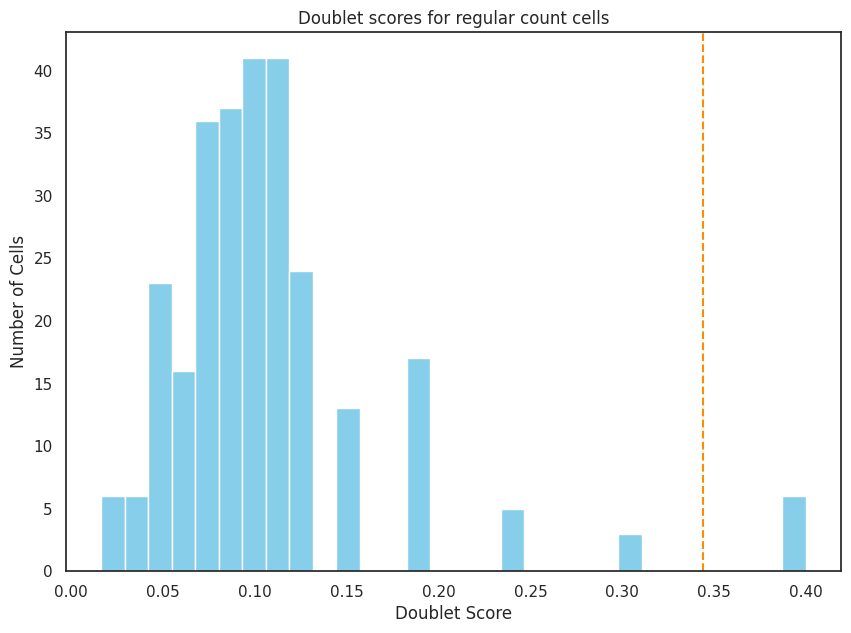

In [101]:
plt.figure(figsize=(10, 7))
plt.hist(doublet_scores_regular_counts, bins=30, color='skyblue')
plt.axvline(x=scrub_regular_counts.threshold_, color='darkorange', linestyle='dashed')
plt.title('Doublet scores for regular count cells')
plt.xlabel('Doublet Score')
plt.ylabel('Number of Cells')
plt.show()


In [102]:
doublet_indices = np.where(predicted_doublets_regular_counts)[0]
unf_smart_mc_clean_no_doublets = unf_smart_mc_clean.drop(unf_smart_mc_clean.index[doublet_indices])


In [103]:
doublet_indices = unf_smart_mc_clean.index[doublet_indices]
selected_cells = unf_smart_mc_clean.loc[doublet_indices]

In [ ]:
print('Doublets names:', doublet_indices)

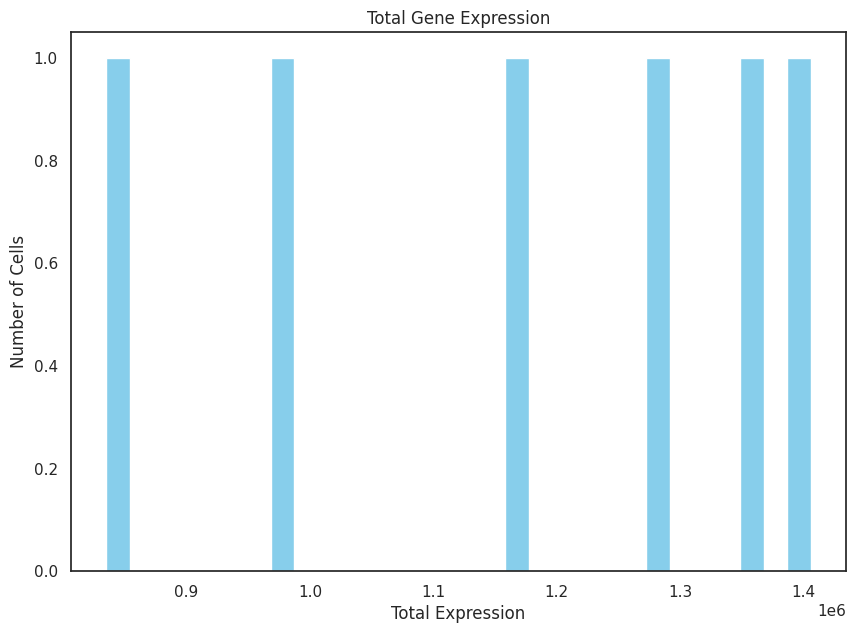

In [105]:
total_gene_expression = selected_cells.sum(axis=1)

plt.figure(figsize=(10, 7))
plt.hist(total_gene_expression, bins=30, color='skyblue')
plt.title('Total Gene Expression')
plt.xlabel('Total Expression')
plt.ylabel('Number of Cells')
plt.show()


After applying Scrublet to our scRNA-seq data, we noticed a minor presence of potential doublets. These, however, exhibit only average gene expression, indicating that Scrublet might not have effectively identified any substantial or relevant doublets in our dataset.


We can explain this underperformance of Scrublet in detecting doublets due to the nature of our Smart-seq dataset, a method less prone to doublet formation compared to droplet-based techniques. Consequently, our results likely reflect this lower doublet rate, rather than an issue with Scrublet. Hence, we opt to retain these data points to prevent loss of valuable biological signals.

In [107]:
unf_condition=unf_smart_mc_clean.index.to_series().apply(lambda x: extract_condition(x))
unf_condition.name = "Condition"
unf_condition = pd.DataFrame(unf_condition)

In [106]:
unf_smart_mc_clean

"WASH7P"  "MIR6859-1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0            0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0            0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...         0            0   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...         0            0   
...                                                      ...          ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1            0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         0            0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         1            0   

                                                    "WASH9P"  "OR4F29"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         1         0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0         0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...         1         0   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...        10         0   
...                                                      ...       ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0         0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         1         0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1         0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         4         1   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         5         0   

                                                    "MTND1P23"  "MTND2P28"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0           2   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0           1   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           0           1   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...           0           3   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           0           2   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           7   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           0          29   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           0           5   

                                                    "MTCO1P12"  "MTCO2P12"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           2           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           1           1   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           3           0   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...          10           1   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           1           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           5           5   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           4           0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           3           0   

                                                    "MTATP8P1"  "MTATP6P1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0          29   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0          12   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0          68   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...  

## 2.3) Genes Inspection

### 2.3.0) Interquantile range approach

The method employed for outlier removal relies on the assumption that the data follows a symmetric distribution. However, it is important to note that solely relying on the interquartile range (IQR) to remove outliers may inadvertently exclude valid data points that are legitimately extreme. Outliers can occasionally contain valuable information or represent genuine phenomena within the data. Indiscriminately discarding these points may lead to the loss of crucial insights or patterns. Therefore, a careful and nuanced approach is required when deciding whether to remove outliers from the analysis.

### 2.3.1) Understanding and tackling sparsity

Sparsity aids in feature interpretability, facilitates feature selection, and helps control model complexity. By handling sparsity, you can improve model performance, prevent overfitting, and enhance generalization.

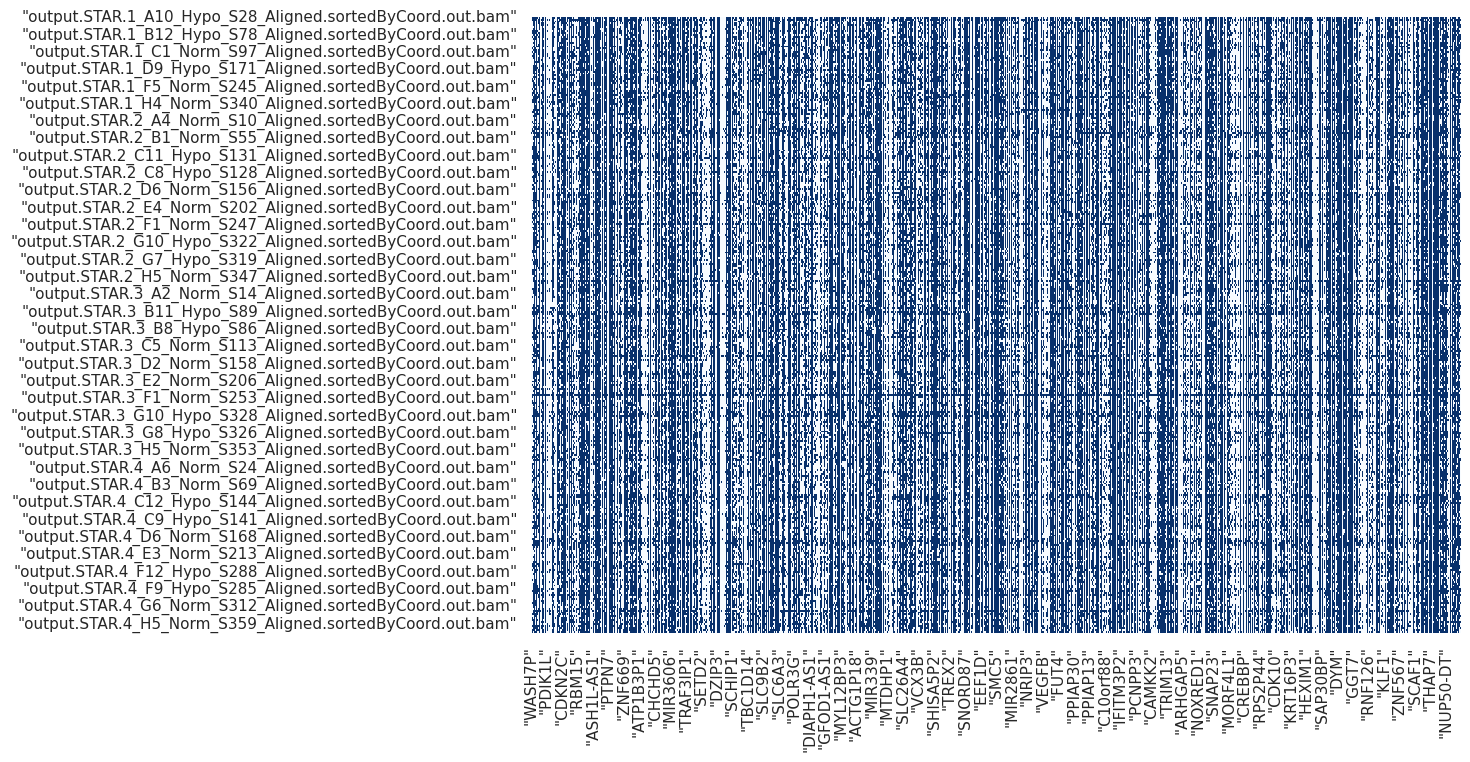

In [108]:
zeros = unf_smart_mc_clean == 0

plt.figure(figsize=(12, 8))
sns.heatmap(zeros, cbar=False, cmap='Blues')
plt.show()

Overall sparsity level: 0.5629338572364113


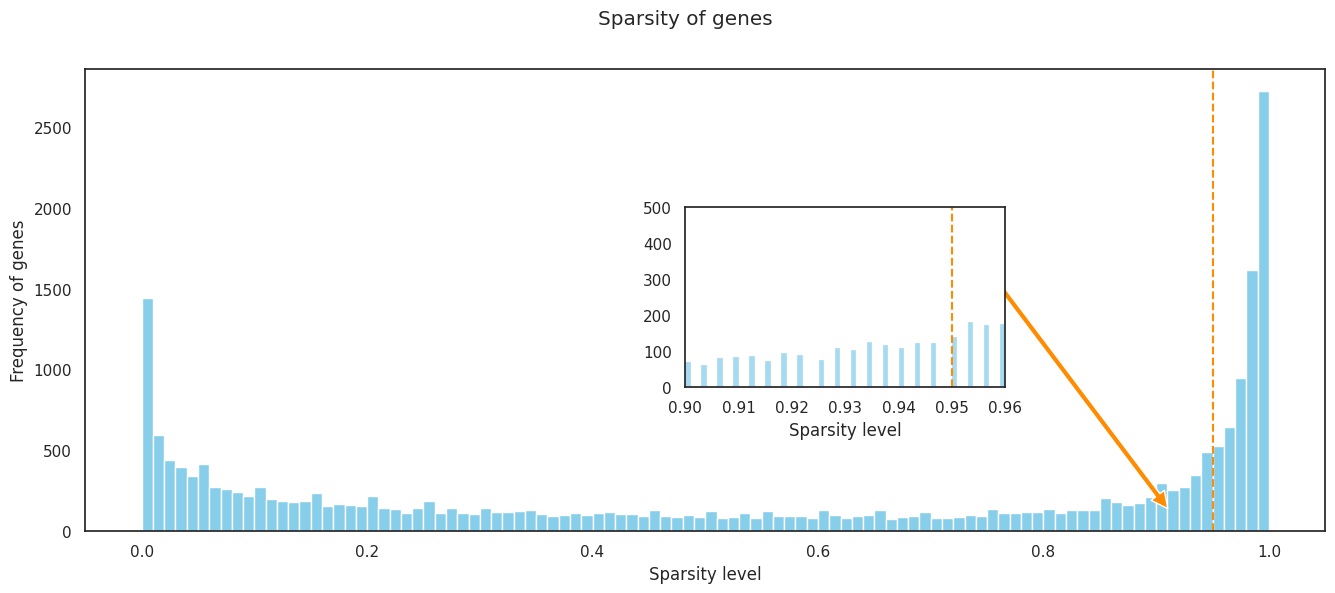

In [109]:
sparsity_threshold = 0.95

overall_sparsity = (unf_smart_mc_clean == 0).sum().sum() / unf_smart_mc_clean.size
print(f"Overall sparsity level: {overall_sparsity}")

sparsity_genes = (unf_smart_mc_clean == 0).sum(axis=0) / unf_smart_mc_clean.shape[0]

fig, ax = plt.subplots(figsize=(16, 6))
sns.set_style("white")
bars = ax.hist(sparsity_genes, bins=100, color='skyblue')
fig.suptitle("Sparsity of genes")
ax.set_xlabel("Sparsity level")
ax.set_ylabel("Frequency of genes")
ax.axvline(sparsity_threshold, color='darkorange', linestyle='dashed')

# Zoomed subplot
high_sparsity_genes = sparsity_genes[sparsity_genes >= 0.90]
ax2 = plt.axes([0.5, 0.35, 0.2, 0.3]) 
bins = np.histogram_bin_edges(high_sparsity_genes , bins=100)
sns.histplot(high_sparsity_genes, bins=bins, ax=ax2, color='skyblue') 
ax2.set_ylim(0, 500) 
ax2.set_xlim(0.9, 0.96)
ax2.set_xlabel('Sparsity level')
ax2.set_ylabel('')
ax2.axvline(sparsity_threshold, color='darkorange', linestyle='dashed')

ax.annotate('', xy=(0.92, 50), xytext=(0.6, 0.6), textcoords='figure fraction',
            arrowprops=dict(facecolor='darkorange', shrink=0.05))

sns.set_theme()

plt.show()

Removing Dead cells overall sparsity level,has been reduced by 0.04, however we will remove the genes with sparsity higher than 95%

In [110]:
unf_smart_mc_clean = unf_smart_mc_clean.loc[:, sparsity_genes <= sparsity_threshold]

Overall sparsity level: 0.3980070618462661


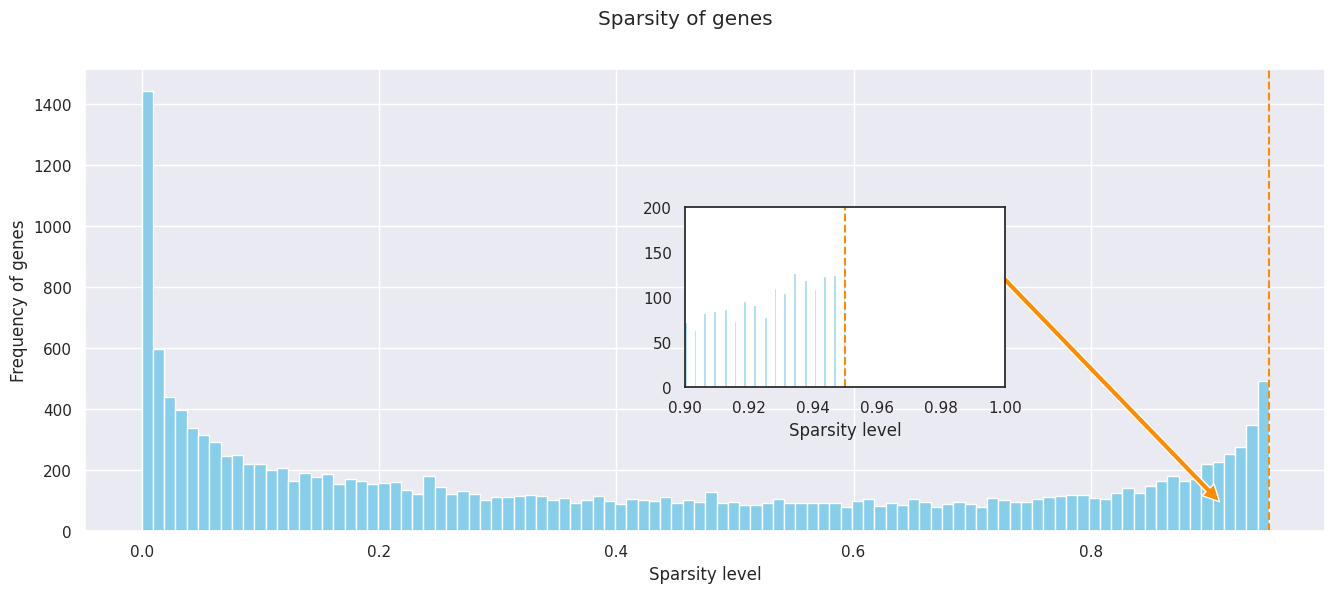

In [112]:
sparsity_threshold = 0.95

overall_sparsity = (unf_smart_mc_clean == 0).sum().sum() / unf_smart_mc_clean.size
print(f"Overall sparsity level: {overall_sparsity}")

sparsity_genes = (unf_smart_mc_clean == 0).sum(axis=0) / unf_smart_mc_clean.shape[0]

fig, ax = plt.subplots(figsize=(16, 6))
sns.set_style("white")
bars = ax.hist(sparsity_genes, bins=100, color='skyblue')
fig.suptitle("Sparsity of genes")
ax.set_xlabel("Sparsity level")
ax.set_ylabel("Frequency of genes")
ax.axvline(sparsity_threshold, color='darkorange', linestyle='dashed')

# Zoomed subplot
high_sparsity_genes = sparsity_genes[sparsity_genes >= 0.90]
ax2 = plt.axes([0.5, 0.35, 0.2, 0.3])
bins = np.histogram_bin_edges(high_sparsity_genes , bins=100)
sns.histplot(high_sparsity_genes, bins=bins, ax=ax2, color='skyblue') 
ax2.set_ylim(0, 200) 
ax2.set_xlim(0.9, 1.0)
ax2.set_xlabel('Sparsity level')
ax2.set_ylabel('')
ax2.axvline(sparsity_threshold, color='darkorange', linestyle='dashed')

ax.annotate('', xy=(0.92, 50), xytext=(0.6, 0.6), textcoords='figure fraction',
            arrowprops=dict(facecolor='darkorange', shrink=0.05))

sns.set_theme()

plt.show()

It follows the plot of the dataset with the removed high-sparsity genes, obviously we don't have bars over 95% sparsity level

In [113]:
unf_smart_mc_clean.shape

(320, 16444)

### 2.3.2)  Variability as feature





#### 2.3.2.0) Housekeeping genes

Housekeeping genes appear once more in our report. Now, under a completely different light. As mentioned earlier, housekeeping genes are characterized by their constant expression across various cell types and do not provide significant insights into the cellular condition. Consequently, we exclude them from further consideration, allowing us to focus on genes that offer more valuable information regarding the specific characteristics and conditions of the cells under investigation.

In [114]:
unf_smart_mc_clean = unf_smart_mc_clean.drop(columns=house_genes, errors='ignore')
unf_smart_mc_clean

"WASH7P"  "WASH9P"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         0         1   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0         0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...         0         1   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...         0        10   
...                                                      ...       ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0         0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         0         1   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1         1   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         0         4   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         1         5   

                                                    "MTND1P23"  "MTND2P28"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0           2   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0           1   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           0           1   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...           0           3   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           0           2   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           7   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           0          29   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           0           5   

                                                    "MTCO1P12"  "MTCO2P12"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           2           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           1           1   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           3           0   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...          10           1   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           1           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           5           5   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           4           0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           3           0   

                                                    "MTATP8P1"  "MTATP6P1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0          29   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0          12   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0          68   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           0         203   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...           0         691   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           0          49   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           0         370   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0          33   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           0         228   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           0          71   

                                                    "MTCO3P12"  "LINC01409"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0            0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0            0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0            0   
"output.STAR.1_A3_Norm_S3_Aligned.so

#### 2.3.2.1) Coefficient of Variation (CV)

The coefficient of variation (CV) is an important metric used to evaluate the relative variability present in a dataset. It enables unbiased comparisons among genes preventing genes with higher expression values from exerting disproportionate influence on the analysis solely due to their numerical magnitudes. By employing the CV, we can effectively assess and compare the variability of gene expression, enabling comprehensive analysis of the dataset.

In [115]:
cv = unf_smart_mc_clean.std() / unf_smart_mc_clean.mean()

top_10000_cv_genes = cv.nlargest(10000)
df_top_10000_cv = pd.DataFrame(top_10000_cv_genes, columns=['CV'])
df_top_10000_cv

CV
"UNC79"        13.449313
"KRT85"        13.402038
"TM4SF19"      13.007535
"SCRG1"        12.627831
"TM4SF19-AS1"  12.439719
...                  ...
"GNL3L"         1.227077
"MIR6728"       1.226924
"GLI4"          1.226857
"NDRG3"         1.226841
"FAM86JP"       1.226450

[10000 rows x 1 columns]

In [116]:
CV_best = df_top_10000_cv.index.tolist()

#### 2.3.2.2) Differential Expression Analysis (DEA)

While not directly measuring variability, differential expression analysis can help identify genes that are significantly differentially expressed between hypoxic and normoxic conditions. Genes with large differences in expression levels between the two conditions are likely to be relevant in distinguishing between hypoxia and normoxia.

In [117]:
A = pd.DataFrame(unf_condition)
adata = sc.AnnData(X=unf_smart_mc_clean, obs=A)
adata

AnnData object with n_obs × n_vars = 320 × 16444
    obs: 'Condition'

In [118]:
adata.obs['Condition'] = adata.obs['Condition'].astype('category')

sc.pp.normalize_total(adata, target_sum=1e4)

sc.tl.rank_genes_groups(adata, groupby='Condition', method='wilcoxon')
de_genes = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10000)

de_genes

0          1
0       "MT-CYB"    "NDRG1"
1       "MT-CO3"    "BNIP3"
2     "MTATP6P1"      "HK2"
3      "MT-ATP8"    "GAPDH"
4       "IFITM2"  "GAPDHP1"
...          ...        ...
9995      "SOS1"   "PODNL1"
9996    "B3GLCT"     "SMG6"
9997   "PA2G4P6"    "THBS3"
9998  "ATP5MFP2"     "AAR2"
9999      "STX4"    "C2CD3"

[10000 rows x 2 columns]

In [122]:
# first column of de_genes for normo and hypo
DEA_best_norm = de_genes.iloc[:, 0].tolist()

DEA_best_hypo = de_genes.iloc[:, 1].tolist()


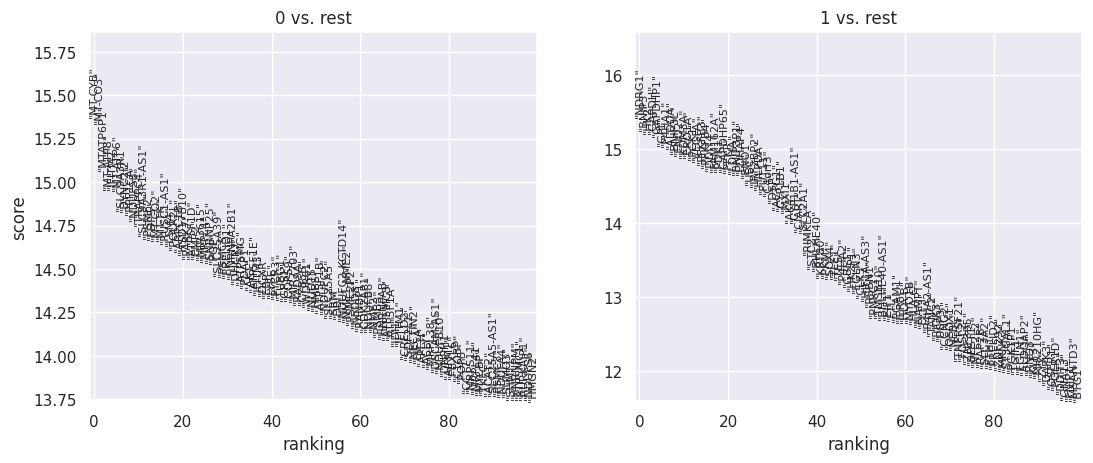

In [123]:
sc.pl.rank_genes_groups(adata, n_genes=100, sharey=False)

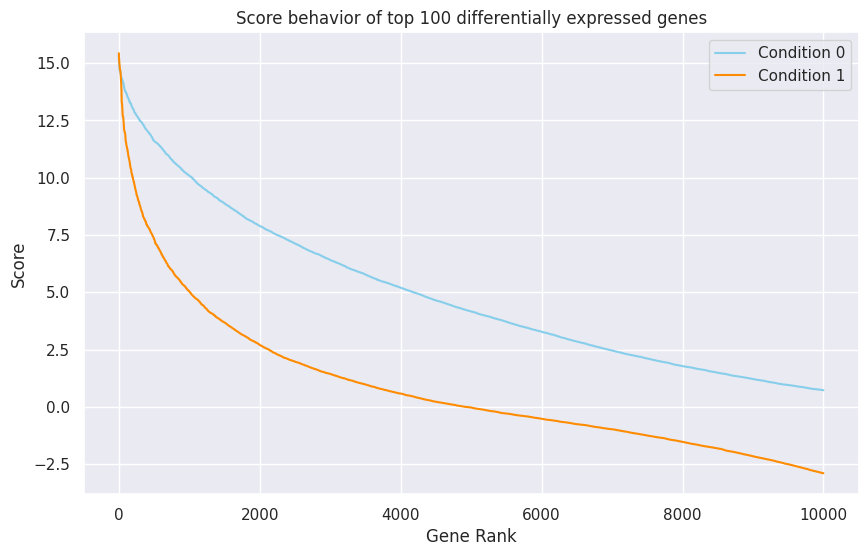

In [124]:
scores_condition0 = adata.uns['rank_genes_groups']['scores']['0'][:10000]
names_condition0 = adata.uns['rank_genes_groups']['names']['0'][:10000]

scores_condition1 = adata.uns['rank_genes_groups']['scores']['1'][:10000]
names_condition1 = adata.uns['rank_genes_groups']['names']['1'][:10000]

rank = list(range(0, 10000))


plt.figure(figsize=(10, 6))
plt.plot(rank, scores_condition0, color='skyblue', label='Condition 0')
plt.plot(rank, scores_condition1, color='darkorange', label='Condition 1')

idx_intersection = np.where(np.diff(np.sign(scores_condition0 - scores_condition1)) != 0)[0]

plt.title('Score behavior of top 100 differentially expressed genes')
plt.xlabel('Gene Rank')
plt.ylabel('Score')
plt.legend()
plt.show()

In [125]:
data = unf_smart_mc_clean
combined_data = data.assign(Condition=data.index.to_series().apply(extract_condition))

data['Condition'] = combined_data['Condition'].values
unf_smart_mc_clean = unf_smart_mc_clean.T.drop("Condition").T

In [126]:
unf_condition=unf_smart_mc_clean.index.to_series().apply(lambda x: extract_condition(x))
unf_condition.name = "Condition"
unf_condition = pd.DataFrame(unf_condition)

### 2.3.3) Inspecting correlations instances

Examining correlation instances is crucial for obtaining insights about the feature under consideration and making informed decisions regarding feature selection. By investigating correlations, one can reveal associations, dependencies, and connections that may exist among variables, providing valuable information about the underlying dynamics and structures within the data.

In [127]:

combined_data_np = combined_data.values
condition_index = list(combined_data.columns).index('Condition')


condition_corr = [np.corrcoef(combined_data_np[:, condition_index], combined_data_np[:, i])[0, 1] 
                  for i in range(combined_data_np.shape[1])]

condition_corr_series = pd.Series(condition_corr, index=combined_data.columns)
condition_corr_genes = condition_corr_series.drop('Condition')
condition_corr_series = condition_corr_series.sort_values(ascending=False)

This is the correlation matrix among the 100 genes most correlated to the oxigenation condition.

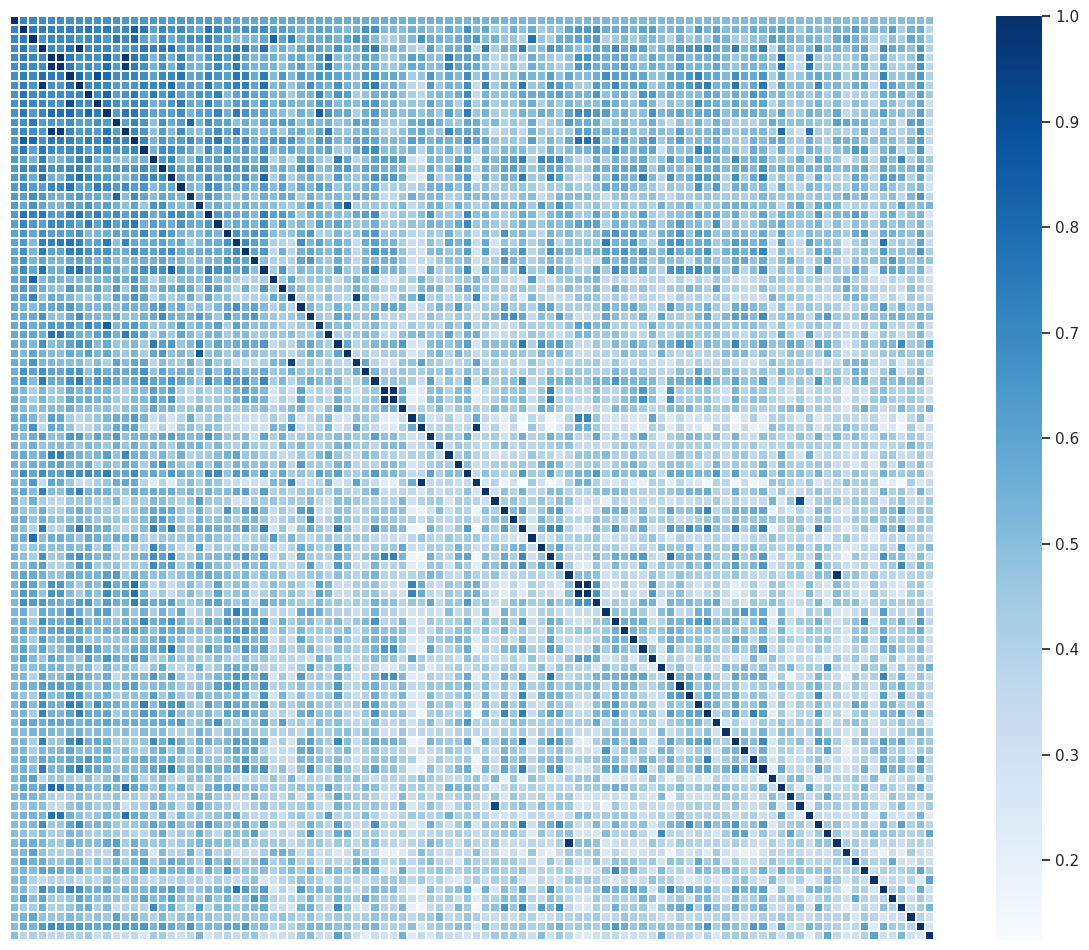

In [129]:
#Top 100 most correlated genes
most_corr_genes = list(condition_corr_series.index[:100])
top_genes_corr_matrix = combined_data[most_corr_genes].corr()

f, ax = plt.subplots(figsize=(16, 12))


sns.heatmap(top_genes_corr_matrix, cmap='Blues', vmax=1,
            cbar=True, square=True, fmt='.2f', linecolor='white', linewidths=0.01)
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

In [131]:
condition_dummies = pd.get_dummies(combined_data['Condition'], prefix='')

# Rename the columns to 'Hypoxia' and 'Normoxia'
condition_dummies.columns = ['Normoxia', 'Hypoxia']

new_combined_data = combined_data.drop('Condition', axis=1)
new_combined_data = pd.concat([new_combined_data, condition_dummies], axis=1)

new_combined_data

"WASH7P"  "WASH9P"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         0         1   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0         0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...         0         0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...         0         1   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...         0        10   
...                                                      ...       ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0         0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         0         1   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         1         1   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         0         4   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         1         5   

                                                    "MTND1P23"  "MTND2P28"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0           2   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0           1   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           0           1   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...           0           3   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           0           2   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           7   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           0          29   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           0           5   

                                                    "MTCO1P12"  "MTCO2P12"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           2           0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           1           1   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0           0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           3           0   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...          10           1   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           1           0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           5           5   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0           0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           4           0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           3           0   

                                                    "MTATP8P1"  "MTATP6P1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0          29   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0          12   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0          68   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...           0         203   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...           0         691   
...                                                        ...         ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...           0          49   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...           0         370   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...           0          33   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...           0         228   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...           0          71   

                                                    "MTCO3P12"  "LINC01409"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...           0            0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...           0            0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...           0            0   
"output.STAR.1_A3_Norm_S3_Aligned.so

In [133]:
new_combined_data_np = new_combined_data.values

normoxia_index = list(new_combined_data.columns).index('Normoxia')
hypoxia_index = list(new_combined_data.columns).index('Hypoxia')

# Calculate correlation
normoxia_corr = [np.corrcoef(new_combined_data_np[:, normoxia_index], new_combined_data_np[:, i])[0, 1] 
                 for i in range(new_combined_data_np.shape[1] - 2)]
hypoxia_corr = [np.corrcoef(new_combined_data_np[:, hypoxia_index], new_combined_data_np[:, i])[0, 1] 
                for i in range(new_combined_data_np.shape[1] - 2)]

normoxia_corr_series = pd.Series(normoxia_corr, index=new_combined_data.columns[:-2])
hypoxia_corr_series = pd.Series(hypoxia_corr, index=new_combined_data.columns[:-2])

# Sort the values 
normoxia_corr_top100 = normoxia_corr_series.sort_values(ascending=False).head(100)
hypoxia_corr_top100 = hypoxia_corr_series.sort_values(ascending=False).head(100)

normoxia_corr_top10000 = normoxia_corr_series.sort_values(ascending=False).head(10000)
hypoxia_corr_top10000 = hypoxia_corr_series.sort_values(ascending=False).head(10000)

# Save the gene
corr_best_normo = normoxia_corr_top10000.index.tolist()
corr_best_hypo = hypoxia_corr_top10000.index.tolist()

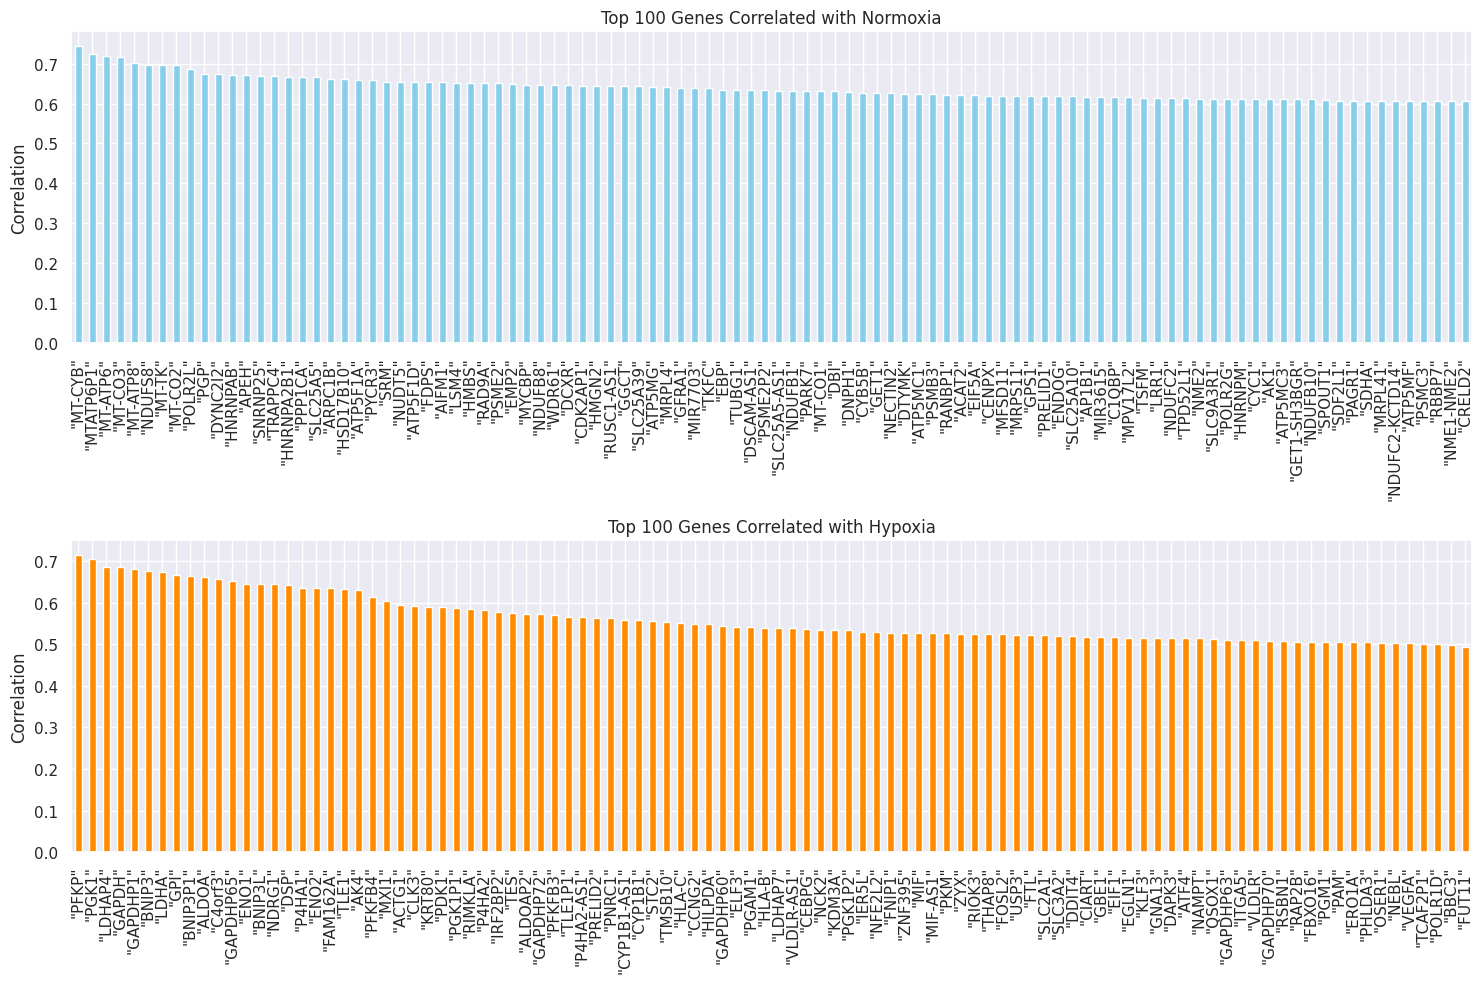

In [134]:
#Plots
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

#normo
normoxia_corr_top100.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title('Top 100 Genes Correlated with Normoxia')
ax[0].set_ylabel('Correlation')

#hypo
hypoxia_corr_top100.plot(kind='bar', ax=ax[1], color='darkorange')
ax[1].set_title('Top 100 Genes Correlated with Hypoxia')
ax[1].set_ylabel('Correlation')

plt.tight_layout()
plt.show()

### 2.3.4) Genes relevance ranking

Now we consider as relevant the genes which manifest high ranking according to the criteria of variability and correlation with the hypoxia condition.

In [135]:
top_cv = sorted(CV_best, reverse=True)[:10000]
top_dea_hypo = sorted(DEA_best_norm, reverse=True)[:10000]
top_dea_norm = sorted(DEA_best_hypo, reverse=True)[:10000]
top_hypoxia_corr = sorted(corr_best_normo, reverse=True)[:10000]
top_normoxia_corr = sorted(corr_best_hypo, reverse=True)[:10000]

In [138]:
#Sets of all tops
sets = [set(top_cv), set(top_dea_hypo), set(top_dea_norm), set(top_hypoxia_corr), set(top_normoxia_corr)]

#Union and list
union_genes = set.union(*sets)
union_list = list(union_genes)

In [137]:
len(union_list)

16444

In [139]:
final_data = unf_smart_mc_clean[union_list]

In [140]:
final_data

"COL5A1"  "TIMMDC1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...         0         48   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...         0          1   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...        10         29   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...         0         92   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...         0        132   
...                                                      ...        ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...         0         31   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...         0        134   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...         0         39   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...         0         94   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...         3         29   

                                                    "GCSH"  "ZNF385B"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...       4          0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...      14          0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...       2          0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...      11          0   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...      14          6   
...                                                    ...        ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...       3          0   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...      12          0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...       9          0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...       4          0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...       3          0   

                                                    "RTL8A"  "ZRSR2"  "ATRIP"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...      178       11        0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...      558        5        0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...       89        5        0   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...      365       15       39   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...      324       12       75   
...                                                     ...      ...      ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...       76       17       21   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...      470        7        0   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...      199       40        0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...      159       72        0   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...      114       25       28   

                                                    "PDHA1"  "ARHGEF1"  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...      158          0   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...       93          0   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...       21         31   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...      223         70   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...      227        159   
...                                                     ...        ...   
"output.STAR.4_H5_Norm_S359_Aligned.sortedByCoo...       65          5   
"output.STAR.4_H6_Norm_S360_Aligned.sortedByCoo...      144         58   
"output.STAR.4_H7_Hypo_S379_Aligned.sortedByCoo...      118          0   
"output.STAR.4_H8_Hypo_S380_Aligned.sortedByCoo...      130         29   
"output.STAR.4_H9_Hypo_S381_Aligned.sortedByCoo...       61        276   

                                                    "RMDN2-AS1"  ...  \
"output.STAR.1_A10_Hypo_S28_Aligned.sortedByCoo...            0  ...   
"output.STAR.1_A12_Hypo_S30_Aligned.sortedByCoo...            0  ...   
"output.STAR.1_A2_Norm_S2_Aligned.sortedByCoord...            0  ...   
"output.STAR.1_A3_Norm_S3_Aligned.sortedByCoord...            0  ...   
"output.STAR.1_A4_Norm_S4_Aligned.sortedByCoord...  

In sight of chapter 3, we chose the most 3000 variable genes, as in the provided train abd test datasets.

In [141]:
#final variance
variances = final_data.var().sort_values(ascending=False)
top_3000_genes = variances[:3000].index

best_data = final_data[top_3000_genes]

### 2.3.5) Similarity between datasets

In [142]:
def posit(cells, genes, clean_cells, clean_genes):
    different_cells = set() 
    equal_cells = set()
    different_genes = set() 
    equal_genes = set()
    different_cells = set(clean_cells)-set(cells)
    equal_cells = set(cells).intersection(set(clean_cells))	
    different_genes = set(genes)-set(clean_genes)
    equal_genes = set(genes).intersection(set(clean_genes))
    cells_similarity = (len(equal_cells) /len(clean_cells))*100
    genes_similarity = (len(equal_genes) /len(genes))*100
    return len(different_cells),len(equal_cells),len(different_genes),len(equal_genes), cells_similarity, genes_similarity
  

In [143]:
print('Cells difference:',posit(fil_smart_mc.index,
                                fil_smart_mc.T.index,
                                unf_smart_mc_clean.index,
                                union_genes)[0])

print('Cells in common:',posit(fil_smart_mc.index, 
                               fil_smart_mc.T.index,
                               unf_smart_mc_clean.index, 
                               union_genes)[1])

print(f'Similarity in cells: {posit(fil_smart_mc.index,fil_smart_mc.T.index, unf_smart_mc_clean.index, union_genes)[4]}%')

print('Genes difference:',posit(fil_smart_mc.index,
                                fil_smart_mc.T.index,
                                unf_smart_mc_clean.index,
                                union_genes)[2])

print('Genes in common:',posit(fil_smart_mc.index,
                               fil_smart_mc.T.index, 
                               unf_smart_mc_clean.index,
                               union_genes)[3])

print(f'Similarity in genes: {posit(fil_smart_mc.index,fil_smart_mc.T.index, unf_smart_mc_clean.index, union_genes)[5]}%')

Cells difference: 7
Cells in common: 313
Similarity in cells: 97.8125%
Genes difference: 2501
Genes in common: 16444
Similarity in genes: 86.79862760622855%


In [144]:
different_genes = set(fil_smart_mc.T.index)-set(final_data.T.index)
equal_genes = set(fil_smart_mc.T.index).intersection(final_data.T.index)


In [145]:
len(different_genes), len(equal_genes)

(2501, 16444)

### 2.3.5) Compare results among cancers and methods

## 2.4) Normalization of the Data

### 2.4.0) Quantile forcing

Quantile forcing is a commonly employed approach in statistics. However, it is important to consider its limitations, especially when dealing with outliers, extreme values, or situations where preserving the original data distribution and intersample variability is important. In our particular case, maintaining the integrity of the data distribution and preserving intersample variability is crucial. Therefore, it is necessary to carefully evaluate the applicability and potential drawbacks of using quantile forcing in our analysis.

### 2.4.1) Inspecting Batch Effects



Drop-seq and Smart-seq are distinct single-cell RNA sequencing technologies with inherent differences. Drop-seq tends to capture a lower number of RNA molecules per cell and exhibits bias towards highly expressed genes. On the other hand, Smart-seq captures a higher number of molecules and can detect both highly and lowly expressed genes. Another differentiating factor is that Drop-seq, utilizing a droplet-based approach, introduces more technical noise, while Smart-seq, employing a plate-based method, presents a different noise profile. These discrepancies in technology and methodology can contribute to the emergence of batch effects, emphasizing the need for careful consideration when comparing or integrating data generated from these two techniques.These variations may stem from disparities in sample preparation, sequencing runs, or experimental conditions, and can noticeably influence the gene expression profiles, thereby complicating the classification task.

In [ ]:
drop_mc = pd.concat([train_data_MCF7_DropS, test_data_MCF7_DropS])

#considering 383 cells at random
drop_mc = drop_mc.sample(n=383, random_state=0)


common_genes = drop_mc.columns.intersection(unf_smart_mc.columns)

drop_mc = drop_mc[common_genes]
unf_smart_mc = unf_smart_mc[common_genes]
drop_mc['batch'] = 1
unf_smart_mc['batch'] = 0

df = pd.concat([drop_mc, unf_smart_mc])

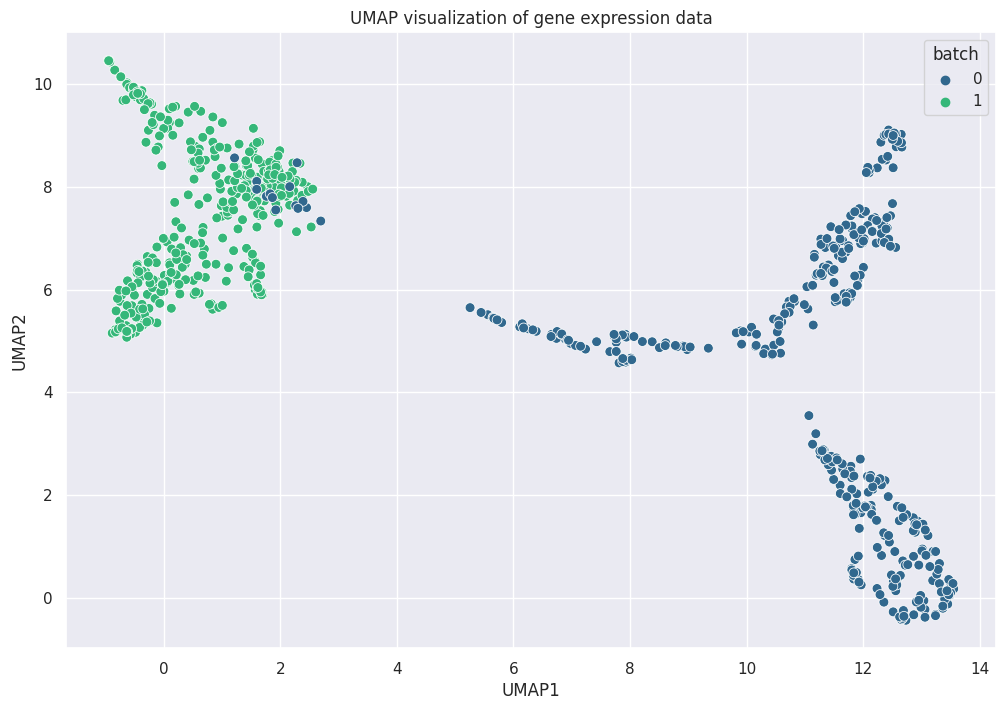

In [148]:
data = df.iloc[:, :-1]
labels = df["batch"]
reducer = umap.umap_.UMAP(random_state = 69)
embedding = reducer.fit_transform(data)

plt.figure(figsize=(12, 8))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette="viridis", s=50)
plt.title("UMAP visualization of gene expression data")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()


The plot shows that batch effects are present and one should be careful in handling them.
By conducting separate analyses for each dataset without directly integrating or comparing them, any batch effects specific to each dataset would not directly influence the comparisons or conclusions made within each individual dataset. This approach helps mitigate the potential impact of batch effects on the accuracy and validity of the within-dataset comparisons.

# 3) **Unsupervised Analysis**

## 3.1) Agglomerative clustering

After having preprocessed the data, we inspect graphically the structure of the polished dataset.

We implement linkage methods to understand the similarities that remain visible and then, relying on dimensionality reduction, we use k-means algorithm, so to confirm the results obtained. We expect to see datapoints with common label to cluster together.

In [151]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1 
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    
    plt.figure(figsize=(15, 10)) 
    dendrogram(linkage_matrix, **kwargs)

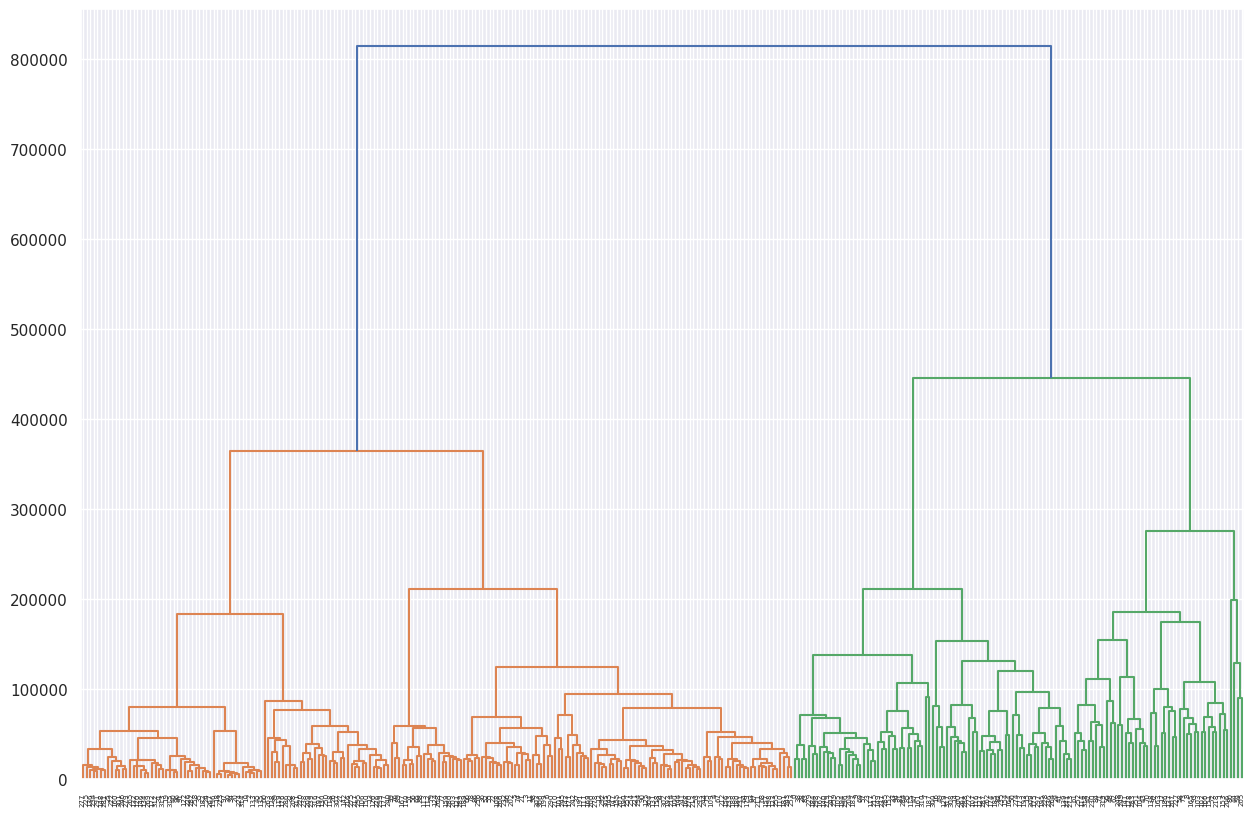

In [152]:
cluster_ward = AgglomerativeClustering(n_clusters=None, distance_threshold=0, linkage='ward')
cluster_ward.fit_predict(final_data)

plot_dendrogram(cluster_ward)

As we can clearly see from the clustering, the dataset is split into two separated groups. 

## 3.2) K-Means

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


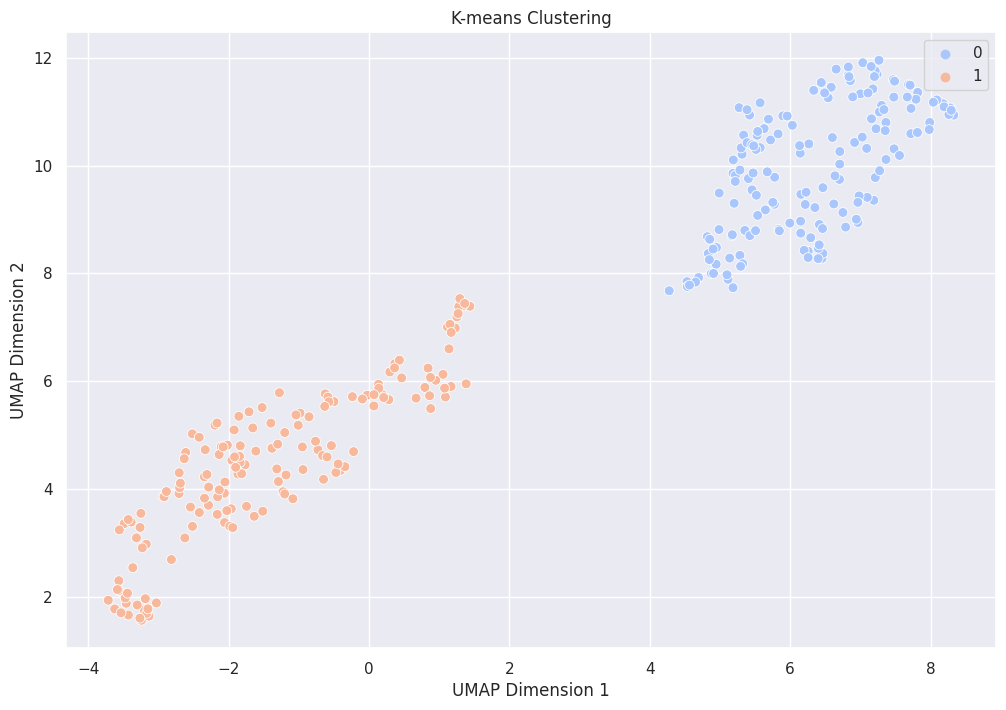

In [153]:
reducer = umap.UMAP(n_components=2, random_state=69)
umap_output = reducer.fit_transform(best_data)


k = 2  # Number of clusters
kmeans = KMeans(n_clusters=k)
kmeans.fit(umap_output)

cluster_labels = kmeans.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_output[:, 0], y=umap_output[:, 1], hue=cluster_labels, palette="coolwarm", s=50)
plt.title("K-means Clustering")
plt.xlabel("UMAP Dimension 1")
plt.ylabel("UMAP Dimension 2")
plt.show()



The clear segmentation of the cells validates the effectiveness of the filtering process.

# 4) **Classification** 

## 4.1) SmartSeq MCF7


For the time being we concentrate on MCF7 SmartSeq. We will apply the same pipeline to HCC1806.    

Given the typical imbalance in datasets where there's a plethora of genes but sparse cells, trying to encapsulate the entire intricacy of our data might trigger overfitting. This approach could also instigate extended training periods. To evade these challenges, we aim to focus our data by applying various techniques. Our ultimate goal is to provide our models with the most streamlined representation of our data, while maintaining the maximum amount of information. In doing so, there's a considerable chance to boost the performance of our models. To achieve this, we intend to assign a hierarchy to the features and manipulate the quantity of these features as a hyperparameter.    

Our pipeline will be the following:  

1. Build a gerarchy of importance between features using the mutual information with repsect to the labels.
2. Training the classifiers with hyperparameter tuning.
3. Ensembling the classifiers.

4. Doing a PCA and using the gerarchy given by the principal components.
5. Training the classifiers with hyperparameter tuning.
6. Ensembling the classifiers.

7. Ensembling the results from 3. and 6.

In [ ]:
# Load data
train_data_MCF7_SmartS = pd.read_csv("MCF7_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", engine='python', index_col=0).T

test_data_MCF7_SmartS = pd.read_csv("MCF7_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", engine='python', index_col=0).T

train_data_HCC1806_DropS = pd.read_csv("HCC1806_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", engine='python', index_col=0).T

In [ ]:
train_data_MCF7_SmartS_condition = train_data_MCF7_SmartS.index.to_series().apply(lambda x: extract_condition(x))

We split the train dataset into X_train and X_test, in order to be able to evaluate the performance of our classifiers on unseen data.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data_MCF7_SmartS, train_data_MCF7_SmartS_condition,
                                                      test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(225, 3000) (25, 3000) (225,) (25,)


We choose the accuracy as loss function.

### 4.1.1) Mutual Information

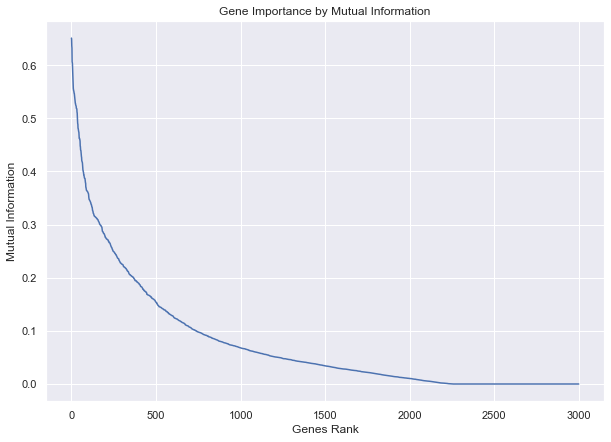

In [ ]:
# Calculate the mutual information between each gene and the target
mi = mutual_info_classif(X_train, y_train)

# Create a dictionary where the keys are the feature (gene) names and the values are the mutual information
mi_dict = {col: mi for col, mi in zip(X_train.columns, mi)}

# Sort the dictionary by the mutual information in descending order
sorted_mi_dict = sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)

# Extract the mutual information values and the gene names
mi_values = [gene[1] for gene in sorted_mi_dict]
genes = [gene[0] for gene in sorted_mi_dict]

important_genes = [gene[0] for gene in sorted_mi_dict]

# Plot the mutual information
plt.figure(figsize=(10, 7))
plt.plot(mi_values)
plt.ylabel('Mutual Information')
plt.xlabel('Genes Rank')
plt.title('Gene Importance by Mutual Information')
plt.show()

### 4.1.2) Hyperparameter Tuning

We create two dictionaries: in the first one we will save the tuned classifiers, and in the second one we will save the number of features chosen in each classifier (we have to do it because the number of features isn't automatically saved in the best parameters).

In [ ]:
clfs_best_hyperparam_smarts_mcf7_mi = {}
best_genes_smarts_mcf7_mi = {}

Now we show the function we will use to tune the hyperparameters for each classifier.  
Everything is built upon RandomizedSearchCV, which is a technique in Scikit-Learn that helps optimize hyperparameters of a model. It differs from GridSearchCV, another hyperparameter optimization technique, in that it does not try all possible combinations of hyperparameters, but rather a fixed number of parameter settings is sampled from the specified distributions. We believe it is better to use it in this situation since we are going to train many classifiers, and some of them have a large number of possible hyperparameters.  

We highlight below the step that the function does:

1. It initializes variables to store the best classifier, the best parameters, and the best score.

2. It then sets up a RandomizedSearchCV object, which will perform hyperparameter tuning with cross-validation. The parameters that this RandomizedSearchCV object will try are given by the params argument. It will perform cv-fold cross-validation and it will try n_iter different sets of parameters.

3. For each number of features from 5 to n_total with a step of 5, it does the following:
   It selects that number of most important features from the training data.
   It fits the RandomizedSearchCV object on the training data with the selected features. The RandomizedSearchCV object will automatically perform cross-validation and keep track of the best parameters it found.
   It appends the score of the best set of parameters to the scores list, and appends a dictionary with the score, the best parameters, and the number of features to the param_performance list.
   If the score of the best set of parameters is better than any previous score, it updates the best classifier, the best parameters, and the best score.

4. After trying all the numbers of features, it prints the best parameters it found and returns the best classifier, the optimal number of features, and the list of all scores and parameters it tried.

In [ ]:
def find_best_hyperparam(X_train, y_train, important_genes, estimator, params, cv=5, n_iter=50, n_total=100):

    best_clf, best_params, best_score = None, None, -math.inf
    scores = []
    param_performance = []
    
    clf = RandomizedSearchCV(estimator, params, n_jobs = -1, cv=cv, scoring="accuracy", n_iter=n_iter)

    #for n_features in range(5, n_total, 5):
    for n_features in range(5, 1000, 5):
        X_train_cv = X_train[important_genes[:n_features]]
        
        clf.fit(X_train_cv, y_train)
        scores.append(clf.best_score_)

        param_performance.append({
            'score': clf.best_score_,
            'params': clf.best_params_,
            'n_features': n_features
        })

        if clf.best_score_ > best_score:
            best_clf, best_score = clf.best_estimator_, clf.best_score_
            best_params = clf.best_params_
            best_params['n'] = n_features

    print('Best Classifier parameters:', best_params)
    
    return best_clf, best_params['n'], param_performance

Let's start to tune our classifiers.  

We start with the SVM. We will tune the following hyperparameters:  
1. The kernel function used in SVM. The kernel function determines the type of hyperplane used to separate the data in the feature space.
2. 'C'. This sets the regularization parameter C to a range that's logarithmically distributed between 1e-3 and 1e3. The C parameter controls the trade-off between achieving a low training error and a low testing error that is the capacity of the SVM to generalize.
3. 'degree'. This parameter sets the degree of the polynomial kernel function ('poly'). It is ignored by all other kernels.

In [ ]:
estimator = SVC(probability=True)
params = {
    'kernel': ['rbf', 'sigmoid', 'poly', 'linear'], 
    'C': loguniform(1e-3, 1e3), 
    'degree': [2, 3, 4, 5]
}

best_clf, best_n_features, param_performance = find_best_hyperparam(
    X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10
)

clfs_best_hyperparam_smarts_mcf7_mi['svm'] = best_clf
best_genes_smarts_mcf7_mi['svm'] = best_n_features

Best Classifier parameters: {'C': 437.4691334453383, 'degree': 4, 'kernel': 'linear', 'n': 5}


Let's move to the Random Forest.  
The parameters called when the classifier is built specify that bootstrapping is used when building the trees and each tree in the forest will be built on a sample containing 80% of the original data.  
The hyperparameters we want to tune are:  
1. The number of trees in the forest.
2. 'max_leaf_nodes'. This parameter sets a limit on the number of leaf nodes for each tree in the forest.

In [ ]:
# Runs in 1 min.

estimator = RandomForestClassifier(bootstrap=True, max_samples=0.8)
params = {
    'n_estimators':[20, 30, 50, 100, 200], 
    'max_leaf_nodes': np.arange(20, 100, 10)
    }

best_rf, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_mcf7_mi['Random Forest'] = best_rf
best_genes_smarts_mcf7_mi['Random Forest'] = n

Best Classifier parameters: {'n_estimators': 20, 'max_leaf_nodes': 90, 'n': 15}


Now we tune the Logistic Regression.  
The hyperparameters in cluded are:  
1. 'penalty'. The norm used in the penalization.
2. 'C'. Inverse of regularization strength; smaller values specify stronger regularization.
3. 'fit_intercept'. Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
4. 'class_weight'. It chooses the weights associated with classes. 
5. 'solver'. Algorithm to use in the optimization problem.

In [ ]:
estimator = LogisticRegression()
params = {
    'penalty': ['l2', 'l1'], 
    'C': loguniform(1e-3, 1e3), 
    'fit_intercept': [True, False], 
    'class_weight': [None, 'balanced'], 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


best_lr, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_mcf7_mi['Logistic'] = best_lr
best_genes_smarts_mcf7_mi['Logistic'] = n

Best Classifier parameters: {'C': 122.82877536359861, 'class_weight': 'balanced', 'fit_intercept': False, 'penalty': 'l2', 'solver': 'newton-cg', 'n': 10}


Let's now move to the K-NearestNeighbors.  
The hyperparameters included are:  
1. The number of neighbors to use for the k-NN computation.
2. The weight function used in prediction. 'Uniform' weights mean all points in each neighborhood are weighted equally. 'Distance' weights mean closer neighbors of a query point will have a greater influence than neighbors which are further away.
3. 'metric'. This is the distance metric to use. The options being considered are 'euclidean', 'manhattan', 'chebyshev', and 'minkowski'.
4. 'p'. This is the power parameter for the Minkowski metric.

In [ ]:
estimator = KNeighborsClassifier()
params = {
    'n_neighbors': np.arange(3, 20), 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1, 2, 3, 4, 5]
}

best_knn, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_mcf7_mi['KNN'] = best_knn
best_genes_smarts_mcf7_mi['KNN'] = n

Best Classifier parameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 3, 'metric': 'minkowski', 'n': 5}


Now we move on to the Gradient Boosting Decision Trees.  
The hyperparameters we include are:  
1. The number of boosting stages or trees to be constructed.
2. 'learning_rate': a quantity that affects how much each new tree influences the final prediction.
3. 'subsample'. The fraction of the total training set that can be used for any individual tree.
4. 'max_depth'. The maximum depth of the individual decision trees.  
5. 'min_samples_split'. The minimum number of samples required to split an internal node in the decision trees.
6. 'min_samples_leaf'. The minimum number of samples required to be at a leaf node of the decision trees.

In [ ]:
# Runs in 3 mins.

estimator = GradientBoostingClassifier()

params = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': uniform(loc=0.01, scale=0.2),
    'subsample': uniform(loc=0.5, scale=0.5),
    'max_depth': range(3, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

best_gb, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_mcf7_mi['GradientBoosting'] = best_gb
best_genes_smarts_mcf7_mi['GradientBoosting'] = n

Best Classifier parameters: {'learning_rate': 0.18677538913345418, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 10, 'subsample': 0.5829767657965306, 'n': 55}


The last classifier is the Multilayer Perceptron.  
The hyperparameters included are:  
1. The number of neurons in the hidden layers of the MLP (Multi-Layer Perceptron). For example, (50,) means one hidden layer with 50 neurons, (100,100) means two hidden layers with 100 neurons each.
2. The activation function.
3. The solver.
4. 'alpha'. The L2 penalty (regularization term) parameter, which helps to avoid overfitting by penalizing large values of the model parameters.
5. 'learning_rate'. The learning rate schedule for weight updates.
6. The maximum number of iterations, or epochs, which is the number of times the entire training data should be processed.

In [ ]:
# Runs in 10 mins.

estimator = MLPClassifier()

params = {
    'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (100, 100), (200, 200)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': uniform(loc=0.0001, scale=0.01),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 500, 1000]
}


best_mlp, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_mcf7_mi['MLP'] = best_mlp
best_genes_smarts_mcf7_mi['MLP'] = n

Best Classifier parameters: {'activation': 'logistic', 'alpha': 0.0040312688232943174, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 1000, 'solver': 'lbfgs', 'n': 20}


Let's calculate the accuracy and the confusion matrices.

Accuracy of svm: 1.0000


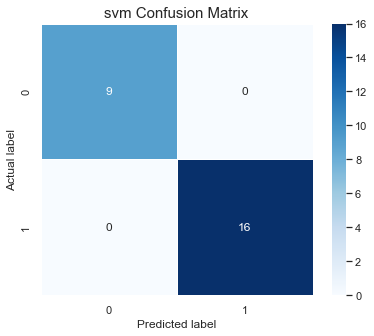

Accuracy of Random Forest: 1.0000


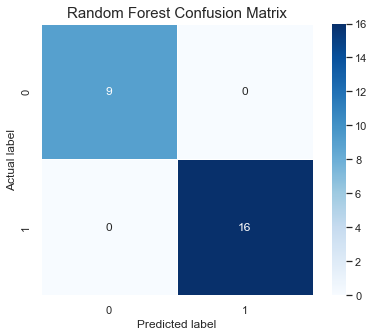

Accuracy of Logistic: 1.0000


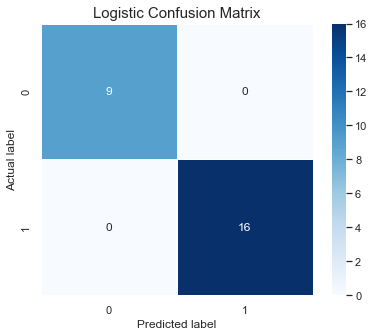

Accuracy of KNN: 1.0000


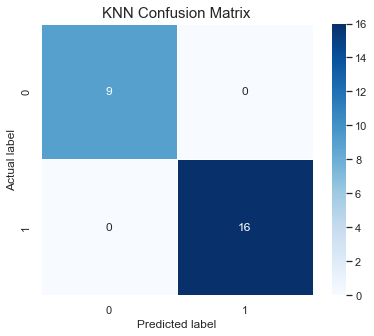

Accuracy of GradientBoosting: 0.9600


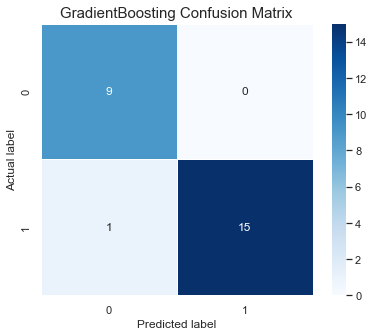

Accuracy of MLP: 1.0000


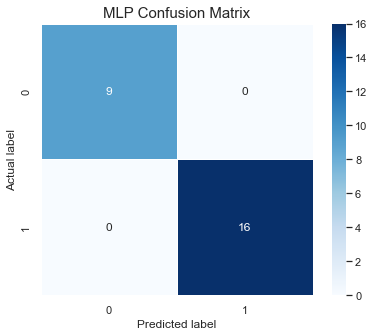

In [ ]:
for clf_name, clf in clfs_best_hyperparam_smarts_mcf7_mi.items():
    X_test_clf = X_test[important_genes[:best_genes_smarts_mcf7_mi[clf_name]]]
    
    y_pred = clf.predict(X_test_clf)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of {clf_name}: {accuracy:.4f}')
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'{clf_name} Confusion Matrix', size=15)
    plt.show()

### 4.1.3) First Ensemble for MCF7SmartSeq

Let's build the ensemble. We do a hard voting ensemble.

Accuracy of Ensemble: 1.0000


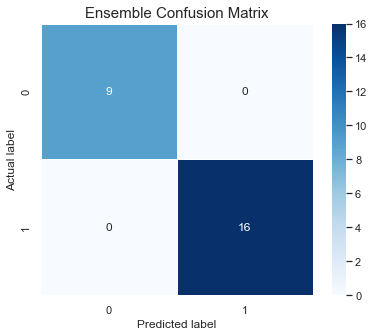

In [ ]:
# Create the ensemble model
ensemble = VotingClassifier(
    estimators=[(clf_name, clf) for clf_name, clf in clfs_best_hyperparam_smarts_mcf7_mi.items()], 
    voting='hard'
)

# Fit each classifier in the ensemble on the appropriate subsets of the training data
for name, clf in ensemble.estimators:
    clf.fit(X_train[important_genes[:best_genes_smarts_mcf7_mi[name]]], y_train)

# Note that the ensemble itself is not fitted, we only fit the individual classifiers

# To make a prediction, we need to get the predictions from all classifiers and then use the voting mechanism
# to get the ensemble prediction
ensemble_predictions = []
for name, clf in ensemble.estimators:
    X_test_ensemble = X_test[important_genes[:best_genes_smarts_mcf7_mi[name]]]
    y_pred = clf.predict(X_test_ensemble)
    ensemble_predictions.append(y_pred)

# Perform hard voting i.e., majority voting
y_pred_ensemble_SmartS_MCF7 = np.rint(np.mean(ensemble_predictions, axis=0)).astype(int)

# Compute the accuracy
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble_SmartS_MCF7)
print(f'Accuracy of Ensemble: {accuracy_ensemble:.4f}')

# Create confusion matrix
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble_SmartS_MCF7)

# Plot the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm_ensemble, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Ensemble Confusion Matrix', size=15)
plt.show()

### 4.1.4) PCA

Now we do a PCA on our X_train. Then we will use the gerarchy of importance of the principal components given by the PCA.

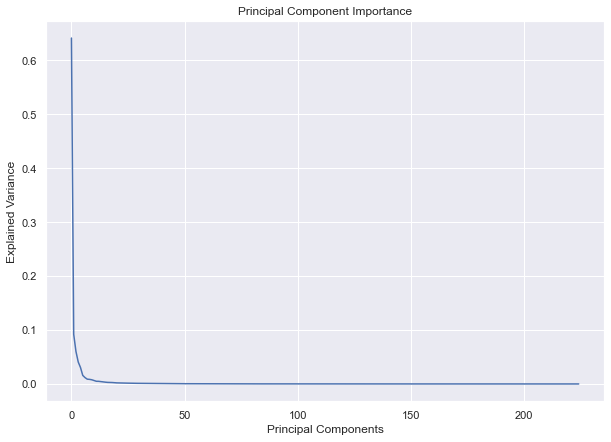

In [ ]:
pca = PCA(n_components=min(*X_train.shape))
X_train_pca = pca.fit_transform(X_train)

explained_variance = pca.explained_variance_ratio_

pc_dict = {f'PC{i+1}': ev for i, ev in enumerate(explained_variance)}

sorted_pc_dict = sorted(pc_dict.items(), key=lambda item: item[1], reverse=True)

variance_values = [pc[1] for pc in sorted_pc_dict]
pcs = [pc[0] for pc in sorted_pc_dict]

plt.figure(figsize=(10, 7))
plt.plot(variance_values)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Principal Component Importance')
plt.show()


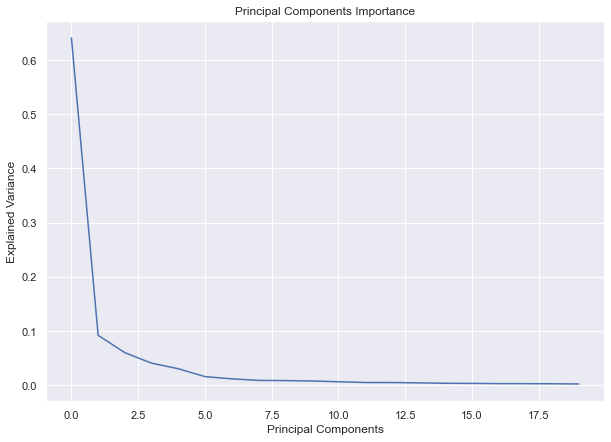

0.9546088989190337


In [ ]:
n_components = 20

variance_values = [pc[1] for pc in sorted_pc_dict[:n_components]]
pcs = [pc[0] for pc in sorted_pc_dict[:n_components]]

plt.figure(figsize=(10, 7))
plt.plot(variance_values)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Principal Components Importance')
plt.show()

print(sum(variance_values))

It's remarkable to notice that almost all of the variance is explained by the first 20 principal components. This is coherent with the dataset being very sparse.

### 4.1.5) Hyperparameter Tuning

In [ ]:
def find_best_hyperparam_pca(X_train_pca, y_train, estimator, params, cv=5, n_iter=50):
    best_clf, best_params, best_score = None, None, -math.inf
    scores = []
    param_performance = []
    
    clf = RandomizedSearchCV(estimator, params, cv=cv, scoring="accuracy", n_iter=n_iter)

#We start from 5 and go up to the number of PCs
    for n_components in range(5, 20, 5):
        clf.fit(X_train_pca[:,:n_components], y_train)
        scores.append(clf.best_score_)

        param_performance.append({
            'score': clf.best_score_,
            'params': clf.best_params_,
            'n_components': n_components
        })

        if clf.best_score_ > best_score:
            best_clf, best_score = clf.best_estimator_, clf.best_score_
            best_params = clf.best_params_
            best_params['n'] = n_components

    print('Best Classifier parameters:', best_params)
    
    return best_clf, best_params['n'], param_performance

In [ ]:
clfs_best_hyperparam_smarts_mcf7_pca = {}
best_components_smarts_mcf7_pca = {}

In [ ]:
# Runs in 1 min.

estimator = SVC(probability=True)
params = {
    'kernel': ['rbf', 'sigmoid', 'poly', 'linear'], 
    'C': loguniform(1e-3, 1e3), 
    'degree': [2, 3, 4, 5]
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_mcf7_pca['svm'] = clf
best_components_smarts_mcf7_pca['svm'] = n_components

Best Classifier parameters: {'C': 0.030985069081990297, 'degree': 3, 'kernel': 'rbf', 'n': 10}


In [ ]:
 # Runs in 10 min.

estimator = RandomForestClassifier(bootstrap=True, max_samples=0.8)
params = {
    'n_estimators':[20, 30, 50, 100, 200], 
    'max_leaf_nodes': np.arange(20, 100, 10)
    }

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_mcf7_pca['Random Forest'] = clf
best_components_smarts_mcf7_pca['Random Forest'] = n_components

Best Classifier parameters: {'n_estimators': 20, 'max_leaf_nodes': 30, 'n': 5}


In [ ]:
estimator = LogisticRegression()
params = {
    'penalty': ['l2', 'l1'], 
    'C': loguniform(1e-3, 1e3), 
    'fit_intercept': [True, False], 
    'class_weight': [None, 'balanced'], 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_mcf7_pca['Logistic'] = clf
best_components_smarts_mcf7_pca['Logistic'] = n_components

Best Classifier parameters: {'C': 689.1302492104304, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'solver': 'saga', 'n': 10}


In [ ]:
estimator = KNeighborsClassifier()
params = {
    'n_neighbors': np.arange(3, 20), 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1, 2, 3, 4, 5]
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_mcf7_pca['KNN'] = clf
best_components_smarts_mcf7_pca['KNN'] = n_components

Best Classifier parameters: {'weights': 'uniform', 'p': 3, 'n_neighbors': 13, 'metric': 'minkowski', 'n': 5}


In [ ]:
# Runs in 25 mins.
estimator = GradientBoostingClassifier()

params = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': uniform(loc=0.01, scale=0.2),
    'subsample': uniform(loc=0.5, scale=0.5),
    'max_depth': range(3, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_mcf7_pca['GradientBoosting'] = clf
best_components_smarts_mcf7_pca['GradientBoosting'] = n_components

Best Classifier parameters: {'learning_rate': 0.11729844282681014, 'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 50, 'subsample': 0.6207752118100007, 'n': 15}


In [ ]:
# Runs in 250 mins.

estimator = MLPClassifier()

params = {
    'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (100, 100), (200, 200)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': uniform(loc=0.0001, scale=0.01),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 500, 1000]
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_mcf7_pca['MLP'] = clf
best_components_smarts_mcf7_pca['MLP'] = n_components

Best Classifier parameters: {'activation': 'logistic', 'alpha': 0.008039310698735563, 'hidden_layer_sizes': (200,), 'learning_rate': 'adaptive', 'max_iter': 1000, 'solver': 'sgd', 'n': 10}


Test data shape for svm: (25, 10)
Test accuracy of svm: 1.0000


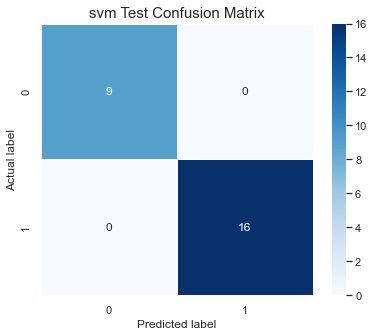

Test data shape for Random Forest: (25, 5)
Test accuracy of Random Forest: 1.0000


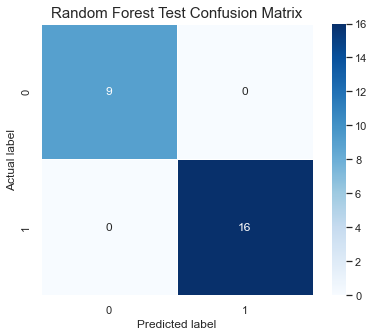

Test data shape for Logistic: (25, 10)
Test accuracy of Logistic: 1.0000


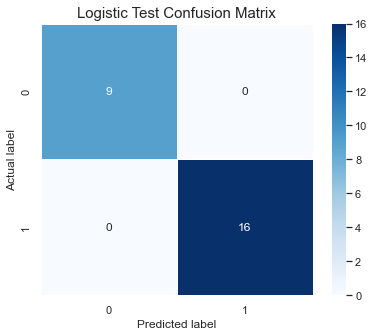

Test data shape for KNN: (25, 5)
Test accuracy of KNN: 1.0000


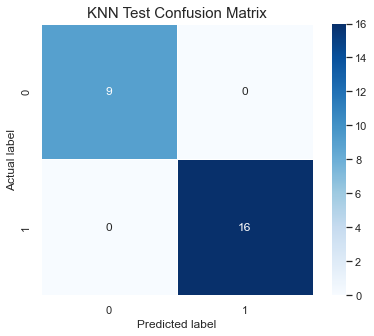

Test data shape for GradientBoosting: (25, 15)
Test accuracy of GradientBoosting: 1.0000


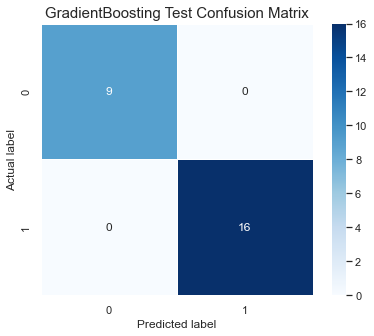

Test data shape for MLP: (25, 10)
Test accuracy of MLP: 1.0000


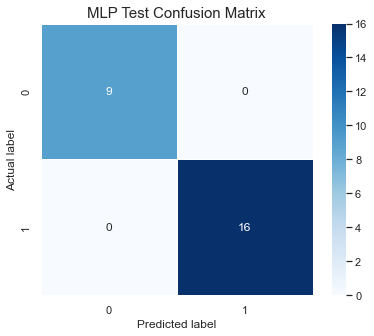

In [ ]:
# Apply the PCA transformation to the test set
X_test_pca = pca.transform(X_test)

for clf_name, clf in clfs_best_hyperparam_smarts_mcf7_pca.items():
    # Select the optimal number of principal components for this classifier
    X_test_pca_clf = X_test_pca[:,:best_components_smarts_mcf7_pca[clf_name]]
    
    # Check the shape of the transformed test data
    print(f'Test data shape for {clf_name}: {X_test_pca_clf.shape}')
    
    y_pred_test = clf.predict(X_test_pca_clf)
    
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f'Test accuracy of {clf_name}: {accuracy:.4f}')
    
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'{clf_name} Test Confusion Matrix', size=15)
    plt.show()


### 4.1.6) Second Ensemble for MCF7 SmartSeq

Accuracy of PCA Ensemble: 1.0000


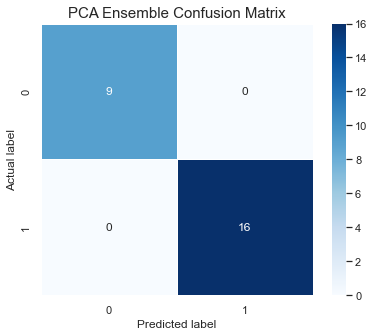

In [ ]:
# Create the PCA ensemble model
ensemble_pca = VotingClassifier(
    estimators=[(clf_name, clf) for clf_name, clf in clfs_best_hyperparam_smarts_mcf7_pca.items()], 
    voting='hard'
)

# Fit each classifier in the PCA ensemble on the appropriate subsets of the training data
for name, clf in ensemble_pca.estimators:
    clf.fit(X_train_pca[:,:best_components_smarts_mcf7_pca[name]], y_train)

# Note that the ensemble itself is not fitted, we only fit the individual classifiers

# To make a prediction, we need to get the predictions from all classifiers and then use the voting mechanism
# to get the ensemble prediction
ensemble_predictions_pca = []
for name, clf in ensemble_pca.estimators:
    X_test_pca_ensemble = X_test_pca[:,:best_components_smarts_mcf7_pca[name]]
    y_pred = clf.predict(X_test_pca_ensemble)
    ensemble_predictions_pca.append(y_pred)

# Perform hard voting i.e., majority voting
y_pred_ensemble_pca = np.rint(np.mean(ensemble_predictions_pca, axis=0)).astype(int)

# Compute the accuracy
accuracy_ensemble_pca = accuracy_score(y_test, y_pred_ensemble_pca)
print(f'Accuracy of PCA Ensemble: {accuracy_ensemble_pca:.4f}')

# Create confusion matrix
cm_ensemble_pca = confusion_matrix(y_test, y_pred_ensemble_pca)

# Plot the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm_ensemble_pca, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('PCA Ensemble Confusion Matrix', size=15)
plt.show()


### 4.1.7) Final Ensemble for MCF7 SmartSeq

Accuracy of final ensemble: 1.0000


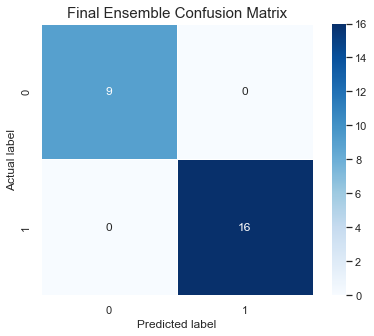

In [ ]:
# Get predictions from each classifier in the ensemble for the test set
ensemble1_predictions = []
for clf_name, clf in ensemble.estimators:
    X_test_ensemble1 = X_test[important_genes[:best_genes_smarts_mcf7_mi[clf_name]]]
    y_pred = clf.predict(X_test_ensemble1)
    ensemble1_predictions.append(y_pred)

ensemble2_predictions = []
for clf_name, clf in ensemble_pca.estimators:
    X_test_ensemble2 = X_test_pca[:,:best_components_smarts_mcf7_pca[clf_name]]
    y_pred = clf.predict(X_test_ensemble2)
    ensemble2_predictions.append(y_pred)

# The probability of each sample being classified as 1 is the sum of the votes from the classifiers
ensemble1_proba = np.sum(ensemble1_predictions, axis=0) / len(ensemble.estimators)
ensemble2_proba = np.sum(ensemble2_predictions, axis=0) / len(ensemble_pca.estimators)

# The final probability is the average of the probabilities from the two ensembles
final_proba = (ensemble1_proba + ensemble2_proba) / 2

# The final prediction is 1 if the final probability is greater than 0.5, else it's 0
final_predictions = (final_proba > 0.5).astype(int)

# Compute the accuracy of the final ensemble
accuracy_final = accuracy_score(y_test, final_predictions)
print(f'Accuracy of final ensemble: {accuracy_final:.4f}')

# Create the confusion matrix
cm_final = confusion_matrix(y_test, final_predictions)

# Plot the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm_final, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Final Ensemble Confusion Matrix', size=15)
plt.show()

## 4.2) HCC1806 SmartSeq

In [ ]:
train_data_HCC1806_SmartS = pd.read_csv("HCC1806_SmartS_Filtered_Normalised_3000_Data_train.txt", delimiter="\ ", engine='python', index_col=0).T

test_data_HCC1806_SmartS = pd.read_csv("HCC1806_SmartS_Filtered_Normalised_3000_Data_test_anonim.txt", delimiter="\ ", engine='python', index_col=0).T

train_data_HCC1806_SmartS_condition = train_data_HCC1806_SmartS.index.to_series().apply(lambda x: extract_condition(x))

X_train, X_test, y_train, y_test = train_test_split(train_data_MCF7_SmartS, train_data_MCF7_SmartS_condition,
                                                      test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(225, 3000) (25, 3000) (225,) (25,)


### 4.2.1) Mutual Information

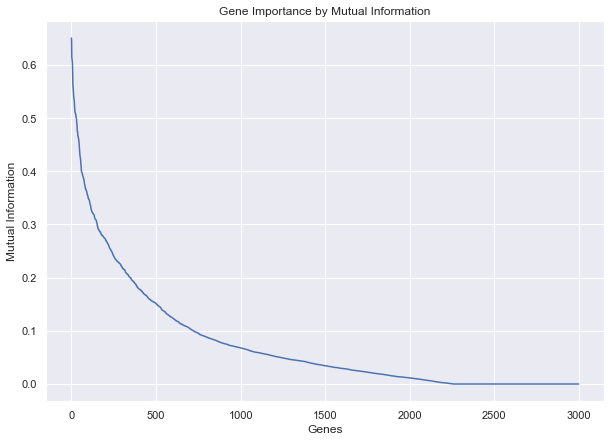

In [ ]:
# Calculate the mutual information between each gene and the target
mi = mutual_info_classif(X_train, y_train)

# Create a dictionary where the keys are the feature (gene) names and the values are the mutual information
mi_dict = {col: mi for col, mi in zip(X_train.columns, mi)}

# Sort the dictionary by the mutual information in descending order
sorted_mi_dict = sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)

# Extract the mutual information values and the gene names
mi_values = [gene[1] for gene in sorted_mi_dict]
genes = [gene[0] for gene in sorted_mi_dict]

important_genes = [gene[0] for gene in sorted_mi_dict]

# Plot the mutual information
plt.figure(figsize=(10, 7))
plt.plot(mi_values)
plt.ylabel('Mutual Information')
plt.xlabel('Genes')
plt.title('Gene Importance by Mutual Information')
plt.show()

### 4.2.2) Hyperparameter Tuning

In [ ]:
clfs_best_hyperparam_smarts_hcc1806_mi = {}
best_genes_smarts_hcc1806_mi = {}

In [ ]:
estimator = SVC(probability=True)
params = {
    'kernel': ['rbf', 'sigmoid', 'poly', 'linear'], 
    'C': loguniform(1e-3, 1e3), 
    'degree': [2, 3, 4, 5]
}

best_clf, best_n_features, param_performance = find_best_hyperparam(
    X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10
)

clfs_best_hyperparam_smarts_hcc1806_mi['svm'] = best_clf
best_genes_smarts_hcc1806_mi['svm'] = best_n_features

Best Classifier parameters: {'C': 0.004500557626448798, 'degree': 4, 'kernel': 'linear', 'n': 15}


In [ ]:
# Runs in 1 min.

estimator = RandomForestClassifier(bootstrap=True, max_samples=0.8)
params = {
    'n_estimators':[20, 30, 50, 100, 200], 
    'max_leaf_nodes': np.arange(20, 100, 10)
    }

best_rf, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_hcc1806_mi['Random Forest'] = best_rf
best_genes_smarts_hcc1806_mi['Random Forest'] = n

Best Classifier parameters: {'n_estimators': 30, 'max_leaf_nodes': 80, 'n': 50}


In [ ]:
estimator = LogisticRegression()
params = {
    'penalty': ['l2', 'l1'], 
    'C': loguniform(1e-3, 1e3), 
    'fit_intercept': [True, False], 
    'class_weight': [None, 'balanced'], 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}


best_lr, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_hcc1806_mi['Logistic'] = best_lr
best_genes_smarts_hcc1806_mi['Logistic'] = n

Best Classifier parameters: {'C': 154.6625644889637, 'class_weight': None, 'fit_intercept': False, 'penalty': 'l1', 'solver': 'liblinear', 'n': 25}


In [ ]:
estimator = KNeighborsClassifier()
params = {
    'n_neighbors': np.arange(3, 20), 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1, 2, 3, 4, 5]
}

best_knn, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_hcc1806_mi['KNN'] = best_knn
best_genes_smarts_hcc1806_mi['KNN'] = n

Best Classifier parameters: {'weights': 'distance', 'p': 4, 'n_neighbors': 7, 'metric': 'manhattan', 'n': 95}


In [ ]:
# Runs in 3 mins.

estimator = GradientBoostingClassifier()

params = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': uniform(loc=0.01, scale=0.2),
    'subsample': uniform(loc=0.5, scale=0.5),
    'max_depth': range(3, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

best_gb, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_hcc1806_mi['GradientBoosting'] = best_gb
best_genes_smarts_hcc1806_mi['GradientBoosting'] = n

Best Classifier parameters: {'learning_rate': 0.1518049941413123, 'max_depth': 4, 'min_samples_leaf': 9, 'min_samples_split': 9, 'n_estimators': 50, 'subsample': 0.7538244134042733, 'n': 10}


In [ ]:
# Runs in 5 mins.

estimator = MLPClassifier()

params = {
    'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (100, 100), (200, 200)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': uniform(loc=0.0001, scale=0.01),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 500, 1000]
}


best_mlp, n, param_performance = find_best_hyperparam(X_train=X_train, 
    y_train=y_train, 
    estimator=estimator, 
    params=params, 
    important_genes=important_genes,
    cv=5,
    n_iter=10)

clfs_best_hyperparam_smarts_hcc1806_mi['MLP'] = best_mlp
best_genes_smarts_hcc1806_mi['MLP'] = n

Best Classifier parameters: {'activation': 'relu', 'alpha': 0.001857706583213833, 'hidden_layer_sizes': (200,), 'learning_rate': 'invscaling', 'max_iter': 200, 'solver': 'sgd', 'n': 20}


Accuracy of svm: 1.0000


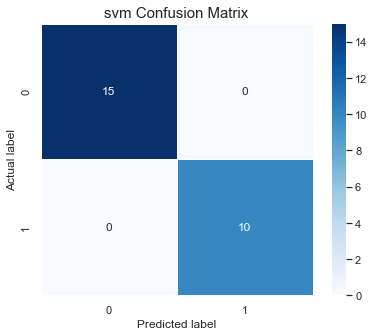

Accuracy of Random Forest: 1.0000


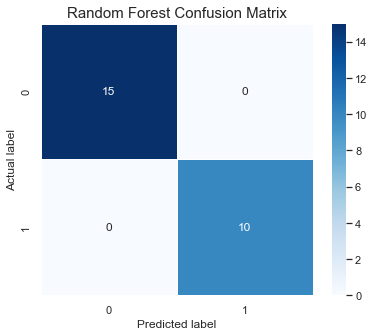

Accuracy of Logistic: 1.0000


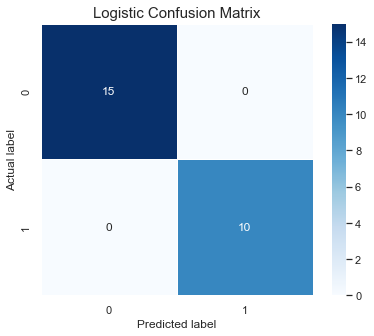

Accuracy of KNN: 1.0000


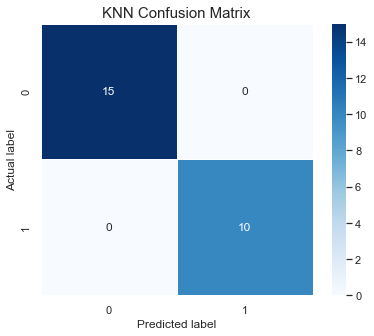

Accuracy of GradientBoosting: 1.0000


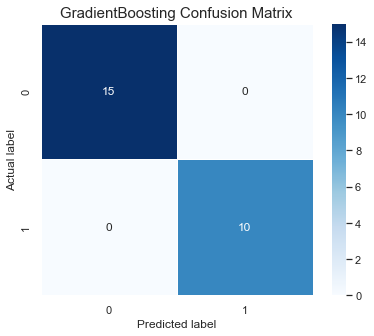

Accuracy of MLP: 0.9600


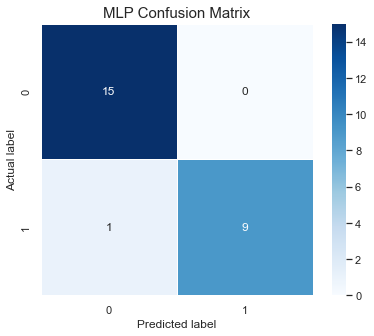

In [ ]:
for clf_name, clf in clfs_best_hyperparam_smarts_hcc1806_mi.items():
    X_test_clf = X_test[important_genes[:best_genes_smarts_hcc1806_mi[clf_name]]]
    
    y_pred = clf.predict(X_test_clf)
    
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of {clf_name}: {accuracy:.4f}')
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'{clf_name} Confusion Matrix', size=15)
    plt.show()

### 4.2.3) First Ensemble for HCC1806 SmartSeq

Accuracy of Ensemble: 1.0000


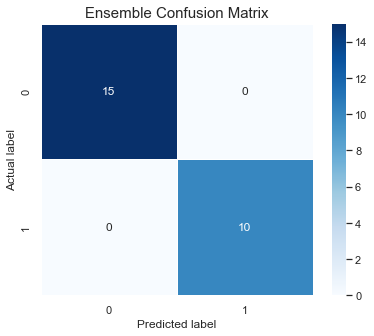

In [ ]:
# Create the ensemble model
ensemble = VotingClassifier(
    estimators=[(clf_name, clf) for clf_name, clf in clfs_best_hyperparam_smarts_hcc1806_mi.items()], 
    voting='hard'
)

# Fit each classifier in the ensemble 
for name, clf in ensemble.estimators:
    clf.fit(X_train[important_genes[:best_genes_smarts_hcc1806_mi[name]]], y_train)

# Note that the ensemble itself is not fitted, we only fit the individual classifiers

# To make a prediction, we need to get the predictions from all classifiers and then use the voting mechanism
# to get the ensemble prediction
ensemble_predictions = []
for name, clf in ensemble.estimators:
    X_test_ensemble = X_test[important_genes[:best_genes_smarts_hcc1806_mi[name]]]
    y_pred = clf.predict(X_test_ensemble)
    ensemble_predictions.append(y_pred)

# Perform hard voting i.e., majority voting
y_pred_ensemble_SmartS_MCF7 = np.rint(np.mean(ensemble_predictions, axis=0)).astype(int)

# Compute the accuracy
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble_SmartS_MCF7)
print(f'Accuracy of Ensemble: {accuracy_ensemble:.4f}')

# Create confusion matrix
cm_ensemble = confusion_matrix(y_test, y_pred_ensemble_SmartS_MCF7)

# Plot the confusion matrix
plt.figure(figsize=(7,5))
sns.heatmap(cm_ensemble, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Ensemble Confusion Matrix', size=15)
plt.show()

### 4.2.4) PCA

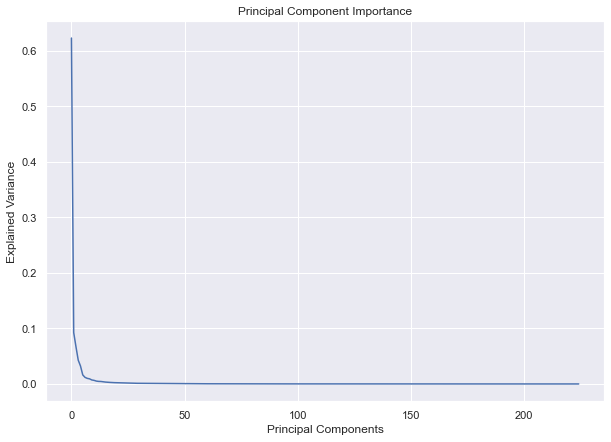

In [ ]:
pca = PCA(n_components=min(*X_train.shape))
X_train_pca = pca.fit_transform(X_train)

explained_variance = pca.explained_variance_ratio_

pc_dict = {f'PC{i+1}': ev for i, ev in enumerate(explained_variance)}

sorted_pc_dict = sorted(pc_dict.items(), key=lambda item: item[1], reverse=True)

variance_values = [pc[1] for pc in sorted_pc_dict]
pcs = [pc[0] for pc in sorted_pc_dict]

plt.figure(figsize=(10, 7))
plt.plot(variance_values)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Principal Component Importance')
plt.show()

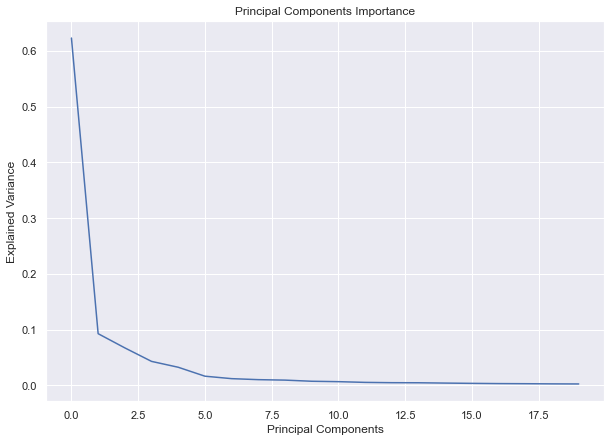

0.9513064378951783


In [ ]:
n_components = 20

variance_values = [pc[1] for pc in sorted_pc_dict[:n_components]]
pcs = [pc[0] for pc in sorted_pc_dict[:n_components]]

# Plotta la varianza spiegata
plt.figure(figsize=(10, 7))
plt.plot(variance_values)
plt.ylabel('Explained Variance')
plt.xlabel('Principal Components')
plt.title('Principal Components Importance')
plt.show()

print(sum(variance_values))

### 4.2.5) Hyperparameter Tuning

In [ ]:
clfs_best_hyperparam_smarts_hcc1806_pca = {}
best_components_smarts_hcc1806_pca = {}

In [ ]:
# Runs in 1 min.

estimator = SVC(probability=True)
params = {
    'kernel': ['rbf', 'sigmoid', 'poly', 'linear'], 
    'C': loguniform(1e-3, 1e3), 
    'degree': [2, 3, 4, 5]
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_hcc1806_pca['svm'] = clf
best_components_smarts_hcc1806_pca['svm'] = n_components

Best Classifier parameters: {'C': 4.427679487805781, 'degree': 3, 'kernel': 'linear', 'n': 10}


In [ ]:
 # Runs in 10 min.

estimator = RandomForestClassifier(bootstrap=True, max_samples=0.8)
params = {
    'n_estimators':[20, 30, 50, 100, 200], 
    'max_leaf_nodes': np.arange(20, 100, 10)
    }

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_hcc1806_pca['Random Forest'] = clf
best_components_smarts_hcc1806_pca['Random Forest'] = n_components

Best Classifier parameters: {'n_estimators': 200, 'max_leaf_nodes': 20, 'n': 5}


In [ ]:
estimator = LogisticRegression()
params = {
    'penalty': ['l2', 'l1'], 
    'C': loguniform(1e-3, 1e3), 
    'fit_intercept': [True, False], 
    'class_weight': [None, 'balanced'], 
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_hcc1806_pca['Logistic'] = clf
best_components_smarts_hcc1806_pca['Logistic'] = n_components

Best Classifier parameters: {'C': 0.007128129985186529, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2', 'solver': 'liblinear', 'n': 15}


In [ ]:
estimator = KNeighborsClassifier()
params = {
    'n_neighbors': np.arange(3, 20), 
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'],
    'p': [1, 2, 3, 4, 5]
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_hcc1806_pca['KNN'] = clf
best_components_smarts_hcc1806_pca['KNN'] = n_components

Best Classifier parameters: {'weights': 'uniform', 'p': 5, 'n_neighbors': 4, 'metric': 'chebyshev', 'n': 5}


In [ ]:
# Runs in 25 mins.
estimator = GradientBoostingClassifier()

params = {
    'n_estimators': [10, 50, 100, 200],
    'learning_rate': uniform(loc=0.01, scale=0.2),
    'subsample': uniform(loc=0.5, scale=0.5),
    'max_depth': range(3, 10),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10)
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_hcc1806_pca['GradientBoosting'] = clf
best_components_smarts_hcc1806_pca['GradientBoosting'] = n_components

Best Classifier parameters: {'learning_rate': 0.1715786441748219, 'max_depth': 9, 'min_samples_leaf': 7, 'min_samples_split': 7, 'n_estimators': 50, 'subsample': 0.6976527092082914, 'n': 5}


In [ ]:
estimator = MLPClassifier()

params = {
    'hidden_layer_sizes': [(50,), (100,), (200,), (50, 50), (100, 100), (200, 200)],
    'activation': ['logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'alpha': uniform(loc=0.0001, scale=0.01),
    'learning_rate': ['constant', 'invscaling', 'adaptive'],
    'max_iter': [200, 500, 1000]
}

clf, n_components, param_performance = find_best_hyperparam_pca(X_train_pca, y_train, estimator, params)

clfs_best_hyperparam_smarts_hcc1806_pca['MLP'] = clf
best_components_smarts_hcc1806_pca['MLP'] = n_components

Best Classifier parameters: {'activation': 'logistic', 'alpha': 0.005043079531751173, 'hidden_layer_sizes': (50, 50), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'lbfgs', 'n': 10}


Test data shape for svm: (25, 10)
Test accuracy of svm: 1.0000


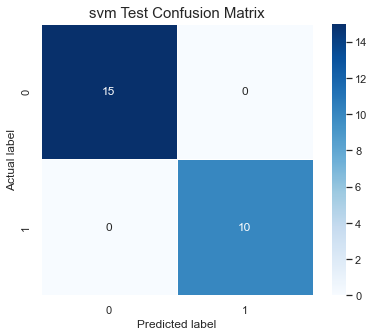

Test data shape for Random Forest: (25, 5)
Test accuracy of Random Forest: 1.0000


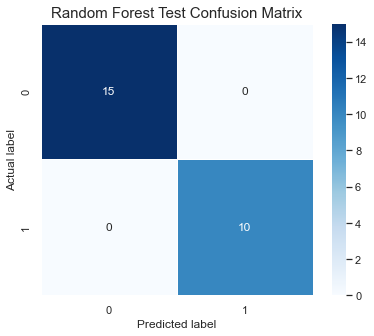

Test data shape for Logistic: (25, 15)
Test accuracy of Logistic: 1.0000


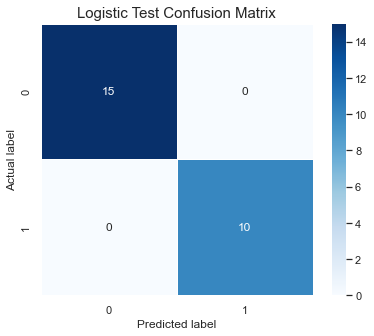

Test data shape for KNN: (25, 5)
Test accuracy of KNN: 1.0000


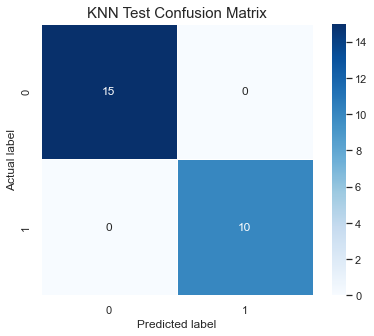

Test data shape for GradientBoosting: (25, 5)
Test accuracy of GradientBoosting: 1.0000


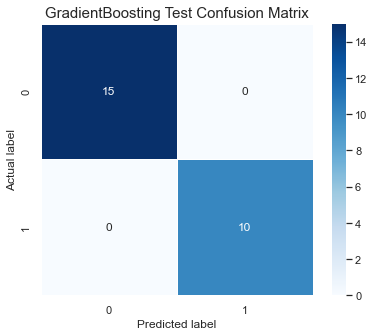

Test data shape for MLP: (25, 10)
Test accuracy of MLP: 1.0000


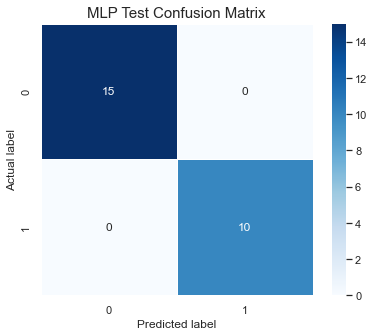

In [ ]:
# Apply the PCA transformation to the test set
X_test_pca = pca.transform(X_test)
for clf_name, clf in clfs_best_hyperparam_smarts_hcc1806_pca.items():
    # Select the optimal number of principal components for this classifier
    X_test_pca_clf = X_test_pca[:,:best_components_smarts_hcc1806_pca[clf_name]]
    
    # Check the shape of the transformed test data
    print(f'Test data shape for {clf_name}: {X_test_pca_clf.shape}')
    
    y_pred_test = clf.predict(X_test_pca_clf)
    
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f'Test accuracy of {clf_name}: {accuracy:.4f}')
    
    cm = confusion_matrix(y_test, y_pred_test)
    plt.figure(figsize=(7,5))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title(f'{clf_name} Test Confusion Matrix', size=15)
    plt.show()


### 4.2.6) Second Ensemble for HCC1806 SmartSeq

Accuracy of PCA Ensemble: 1.0000


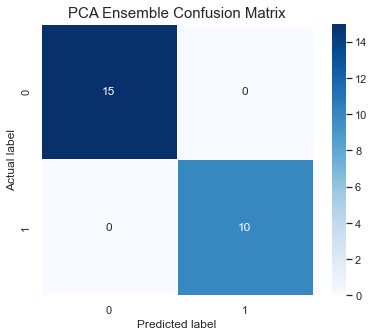

In [ ]:
# Create the PCA ensemble model
ensemble_pca = VotingClassifier(
    estimators=[(clf_name, clf) for clf_name, clf in clfs_best_hyperparam_smarts_hcc1806_pca.items()], 
    voting='hard'
)

# Fit each classifier in the PCA ensemble on the appropriate subsets of the training data
for name, clf in ensemble_pca.estimators:
    clf.fit(X_train_pca[:,:best_components_smarts_hcc1806_pca[name]], y_train)

# Note that the ensemble itself is not fitted, we only fit the individual classifiers

# To make a prediction, we need to get the predictions from all classifiers and then use the voting mechanism
# to get the ensemble prediction
ensemble_predictions_pca = []
for name, clf in ensemble_pca.estimators:
    X_test_pca_ensemble = X_test_pca[:,:best_components_smarts_hcc1806_pca[name]]
    y_pred = clf.predict(X_test_pca_ensemble)
    ensemble_predictions_pca.append(y_pred)

# Perform hard voting i.e., majority voting
y_pred_ensemble_pca = np.rint(np.mean(ensemble_predictions_pca, axis=0)).astype(int)

# Compute the accuracy
accuracy_ensemble_pca = accuracy_score(y_test, y_pred_ensemble_pca)
print(f'Accuracy of PCA Ensemble: {accuracy_ensemble_pca:.4f}')

# Create confusion matrix
cm_ensemble_pca = confusion_matrix(y_test, y_pred_ensemble_pca)

# Plot
plt.figure(figsize=(7,5))
sns.heatmap(cm_ensemble_pca, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('PCA Ensemble Confusion Matrix', size=15)
plt.show()


### 4.2.7) Final Ensemble for MCF7 SmartSeq

Accuracy of final ensemble: 1.0000


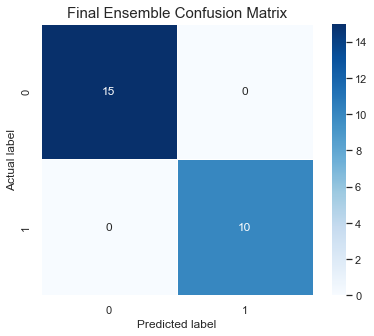

In [ ]:
# Get predictions from each classifier in the ensemble for the test set
ensemble1_predictions = []
for clf_name, clf in ensemble.estimators:
    X_test_ensemble1 = X_test[important_genes[:best_genes_smarts_hcc1806_mi[clf_name]]]
    y_pred = clf.predict(X_test_ensemble1)
    ensemble1_predictions.append(y_pred)

ensemble2_predictions = []
for clf_name, clf in ensemble_pca.estimators:
    X_test_ensemble2 = X_test_pca[:,:best_components_smarts_hcc1806_pca[clf_name]]
    y_pred = clf.predict(X_test_ensemble2)
    ensemble2_predictions.append(y_pred)

# The probability of each sample being classified as 1 is the sum of the votes from the classifiers
ensemble1_proba = np.sum(ensemble1_predictions, axis=0) / len(ensemble.estimators)
ensemble2_proba = np.sum(ensemble2_predictions, axis=0) / len(ensemble_pca.estimators)

# The final probability is the average of the probabilities from the two ensembles
final_proba = (ensemble1_proba + ensemble2_proba) / 2

# The final prediction is 1 if the final probability is greater than 0.5, else it's 0
final_predictions = (final_proba > 0.5).astype(int)

#Accuracy of the final ensemble
accuracy_final = accuracy_score(y_test, final_predictions)
print(f'Accuracy of final ensemble: {accuracy_final:.4f}')

cm_final = confusion_matrix(y_test, final_predictions)

plt.figure(figsize=(7,5))
sns.heatmap(cm_final, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Final Ensemble Confusion Matrix', size=15)
plt.show()

## 4.3) DropSeq MCF7

In [ ]:
train_data_MCF7_DropS_condition = train_data_MCF7_DropS.index.to_series().apply(lambda x: extract_condition(x))
train_data_MCF7_DropS_condition

"AAAAACCTATCG_Normoxia"    0
"AAAACAACCCTA_Normoxia"    0
"AAAACACTCTCA_Normoxia"    0
"AAAACCAGGCAC_Normoxia"    0
"AAAACCTAGCTC_Normoxia"    0
                          ..
"TTTTCGCGTAGA_Hypoxia"     1
"TTTTCGTCCGCT_Hypoxia"     1
"TTTTCTCCGGCT_Hypoxia"     1
"TTTTGTTCAAAG_Hypoxia"     1
"TTTTTTGTATGT_Hypoxia"     1
Length: 21626, dtype: int64

Since the number of samples is huge in this dataset, we can choose to work only on a part of it in order to keep the notebook computationaly feasible. 
Since we got great accuracies on unseen data on SmartSeq with a much smaller dataset, we believe this will not affect much the final work.
Of course we will randomly sample, so that we will not bias our study too much.

In [ ]:
# Create a random sample of 7000 instances
train_data_MCF7_DropS_new = train_data_MCF7_DropS.sample(n=7000, random_state=1)
train_data_MCF7_DropS_new_condition = train_data_MCF7_DropS_new.index.to_series().apply(lambda x: extract_condition(x))
train_data_MCF7_DropS_new_condition.shape

(7000,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data_MCF7_DropS_new, train_data_MCF7_DropS_new_condition,
                                                      test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6300, 3000) (700, 3000) (6300,) (700,)


In [ ]:
# Remove from train_data_MCF7 the samples from X_train
X_tia = train_data_MCF7_DropS[~train_data_MCF7_DropS.isin(X_train)].dropna()
X_tia.shape

(14876, 3000)

In [ ]:
X_tia_condition = X_tia.index.to_series().apply(lambda x: extract_condition(x))

### 4.3.1) Mutual Information

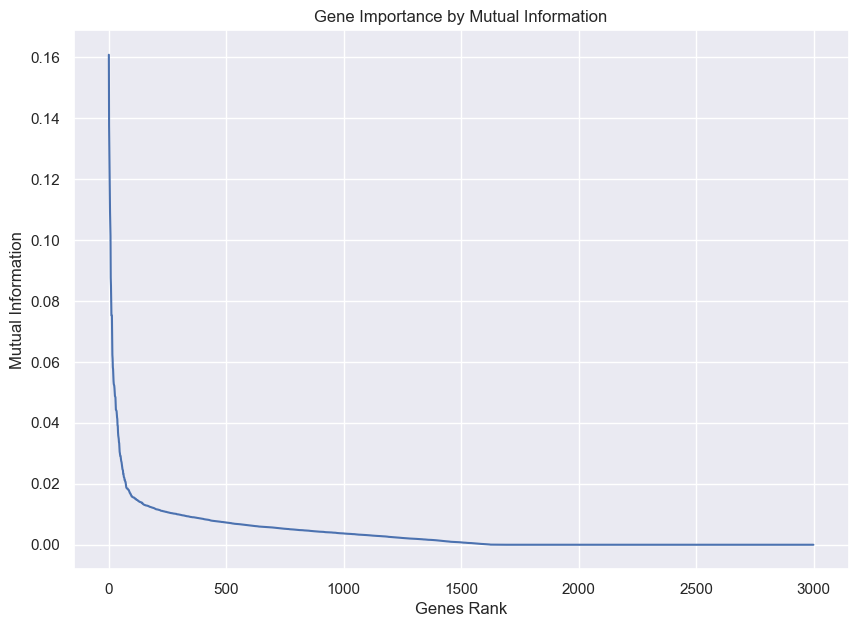

In [ ]:
# Calculate the mutual information between each gene and the target
mi = mutual_info_classif(X_train, y_train)
mi_dict = {col: mi for col, mi in zip(X_train.columns, mi)}

sorted_mi_dict = sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)

mi_values = [gene[1] for gene in sorted_mi_dict]
genes = [gene[0] for gene in sorted_mi_dict]

important_genes = [gene[0] for gene in sorted_mi_dict]

plt.figure(figsize=(10, 7))
plt.plot(mi_values)
plt.ylabel('Mutual Information')
plt.xlabel('Genes Rank')
plt.title('Gene Importance by Mutual Information')
plt.show()

### 4.3.2) Parameters Tuning and Predictions

In [ ]:
clfs_best_hyperparam_drops_mcf7_mi = {}
best_genes_drops_mcf7_mi = {}

In [ ]:
estimator = MLPClassifier(hidden_layer_sizes=[100,100],activation= "relu", solver= "sgd", max_iter= 3000)
X_train_cv = X_train[important_genes[:2000]]

estimator.fit(X=X_train_cv, y=y_train)

MLPClassifier(hidden_layer_sizes=[100, 100], max_iter=3000, solver='sgd')

In [ ]:
clfs_best_hyperparam_drops_mcf7_mi['MLP'] = estimator
best_genes_drops_mcf7_mi['MLP'] = 2000

In [ ]:
for clf_name, clf in clfs_best_hyperparam_drops_mcf7_mi.items():
    X_test_clf = X_tia[important_genes[:best_genes_drops_mcf7_mi[clf_name]]]
    
    y_pred = clf.predict(X_test_clf)
    
    accuracy = accuracy_score(X_tia_condition, y_pred)
    print(f'Accuracy of {clf_name}: {accuracy:.4f}')
    


Accuracy of MLP: 0.9787


In [ ]:
y_pred = clf.predict(X_test_clf)

In [ ]:
y_pred

array([0, 0, 0, ..., 1, 1, 0], dtype=int64)

## 4.4) DropSeq HCC1806

In [ ]:
train_data_HCC1806_DropS

"H1-5"  "MALAT1"  "MT-RNR2"  "ARVCF"  "BCYRN1"   
"AAAAAACCCGGC_Normoxia"       2         3          0        0         0  \
"AAAACCGGATGC_Normoxia"       2         3          0        0         1   
"AAAACGAGCTAG_Normoxia"       5         2          0        0         1   
"AAAACTTCCCCG_Normoxia"       1         3          0        0         0   
"AAAAGCCTACCC_Normoxia"       0        12          0        0         0   
...                         ...       ...        ...      ...       ...   
"TTTTTACCAATC_Hypoxia"        0         0          0        0         0   
"TTTTTCCGTGCA_Hypoxia"        0         4          1        0         0   
"TTTTTGCCTGGG_Hypoxia"        0         1          0        0         1   
"TTTTTGTAACAG_Hypoxia"        3         3          1        0         0   
"TTTTTTTGAATC_Hypoxia"        1         6          0        0         0   

                         "ATXN7L2"  "IGFBP3"  "H1-3"  "CTIF"  "RNF123"  ...   
"AAAAAACCCGGC_Normoxia"          0         0       2       0         0  ...  \
"AAAACCGGATGC_Normoxia"          0         0       0       0         0  ...   
"AAAACGAGCTAG_Normoxia"          0         1       3       0         0  ...   
"AAAACTTCCCCG_Normoxia"          0         0       0       0         0  ...   
"AAAAGCCTACCC_Normoxia"          0         0       0       0         0  ...   
...                            ...       ...     ...     ...       ...  ...   
"TTTTTACCAATC_Hypoxia"           0         0       0       0         0  ...   
"TTTTTCCGTGCA_Hypoxia"           0         0       0       0         0  ...   
"TTTTTGCCTGGG_Hypoxia"           0         0       0       0         0  ...   
"TTTTTGTAACAG_Hypoxia"           0         1       1       0         0  ...   
"TTTTTTTGAATC_Hypoxia"           0         1       0       0         0  ...   

                         "BATF3"  "CDKN3"  "DLD"  "PMPCA"  "ZNF165"  "SCCPDH"   
"AAAAAACCCGGC_Normoxia"        0        0      0        0         0         0  \
"AAAACCGGATGC_Normoxia"        0        0      0        0         0         0   
"AAAACGAGCTAG_Normoxia"        0        0      0        0         0         0   
"AAAACTTCCCCG_Normoxia"        0        0      0        0         0         0   
"AAAAGCCTACCC_Normoxia"        0        0      0        0         0         0   
...                          ...      ...    ...      ...       ...       ...   
"TTTTTACCAATC_Hypoxia"         0        0      0        0         0         0   
"TTTTTCCGTGCA_Hypoxia"         0        0      0        0         0         0   
"TTTTTGCCTGGG_Hypoxia"         0        0      0        0         0         0   
"TTTTTGTAACAG_Hypoxia"         0        0      0        0         0         0   
"TTTTTTTGAATC_Hypoxia"         0        0      0        0         0         0   

                         "NTAN1"  "CLIP2"  "DUSP23"  "ZNF682"  
"AAAAAACCCGGC_Normoxia"        0        0         0         0  
"AAAACCGGATGC_Normoxia"        0        0         0         0  
"AAAACGAGCTAG_Normoxia"        0        0         0         0  
"AAAACTTCCCCG_Normoxia"        0        0         0         0  
"AAAAGCCTACCC_Normoxia"        0        0         0         0  
...                          ...      ...       ...       ...  
"TTTTTACCAATC_Hypoxia"         0        0         0         0  
"TTTTTCCGTGCA_Hypoxia"         0        0         0         0  
"TTTTTGCCTGGG_Hypoxia"         0        0         0         0  
"TTTTTGTAACAG_Hypoxia"         0        0         0         0  
"TTTTTTTGAATC_Hypoxia"         0        0         0         0  

[14682 rows x 3000 columns]

In [ ]:
train_data_HCC_DropS_condition = train_data_HCC1806_DropS.index.to_series().apply(lambda x: extract_condition(x))

In [ ]:
train_data_HCC_DropS_new = train_data_HCC1806_DropS.sample(n=7000, random_state=1)
train_data_HCC_DropS_new_condition = train_data_HCC_DropS_new.index.to_series().apply(lambda x: extract_condition(x))
train_data_HCC_DropS_new_condition.shape

(7000,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_data_HCC_DropS_new , train_data_HCC_DropS_new_condition,
                                                      test_size=0.1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(6300, 3000) (700, 3000) (6300,) (700,)


In [ ]:
X_tia2 = train_data_HCC1806_DropS[~train_data_HCC1806_DropS.isin(X_train)].dropna()
X_tia2.shape

(8382, 3000)

In [ ]:
X_tia2

"H1-5"  "MALAT1"  "MT-RNR2"  "ARVCF"  "BCYRN1"   
"AAAAAACCCGGC_Normoxia"     2.0       3.0        0.0      0.0       0.0  \
"AAAACCGGATGC_Normoxia"     2.0       3.0        0.0      0.0       1.0   
"AAAACGAGCTAG_Normoxia"     5.0       2.0        0.0      0.0       1.0   
"AAAACTTCCCCG_Normoxia"     1.0       3.0        0.0      0.0       0.0   
"AAACCTCCGGCT_Normoxia"     1.0       0.0        0.0      0.0       0.0   
...                         ...       ...        ...      ...       ...   
"TTTTGCAACTGA_Hypoxia"      0.0       1.0        2.0      0.0       0.0   
"TTTTTACCAATC_Hypoxia"      0.0       0.0        0.0      0.0       0.0   
"TTTTTCCGTGCA_Hypoxia"      0.0       4.0        1.0      0.0       0.0   
"TTTTTGCCTGGG_Hypoxia"      0.0       1.0        0.0      0.0       1.0   
"TTTTTGTAACAG_Hypoxia"      3.0       3.0        1.0      0.0       0.0   

                         "ATXN7L2"  "IGFBP3"  "H1-3"  "CTIF"  "RNF123"  ...   
"AAAAAACCCGGC_Normoxia"        0.0       0.0     2.0     0.0       0.0  ...  \
"AAAACCGGATGC_Normoxia"        0.0       0.0     0.0     0.0       0.0  ...   
"AAAACGAGCTAG_Normoxia"        0.0       1.0     3.0     0.0       0.0  ...   
"AAAACTTCCCCG_Normoxia"        0.0       0.0     0.0     0.0       0.0  ...   
"AAACCTCCGGCT_Normoxia"        0.0       0.0     1.0     0.0       0.0  ...   
...                            ...       ...     ...     ...       ...  ...   
"TTTTGCAACTGA_Hypoxia"         0.0       0.0     0.0     0.0       0.0  ...   
"TTTTTACCAATC_Hypoxia"         0.0       0.0     0.0     0.0       0.0  ...   
"TTTTTCCGTGCA_Hypoxia"         0.0       0.0     0.0     0.0       0.0  ...   
"TTTTTGCCTGGG_Hypoxia"         0.0       0.0     0.0     0.0       0.0  ...   
"TTTTTGTAACAG_Hypoxia"         0.0       1.0     1.0     0.0       0.0  ...   

                         "BATF3"  "CDKN3"  "DLD"  "PMPCA"  "ZNF165"  "SCCPDH"   
"AAAAAACCCGGC_Normoxia"      0.0      0.0    0.0      0.0       0.0       0.0  \
"AAAACCGGATGC_Normoxia"      0.0      0.0    0.0      0.0       0.0       0.0   
"AAAACGAGCTAG_Normoxia"      0.0      0.0    0.0      0.0       0.0       0.0   
"AAAACTTCCCCG_Normoxia"      0.0      0.0    0.0      0.0       0.0       0.0   
"AAACCTCCGGCT_Normoxia"      0.0      0.0    0.0      0.0       0.0       0.0   
...                          ...      ...    ...      ...       ...       ...   
"TTTTGCAACTGA_Hypoxia"       0.0      0.0    1.0      0.0       0.0       0.0   
"TTTTTACCAATC_Hypoxia"       0.0      0.0    0.0      0.0       0.0       0.0   
"TTTTTCCGTGCA_Hypoxia"       0.0      0.0    0.0      0.0       0.0       0.0   
"TTTTTGCCTGGG_Hypoxia"       0.0      0.0    0.0      0.0       0.0       0.0   
"TTTTTGTAACAG_Hypoxia"       0.0      0.0    0.0      0.0       0.0       0.0   

                         "NTAN1"  "CLIP2"  "DUSP23"  "ZNF682"  
"AAAAAACCCGGC_Normoxia"      0.0      0.0       0.0       0.0  
"AAAACCGGATGC_Normoxia"      0.0      0.0       0.0       0.0  
"AAAACGAGCTAG_Normoxia"      0.0      0.0       0.0       0.0  
"AAAACTTCCCCG_Normoxia"      0.0      0.0       0.0       0.0  
"AAACCTCCGGCT_Normoxia"      0.0      0.0       0.0       0.0  
...                          ...      ...       ...       ...  
"TTTTGCAACTGA_Hypoxia"       0.0      0.0       0.0       0.0  
"TTTTTACCAATC_Hypoxia"       0.0      0.0       0.0       0.0  
"TTTTTCCGTGCA_Hypoxia"       0.0      0.0       0.0       0.0  
"TTTTTGCCTGGG_Hypoxia"       0.0      0.0       0.0       0.0  
"TTTTTGTAACAG_Hypoxia"       0.0      0.0       0.0       0.0  

[8382 rows x 3000 columns]

In [ ]:
X_tia2_condition = X_tia2.index.to_series().apply(lambda x: extract_condition(x))

### 4.4.1) Mutual Information

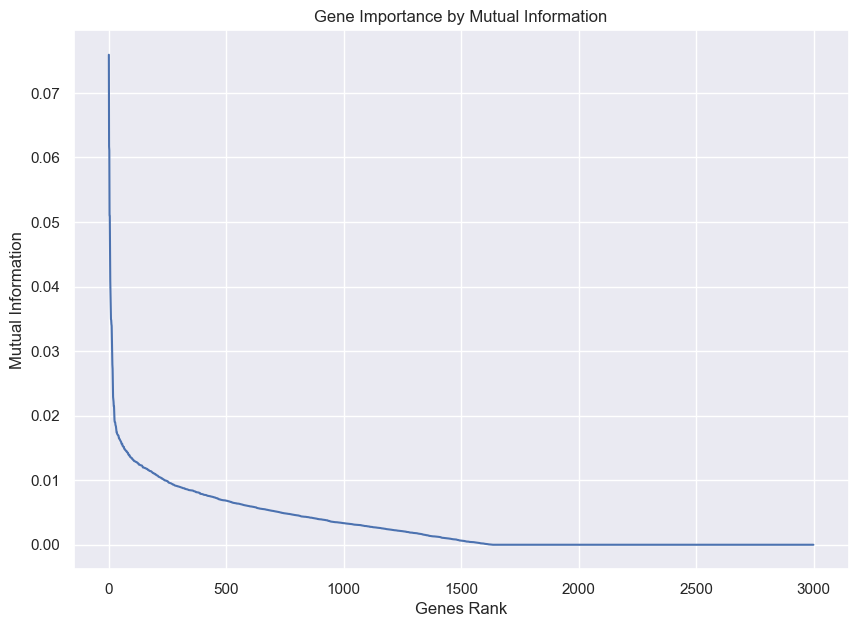

In [ ]:
mi = mutual_info_classif(X_train, y_train)
mi_dict = {col: mi for col, mi in zip(X_train.columns, mi)}

# Sort the dictionary by the mutual information in descending order
sorted_mi_dict = sorted(mi_dict.items(), key=lambda item: item[1], reverse=True)

mi_values = [gene[1] for gene in sorted_mi_dict]
genes = [gene[0] for gene in sorted_mi_dict]

important_genes = [gene[0] for gene in sorted_mi_dict]


plt.figure(figsize=(10, 7))
plt.plot(mi_values)
plt.ylabel('Mutual Information')
plt.xlabel('Genes Rank')
plt.title('Gene Importance by Mutual Information')
plt.show()

### 4.4.2) Parameters Tuning and Predictions

In [ ]:
clfs_best_hyperparam_drops_hcc_mi = {}
best_genes_drops_hcc_mi = {}

In [ ]:
estimator = MLPClassifier(hidden_layer_sizes=[100,100],activation= "tanh", solver= "sgd", max_iter= 3000)
X_train_cv = X_train[important_genes[:2000]]

estimator.fit(X=X_train_cv, y=y_train)

MLPClassifier(activation='tanh', hidden_layer_sizes=[100, 100], max_iter=3000,
              solver='sgd')

In [ ]:
clfs_best_hyperparam_drops_hcc_mi['MLP'] = estimator
best_genes_drops_hcc_mi['MLP'] = 2000

In [ ]:
for clf_name, clf in clfs_best_hyperparam_drops_hcc_mi.items():
    X_test_clf = X_tia2[important_genes[:2000]]
    
    y_pred = clf.predict(X_test_clf)
    
    accuracy = accuracy_score(X_tia2_condition, y_pred)
    print(f'Accuracy of {clf_name}: {accuracy:.4f}')
    


Accuracy of MLP: 0.9481


# 5) **Feature Selection**

## 5.0) Motivation and setting explanation

Feature selection plays a crucial role by addressing the challenges posed by high-dimensional and complex biological datasets. By reducing dimensionality, improving model performance, enhancing interpretability, and increasing computational efficiency, feature selection techniques enable researchers to extract meaningful information, identify relevant biological factors, and generate insights that drive advancements in biological knowledge and discovery.

## 5.1) Recall point 2.3.4

We use the features we selected during the feature selection procedure.

In [ ]:
final_data

## 5.2) LASSO selection

Since the genes under consideration at this stage come from a previous selection process, we consider alternative feature selection methods to complement our previous analyses. For this reason, we opt for the Lasso method as our chosen approach as it facilitates the reduction of the overall number of features to be selected, providing a valuable means of refinement in our analysis.

Since the performances of Lasso selection strictly depend on the value of the alpha parameter we employ cross-validation to choose it.

In [171]:
X_train, X_test, y_train, y_test = train_test_split(final_data, unf_condition, test_size=0.2, random_state=42)

lasso = Lasso()
alpha_values = [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2]
param_grid = {'alpha': alpha_values}

k = 5
scoring = 'neg_mean_squared_error'
grid_search = GridSearchCV(lasso, param_grid, scoring=scoring, cv=k, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_alpha = grid_search.best_params_['alpha']
best_lasso = grid_search.best_estimator_

y_pred = best_lasso.predict(X_test)
mse = mean_squared_error(y_test, y_pred)

print("Best alpha value:", best_alpha)
print("Best Lasso coefficients:", best_lasso.coef_)
print("Mean squared error:", mse)


Best alpha value: 2
Best Lasso coefficients: [-0.  0. -0. ...  0.  0. -0.]
Mean squared error: 0.05643468793232574


In [172]:
relevant_features = np.where(best_lasso.coef_ != 0)[0]
print("Most relevant features:", relevant_features)

Most relevant features: [  105   232   446   543  1112  1516  1565  1665  1668  1809  1822  2076
  2084  2156  2212  2264  2296  2426  2837  2869  3074  3087  3464  3537
  3564  3823  3858  3892  3979  4002  4007  4101  4157  4299  4346  4353
  4369  4380  4612  4641  5041  5111  5592  5595  5625  5635  5651  5797
  5873  6163  6258  6281  6376  6483  6498  6551  6819  6897  7039  7084
  7358  7571  7746  8223  8227  8614  8839  8901  8969  9016  9302  9363
  9489  9551  9582  9601  9717  9781  9944  9985 10046 10121 10270 10516
 10586 10608 10641 10802 10915 11003 11316 11330 11651 11871 11919 12019
 12076 12248 12249 12288 12358 12444 12599 12629 12745 12830 13002 13102
 13735 13747 14053 14169 14284 14520 14725 14729 14973 15012 15082 15114
 15168 15420 15446 15504 15522 15524 15676 15679 15743 16357 16402]


In [177]:
names = final_data.T.iloc[relevant_features]

In [182]:
selected_genes = np.array(names.index)

## 5.4) Suggested Gene Knock-Out plan


*The final part of this section has been developed imagining a collaboration with a hypothetical team of biologists, contributing to a larger-scale research question in which our project serves as integral component*.

Cancer Types:
HCC (Hepatocellular Carcinoma)
MCF7 (Breast Cancer)


Selected Features:


In [183]:
selected_genes

array(['"ANXA2"', '"IGFBP3"', '"DSCAM-AS1"', '"HSPA5"', '"ATP1A1"',
       '"TMEM64"', '"MT1X"', '"HSPA6"', '"BMP7"', '"TUBA1B"', '"CLDN4"',
       '"CYP1B1"', '"ESYT1"', '"UGDH"', '"NR4A1"', '"PFKP"', '"MALAT1"',
       '"HNRNPC"', '"C19orf48"', '"SNRPD2"', '"EMP2"', '"MT-CO3"',
       '"MT-RNR1"', '"TFF1"', '"FLNB"', '"TGIF1"', '"THBS1"', '"CYP1A1"',
       '"IFITM3"', '"PKM"', '"ZMYND8"', '"ARPC1B"', '"KRT81"', '"CFL1"',
       '"FLNA"', '"SULF2"', '"FOS"', '"PHLDA1"', '"RASD1"', '"XRCC6"',
       '"KPNA2"', '"NQO1"', '"GPRC5A"', '"APLP2"', '"MYL6"', '"MIF-AS1"',
       '"COX6C"', '"CDKN1A"', '"POLR2A"', '"TAGLN2"', '"KRT19"', '"ENO1"',
       '"SOX4"', '"TNFRSF12A"', '"TMSB10"', '"PIM3"', '"FXYD3"',
       '"MYL12A"', '"PREX1"', '"BSG"', '"UBC"', '"AHNAK"', '"PRMT1"',
       '"COPE"', '"RPL8"', '"DDX5"', '"GSTM3"', '"ACTG1"', '"H2BC21"',
       '"CYC1"', '"KRT8"', '"PPP2R1A"', '"HSPB1"', '"SNRNP200"',
       '"CRIP2"', '"TRIB3"', '"CEACAM6"', '"LSR"', '"PRDX2"', '"LDHA"',
       '"

# 6) **Conclusions**

As follows we propose the final classifiers for each dataset.

In [ ]:
final_classifier_smart = VotingClassifier(estimators=[('ensemble1', classifier_ensemble), ('ensemble2', classifier_ensemble_pca)])
final_classifier_drop_MCF = MLPclassifier(hidden_layer_sizes=[100,100],activation="relu",solver = "sgd",max_iter=3000)
final_classifier_drop_HCC = MLPclassifier(hidden_layer_sizes=[100,100],activation="relu",solver = "sgd",max_iter=3000)

pipeline_smart = Pipeline([
    ('feature_selection_mutual', SelectKBest(score_func=mutual_info_classif)),
    ('pca', pca),
    ('final_classifier', final_classifier_smart)
])

pipeline_drop_MCF = Pipeline([
    ('feature_selection_mutual', SelectKBest(score_func=mutual_info_classif)),
    ('final_classifier', final_classifier_drop_MCF)
])

pipeline_drop_HCC = Pipeline([
    ('feature_selection_mutual', SelectKBest(score_func=mutual_info_classif)),
    ('final_classifier', final_classifier_drop_HCC)
])

# 6) **Accuracy on Test Data**

In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [9]:
HCC_smart = pd.read_csv('HCC1806_smart_table_pr.csv')
HCC_drop = pd.read_csv('HCC1806_drop_table_pr.csv')
MCF_smart = pd.read_csv('MCF7_smart_table_pr.csv')
MCF_drop = pd.read_csv('MCF7_drop_table_pr.csv')

def confusion_matrix_labels(df):
    group_names = ['True Norm','False Hypo','False Norm','True Hypo']
    group_counts = ["{0:0.0f}".format(value) for value in df.to_numpy().flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in df.to_numpy().flatten()/np.sum(df.to_numpy())]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    return labels

def accuracy(df):
    counts = df.to_numpy().flatten()
    accuracy = (counts[0] + counts[3])/ counts.sum()
    return accuracy
    

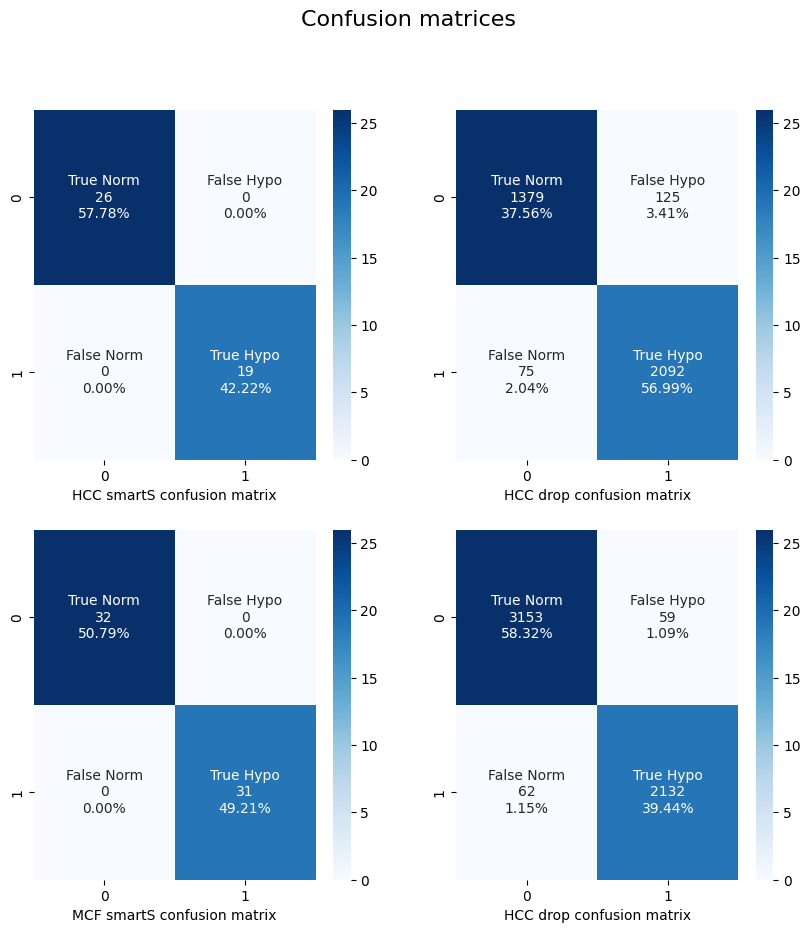

In [7]:
fig, axes = plt.subplots(2, 2, sharey=False, figsize=(10, 10))
fig.suptitle('Confusion matrices', fontsize=16)


sns.heatmap(HCC_smart, annot=confusion_matrix_labels(HCC_smart), fmt='', cmap='Blues',ax=axes[0,0])
axes[0,0].set_xlabel('HCC smartS confusion matrix')
sns.heatmap(HCC_smart, annot=confusion_matrix_labels(HCC_drop), fmt='', cmap='Blues',ax=axes[0,1])
axes[0,1].set_xlabel('HCC drop confusion matrix')
sns.heatmap(HCC_smart, annot=confusion_matrix_labels(MCF_smart), fmt='', cmap='Blues',ax=axes[1,0])
axes[1,0].set_xlabel('MCF smartS confusion matrix')
sns.heatmap(HCC_smart, annot=confusion_matrix_labels(MCF_drop), fmt='', cmap='Blues',ax=axes[1,1])
axes[1,1].set_xlabel('HCC drop confusion matrix');

In [12]:
# Accuracy 
print("MCF7_smartS accuracy :", accuracy(MCF_smart))
print("HCC_smartS accuracy :", accuracy(HCC_smart))
print("MCF7_drop accuracy :", accuracy(MCF_drop))
print("HCC_drop accuracy :", accuracy(HCC_drop))


MCF7_smartS accuracy : 1.0
HCC_smartS accuracy : 1.0
MCF7_drop accuracy : 0.9776174620791713
HCC_drop accuracy : 0.9455189321710705


#7) **Bibliography**

https://www.nature.com/articles/s41467-017-02787-4

https://kb.10xgenomics.com/hc/en-us/articles/360001086611-Why-do-I-see-a-high-level-of-mitochondrial-gene-expression-

https://www.biorxiv.org/content/10.1101/2020.04.23.058156v1

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-022-04775-y#availability-of-data-and-materials

https://academic.oup.com/bioinformatics/article/37/Supplement_1/i214/6319699?login=true#284155297

https://expert.cheekyscientist.com/how-to-perform-doublet-discrimination-in-flow-cytometry/

http://bioconductor.org/books/3.13/OSCA.advanced/doublet-detection.html

https://pubmed.ncbi.nlm.nih.gov/11746105/

https://pubmed.ncbi.nlm.nih.gov/36114620/

https://scholar.google.co.uk/citations?view_op=view_citation&hl=en&user=abd1LXcAAAAJ&citation_for_view=abd1LXcAAAAJ:u-x6o8ySG0sC

# Correction